In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stock_project_functions_SAVE as spf
import model_functions_SAVE as mf
df=pd.read_csv('All_Stock_Data_TTM_RS_2022-2024.csv')
etf_df=pd.read_csv('All_ETF_Data_TTM_RS_2022-2024.csv')

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_rs_correlation_heatmap(df, columns, target_variable,column_desc):
    """
    Plot a correlation heatmap between specified columns and a target variable.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    columns (list): List of column names to correlate with the target variable.
    target_variable (str): The name of the target variable column.
    """
    # Calculate correlations between specified columns and the target variable
    correlations = df[columns + [target_variable]].corr('spearman')[target_variable][:-1]
    
    # Reshape the correlations into a DataFrame for heatmap
    correlation_data = correlations.to_frame().T
    
    # Create the heatmap
    plt.figure(figsize=(20, 2))
    sns.heatmap(correlation_data, 
                annot=True, 
                cmap='BuPu', 
                vmin=-1, 
                vmax=1, 
                center=0,
                fmt='.4f')  # 4 decimal places
    
    plt.title(f'Spearman Correlation: {column_desc} vs {target_variable}')
    plt.xlabel('Columns')
    plt.ylabel(target_variable)
    plt.tight_layout()
    plt.show()

def create_performance_label(df, holding_period):
    pct_change_col = f'Pct_Change_{holding_period}'
    #df[pct_change_col] = df.groupby('Ticker')['Close'].pct_change(periods=holding_period).shift(-holding_period)
    
    # Separate positive and negative changes
    positive_changes = df[df[pct_change_col] > 0][pct_change_col]
    negative_changes = df[df[pct_change_col] <= 0][pct_change_col]
    
    # Calculate medians
    positive_median = positive_changes.median()
    negative_median = negative_changes.median()
    
    def categorize(value):
        if pd.isna(value):
            return np.nan
        elif value <= negative_median:
            return 0  # Strong negative
        elif negative_median < value <= 0:
            return 1  # Slight negative
        elif 0 < value < positive_median:
            return 2  # Slight positive
        else:
            return 3  # Strong positive
    
    df['Performance_Label'] = df[pct_change_col].apply(categorize)
    return df






# Correlation Between Relative Strength Values and Pct_Change_1

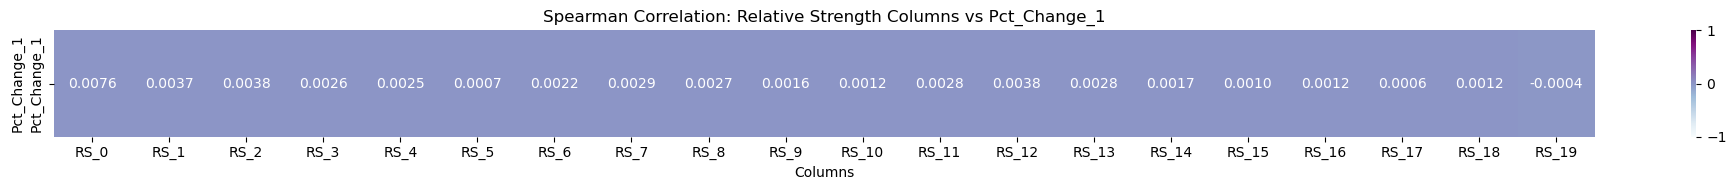

In [14]:
rs_columns = [f'RS_{i}' for i in range(20)]
plot_rs_correlation_heatmap(df, columns=rs_columns, target_variable='Pct_Change_1',column_desc='Relative Strength Columns')

**There is little correlation Between the relative strength values and the percent change 1 day later**

# Correlation between Relative Strength_Values and the Performance Label
### &emsp; Performance Label Description
#### &emsp;&emsp;-0:Strong Down
#### &emsp;&emsp;-1:Down
#### &emsp;&emsp;-2:UP
#### &emsp;&emsp;-0:Strong Up


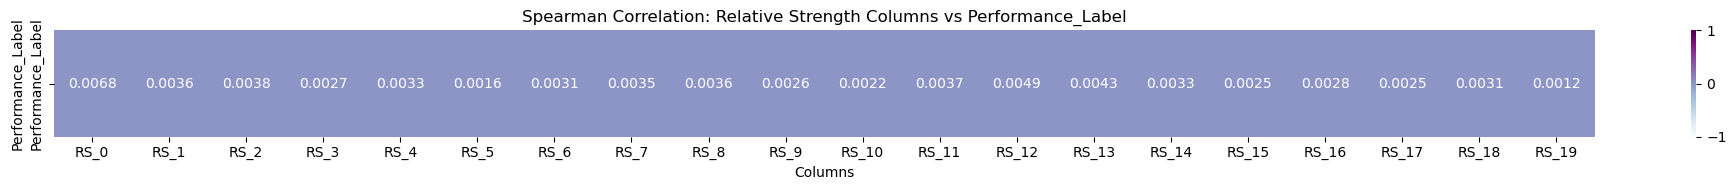

In [16]:
df=create_performance_label(df,1)
plot_rs_correlation_heatmap(df, columns=rs_columns, target_variable='Performance_Label',column_desc='Relative Strength Columns')

**There is very littler correlation between the performance label and the relative Strength Values**


# Slope of the Relative Strength Values
### &emsp;-RS_Slope: Slope of the previous 20 days of relative strength values
### &emsp;-RS_Slope_1: Slope of relative strength values 20 to 14 days away from investment date
### &emsp;-RS_Slope_2: Slope of relative strength values 14 to 7 days away from investment date
### &emsp;-RS_Slope_3: Slope of relative strength values 6 to 1 days away from investment date. (most recent)


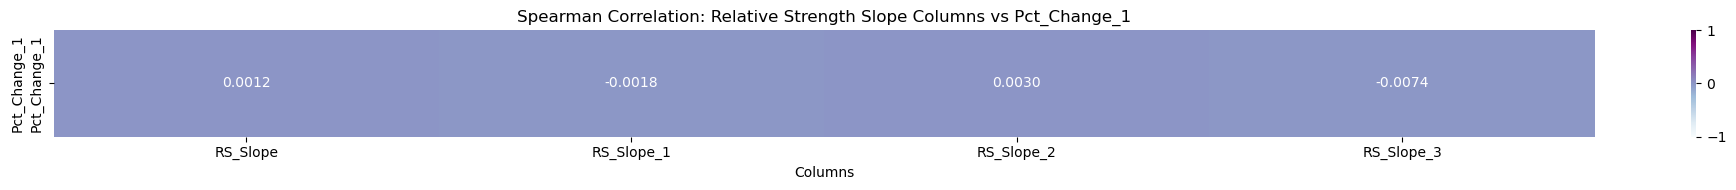

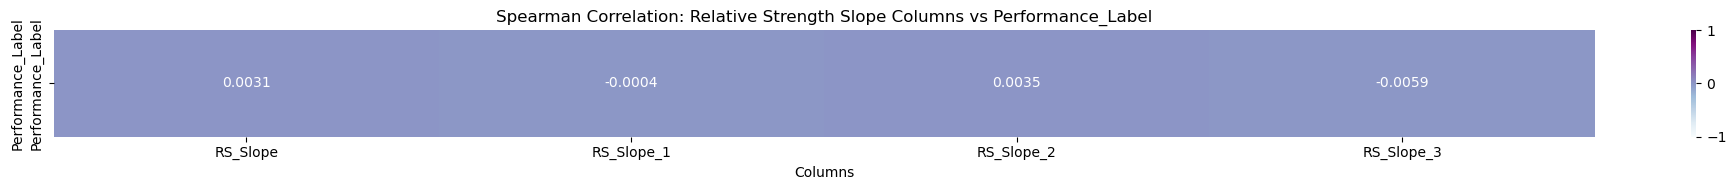

In [102]:
rs_slopes=[col for col in df.columns if 'RS_Slope' in col]
plot_rs_correlation_heatmap(df, columns=rs_slopes, target_variable='Pct_Change_1',column_desc='Relative Strength Slope Columns')
plot_rs_correlation_heatmap(df, columns=rs_slopes, target_variable='Performance_Label',column_desc='Relative Strength Slope Columns')

**Still shows very little monotonic relationship between the slopes of the relative strength values and the percent gain 1 day later.**

# Correlation between the Correlation Coefficient (with time) and the Percent gain/Performance Label

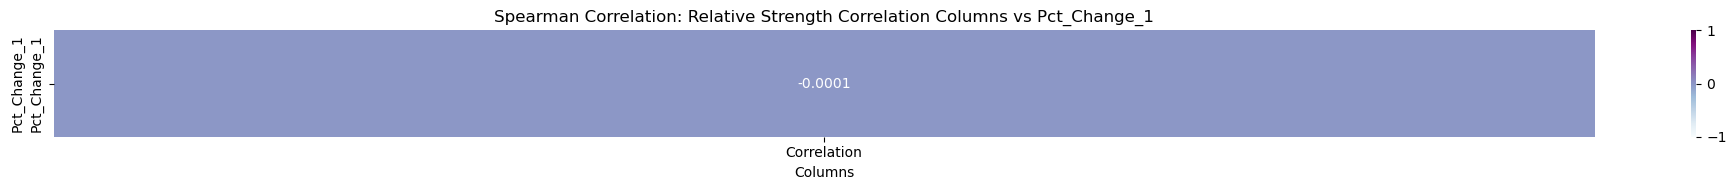

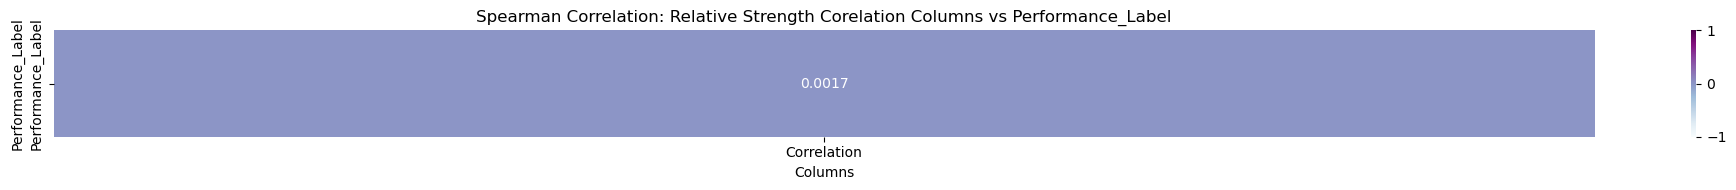

In [100]:
plot_rs_correlation_heatmap(df, columns=['Correlation'], target_variable='Pct_Change_1',column_desc='Relative Strength Correlation Columns')
plot_rs_correlation_heatmap(df, columns=['Correlation'], target_variable='Performance_Label',column_desc='Relative Strength Corelation Columns')

**Tiny Correlation Coefficients.  This suggests there is very little predictive power in these values.**

# Correlation between the Product of RS_Corr and RS_Slope and Percent Change.

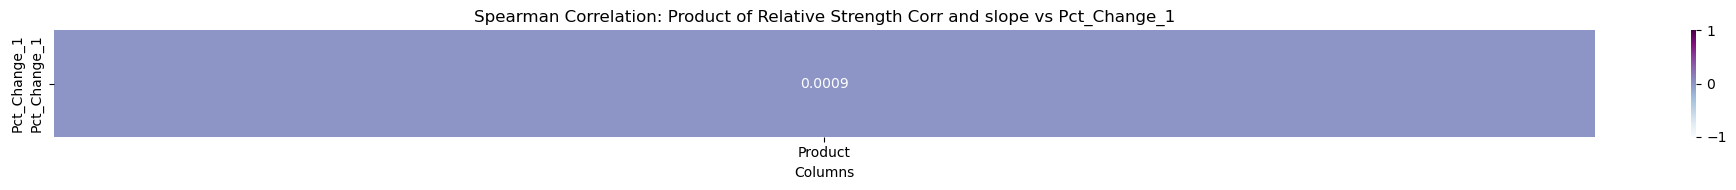

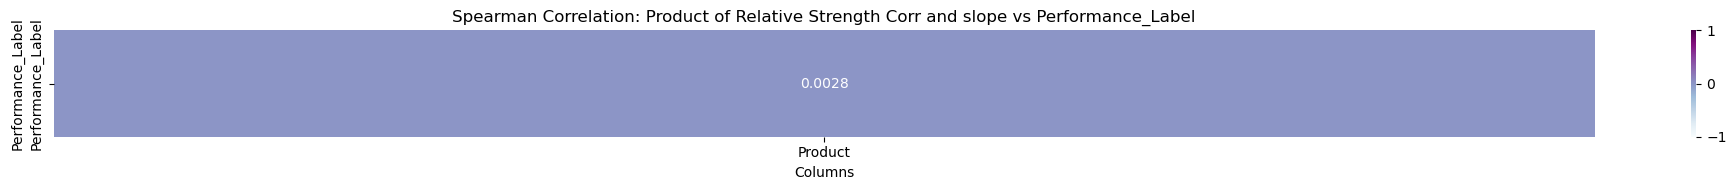

In [18]:
df['Product']=abs(df['Correlation'])*df['RS_Slope']
plot_rs_correlation_heatmap(df, columns=['Product'], target_variable='Pct_Change_1',column_desc='Product of Relative Strength Corr and slope')
plot_rs_correlation_heatmap(df, columns=['Product'], target_variable='Performance_Label',column_desc='Product of Relative Strength Corr and slope')

# Correlation between the Volatility and Percent Change.
### &emsp;-Volatility in this case is defined as the standard deviation of the relative strength values.

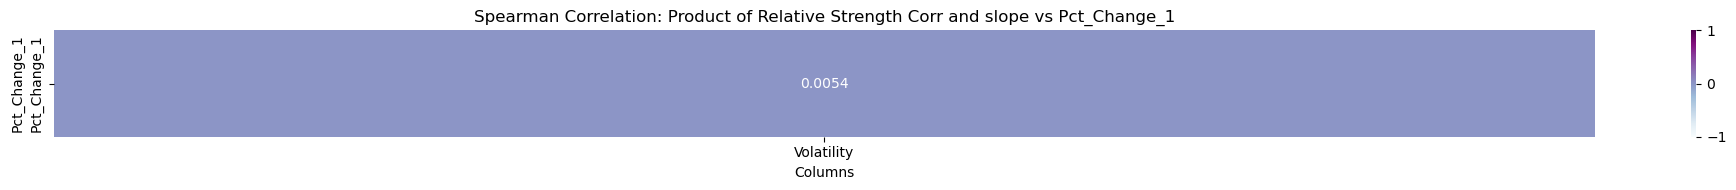

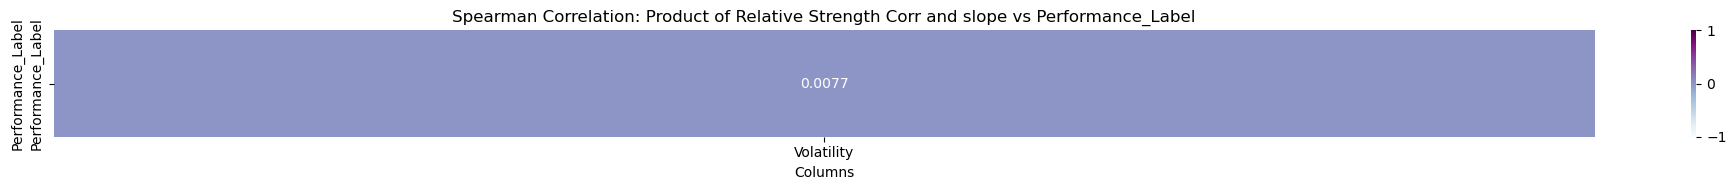

In [106]:
plot_rs_correlation_heatmap(df, columns=['Volatility'], target_variable='Pct_Change_1',column_desc='Product of Relative Strength Corr and slope')
plot_rs_correlation_heatmap(df, columns=['Volatility'], target_variable='Performance_Label',column_desc='Product of Relative Strength Corr and slope')

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

def plot_rs_and_close(df, target_date, ticker, col_to_plot='RS'):
    target_date = pd.to_datetime(target_date).date()
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    data = df[df['Ticker'] == ticker].sort_values(by='Date')
    
    # Find the nearest date to the target date
    nearest_date = min(data['Date'], key=lambda x: abs(x - target_date))
    print(f"Target date: {target_date}, Nearest date: {nearest_date}")

    the_row = data[data['Date'] == nearest_date].iloc[0]
    print(f"Pct_Change_1: {the_row['Pct_Change_1']}")
    
    rs_values_to_plot = [the_row[f'RS_{i}'] for i in range(20)]

    # Get data for plotting
    start_date = nearest_date - timedelta(days=20)
    end_date = nearest_date + timedelta(days=20)
    plot_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].set_index('Date')

    print(f"Investment date: {nearest_date}")
    print(f"Number of RS values: {len(rs_values_to_plot)}")
    print(f"Number of data points: {len(plot_data)}")

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(15, 7))
    
    # Plot RS values as bars
    rs_dates = [nearest_date - timedelta(days=19-i) for i in range(20)]
    ax1.bar(rs_dates, rs_values_to_plot, alpha=0.5, color='b', label='RS')
    ax1.set_ylabel(f'{col_to_plot}', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.tick_params(axis='x',rotation=45)
    # Create a twin axis for Close values
    ax2 = ax1.twinx()
    ax2.plot(plot_data.index, plot_data['Close'], color='r', label='Close')
    ax2.set_ylabel('Close Price', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Set title and labels
    plt.title(f'{ticker}: RS and Close Values around {nearest_date}')
    plt.xlabel('Date')
    
    # Set x-axis ticks and labels
    all_dates = list(plot_data.index)
    tick_dates = all_dates[::5] + [nearest_date]
    tick_dates = sorted(set(tick_dates))  # Remove duplicates and sort
    plt.xticks(tick_dates, [d.strftime('%Y-%m-%d') for d in tick_dates], rotation=45, ha='right')
    
    # Add vertical line at the investment date
    plt.axvline(x=nearest_date, color='g', linestyle='--', label='Investment Date (RS_19)')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print diagnostic information and checks
    #print(f"Number of data points plotted: {len(plot_data)}")
    #print(f"Date range plotted: {plot_data.index[0]} to {plot_data.index[-1]}")
    #print(f"RS range: {min(rs_values_to_plot)} to {max(rs_values_to_plot)}")
    #print(f"Close range: {plot_data['Close'].min()} to {plot_data['Close'].max()}")
    
    # Check alignment of RS_19 and investment date
    rs_19_date = rs_dates[-1]
    #print(f"RS_19 date: {rs_19_date}")
    #print(f"Investment date: {nearest_date}")
    #print(f"RS_19 aligns with investment date: {rs_19_date == nearest_date}")
    
    # Check Close price on investment date
    if nearest_date in plot_data.index:
        investment_close = plot_data.loc[nearest_date, 'Close']
        print(f"Close price on investment date: {investment_close}")
        print(f"Close price from the_row: {the_row['Close']}")
        print(f"Close prices match: {investment_close == the_row['Close']}")
    else:
        print("Warning: Investment date not in Close price data")


In [405]:
print(df['RS_Slope'].describe())
print(df['Correlation'].describe())

count    388763.000000
mean          0.000044
std           0.003897
min          -0.046766
25%          -0.002016
50%          -0.000037
75%           0.001996
max           0.071866
Name: RS_Slope, dtype: float64
count    388763.000000
mean         -0.006029
std           0.643866
min          -1.000000
25%          -0.640351
50%          -0.015789
75%           0.631579
max           1.000000
Name: Correlation, dtype: float64


Target date: 2021-04-16, Nearest date: 2021-04-16
Pct_Change_1: -0.0089150333372522
Investment date: 2021-04-16
Number of RS values: 20
Number of data points: 28


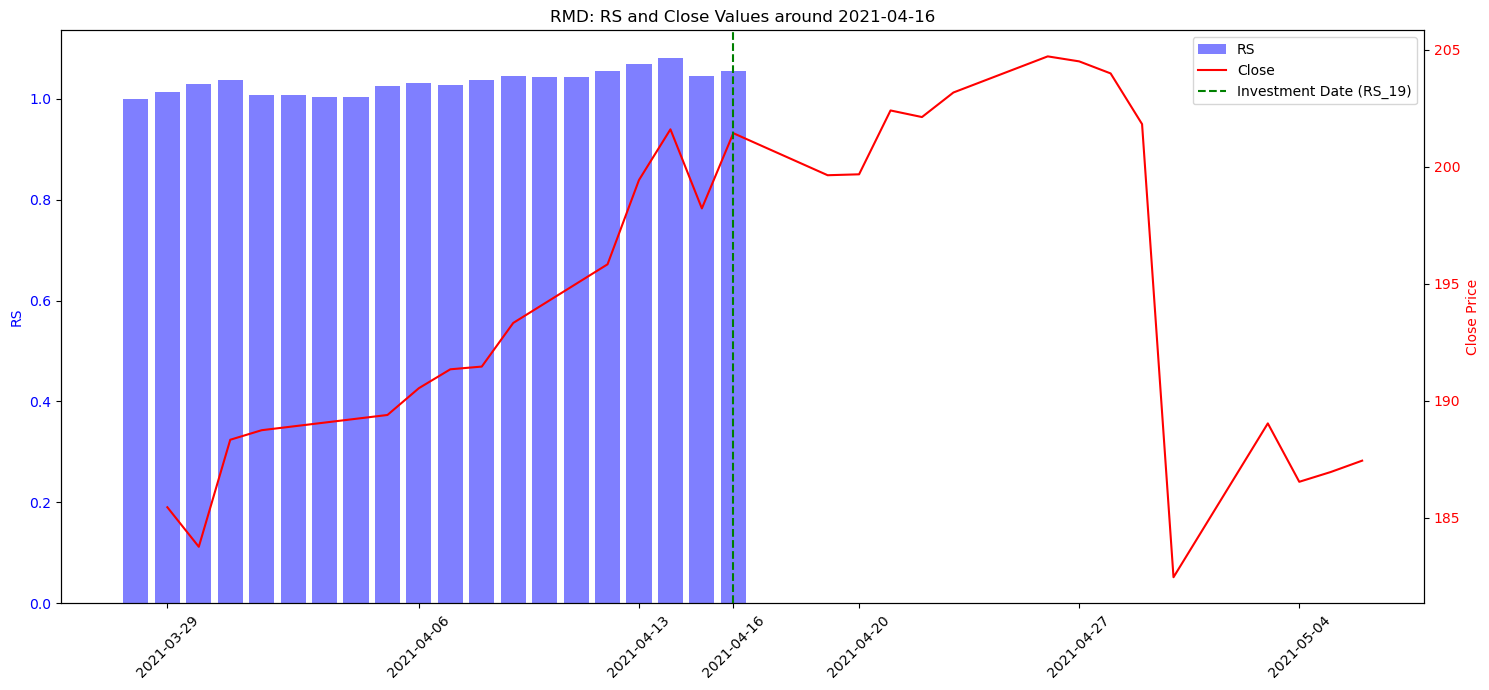

Close price on investment date: 201.428955078125
Close price from the_row: 201.428955078125
Close prices match: True


In [14]:
high_slope=df[df['RS_Slope']>df['RS_Slope'].quantile(0.75)]

plot_rs_and_close(df, high_slope['Date'].values[4200], high_slope['Ticker'].values[4200])

Target date: 2021-04-20, Nearest date: 2021-04-20
Pct_Change_1: 0.006678787416083
Investment date: 2021-04-20
Number of RS values: 20
Number of data points: 28


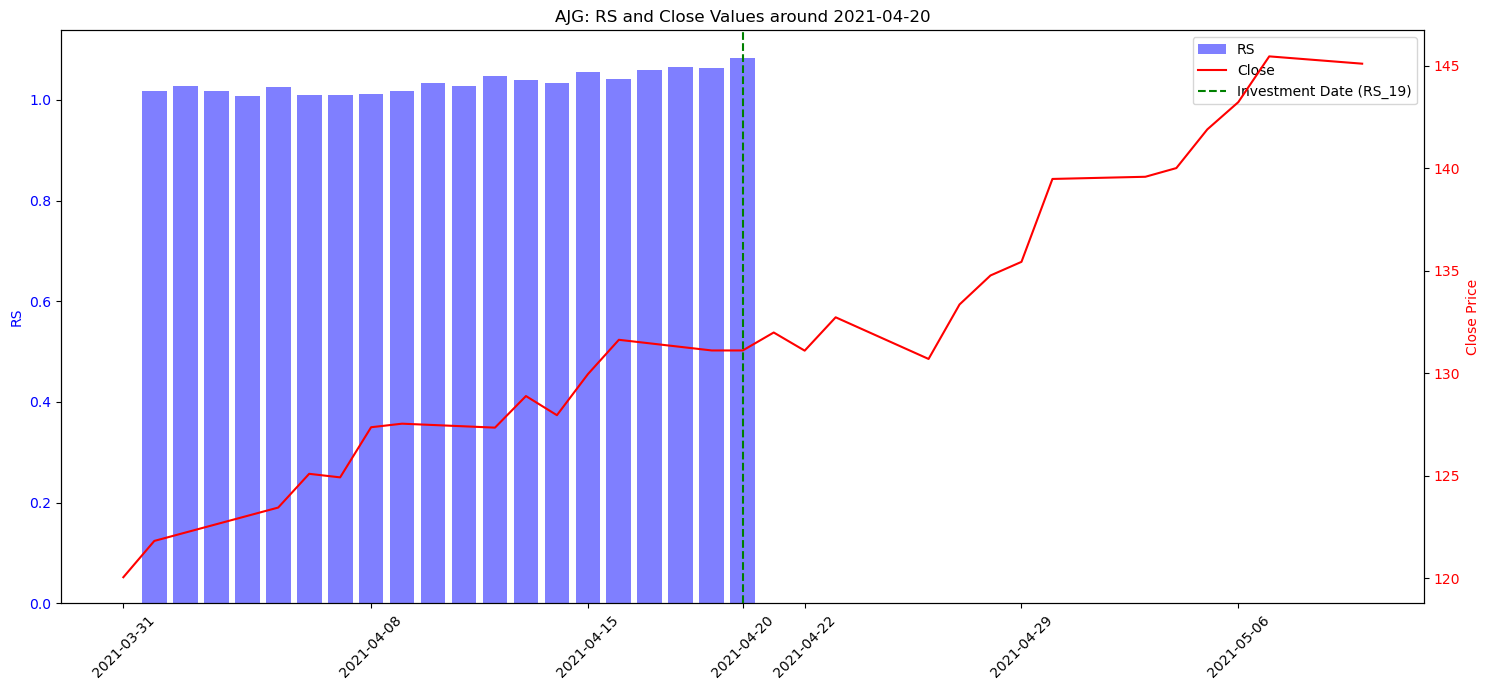

Close price on investment date: 131.11004638671875
Close price from the_row: 131.11004638671875
Close prices match: True


In [435]:
plot_rs_and_close(df, high_slope['Date'].values[4300], high_slope['Ticker'].values[4300])

Target date: 2021-04-23, Nearest date: 2021-04-23
Pct_Change_1: 0.0075967027179834
Investment date: 2021-04-23
Number of RS values: 20
Number of data points: 29


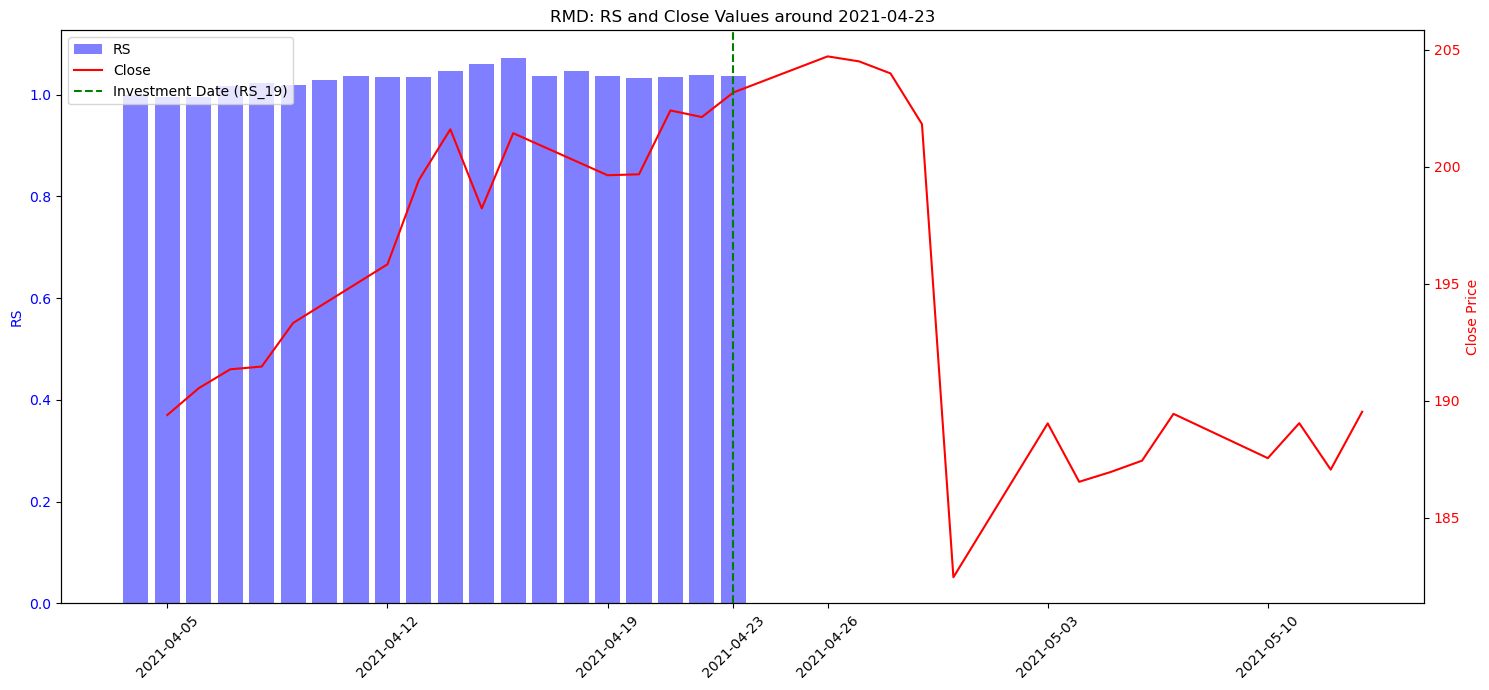

Close price on investment date: 203.16656494140625
Close price from the_row: 203.16656494140625
Close prices match: True


In [411]:
plot_rs_and_close(df, high_slope['Date'].values[4600], high_slope['Ticker'].values[4600])

Target date: 2021-04-01, Nearest date: 2021-04-01
Pct_Change_1: 0.034319881883106
Investment date: 2021-04-01
Number of RS values: 20
Number of data points: 28


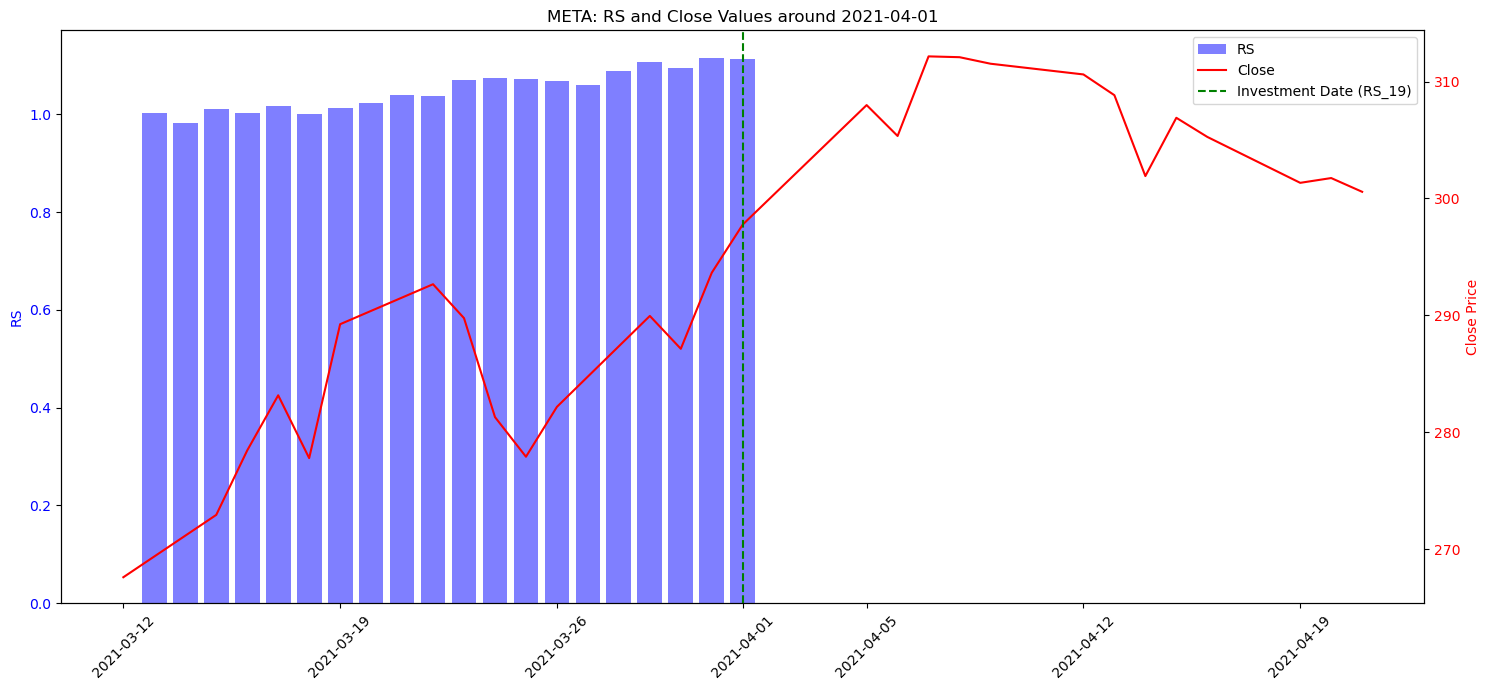

Close price on investment date: 297.76348876953125
Close price from the_row: 297.76348876953125
Close prices match: True


In [437]:
plot_rs_and_close(df, high_slope['Date'].values[3200], high_slope['Ticker'].values[3200])

Target date: 2021-04-05, Nearest date: 2021-04-05
Pct_Change_1: -0.0238819228932572
Investment date: 2021-04-05
Number of RS values: 20
Number of data points: 28


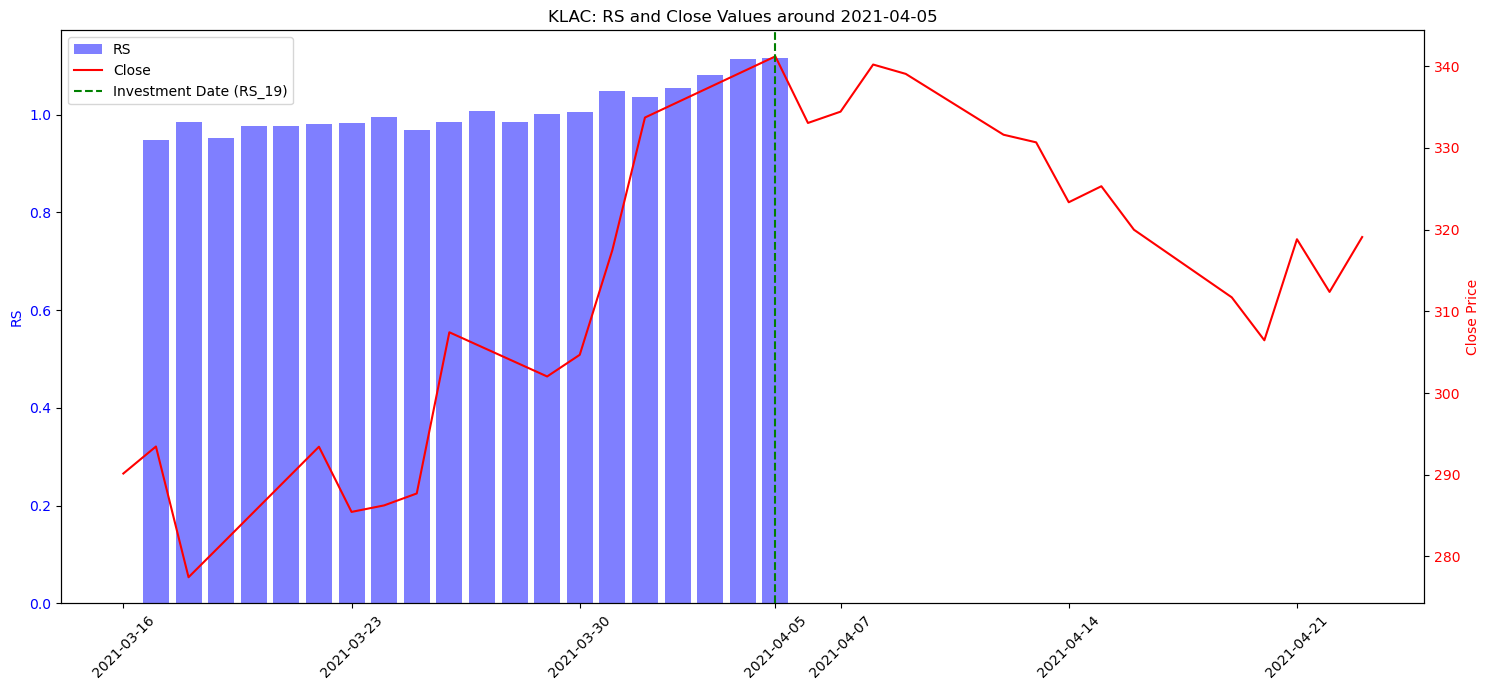

Close price on investment date: 341.1994323730469
Close price from the_row: 341.1994323730469
Close prices match: True


In [415]:
plot_rs_and_close(df, high_slope['Date'].values[3300], high_slope['Ticker'].values[3300])

In [417]:
print('Average Percent Gain (1 day hold) for high sloped stocks',high_slope['Pct_Change_1'].mean())
print('Average Percent Gain (1 day hold) for all stocks',df['Pct_Change_1'].mean())

Average Percent Gain (1 day hold) for high sloped stocks 0.0006111458942836579
Average Percent Gain (1 day hold) for all stocks 0.0004937599536376715


**The Tickers and dates in the graphs above were selected at random.  They show that 3/5 times the stock increased in price the next day.  This is consistent with the average percent change results above.  Slopes with higher slopes did generate a slightly higher average percent change for a 1 day hold.**

# High Product

In [419]:
df['Product'].describe()

count    3.887630e+05
mean     4.338599e-05
std      3.233585e-03
min     -4.266353e-02
25%     -1.279068e-03
50%     -9.298049e-07
75%      1.252813e-03
max      7.161384e-02
Name: Product, dtype: float64

Target date: 2021-04-20, Nearest date: 2021-04-20
Pct_Change_1: 0.0103425458637888
Investment date: 2021-04-20
Number of RS values: 20
Number of data points: 28


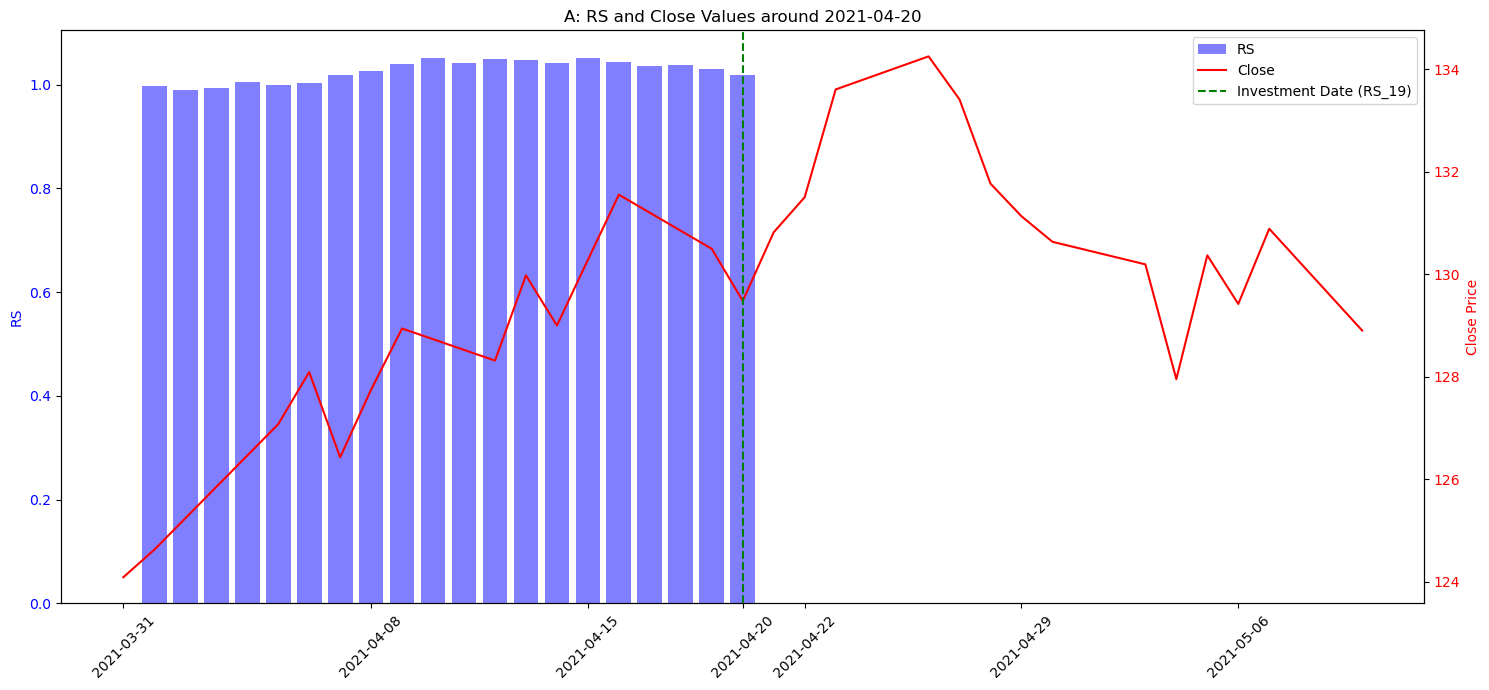

Close price on investment date: 129.4818878173828
Close price from the_row: 129.4818878173828
Close prices match: True


In [439]:
high_product=df[df['Product']>df['Product'].quantile(0.75)]
plot_rs_and_close(df, high_product['Date'].values[4200], high_product['Ticker'].values[4200],col_to_plot='RS')

Target date: 2021-04-21, Nearest date: 2021-04-21
Pct_Change_1: 0.0348606878863544
Investment date: 2021-04-21
Number of RS values: 20
Number of data points: 28


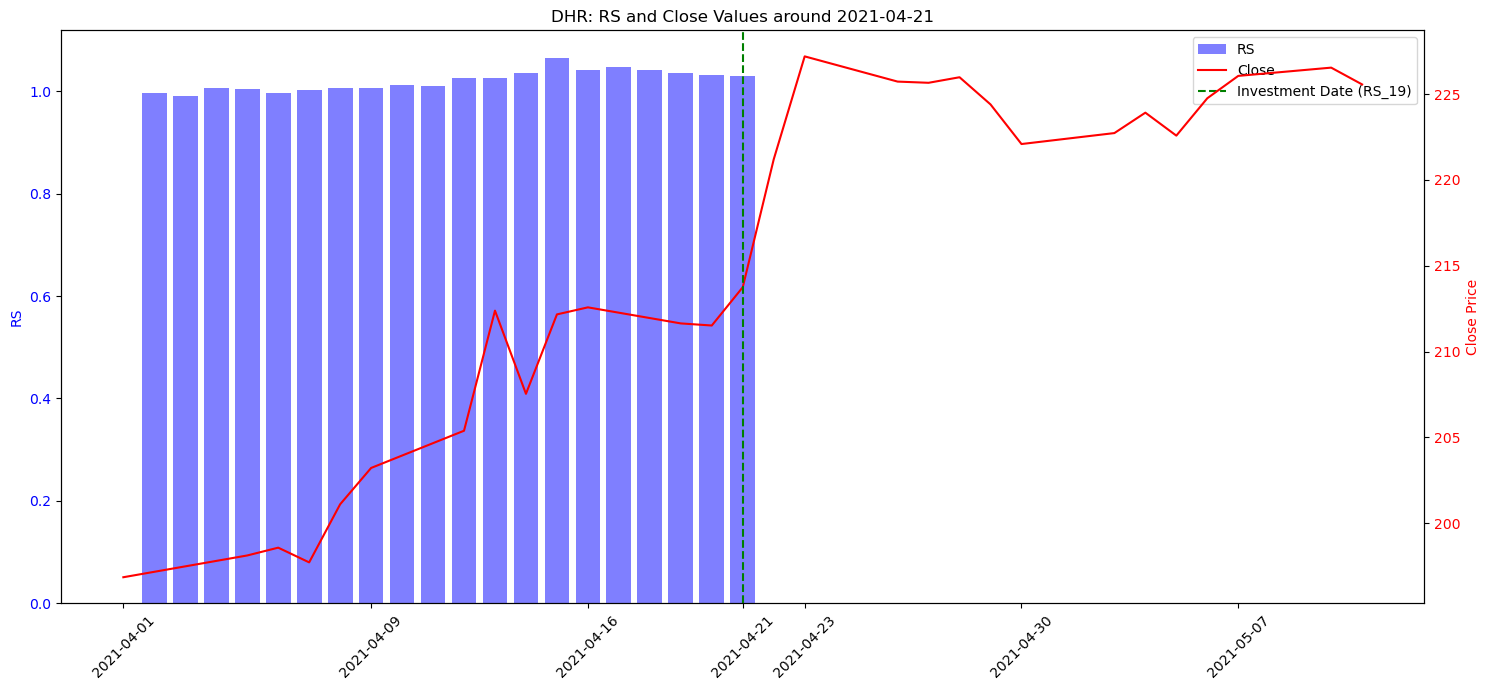

Close price on investment date: 213.7479553222656
Close price from the_row: 213.7479553222656
Close prices match: True


In [441]:
plot_rs_and_close(df, high_product['Date'].values[4300], high_product['Ticker'].values[4300],col_to_plot='RS')

Target date: 2021-04-26, Nearest date: 2021-04-26
Pct_Change_1: 0.0012524583564405
Investment date: 2021-04-26
Number of RS values: 20
Number of data points: 29


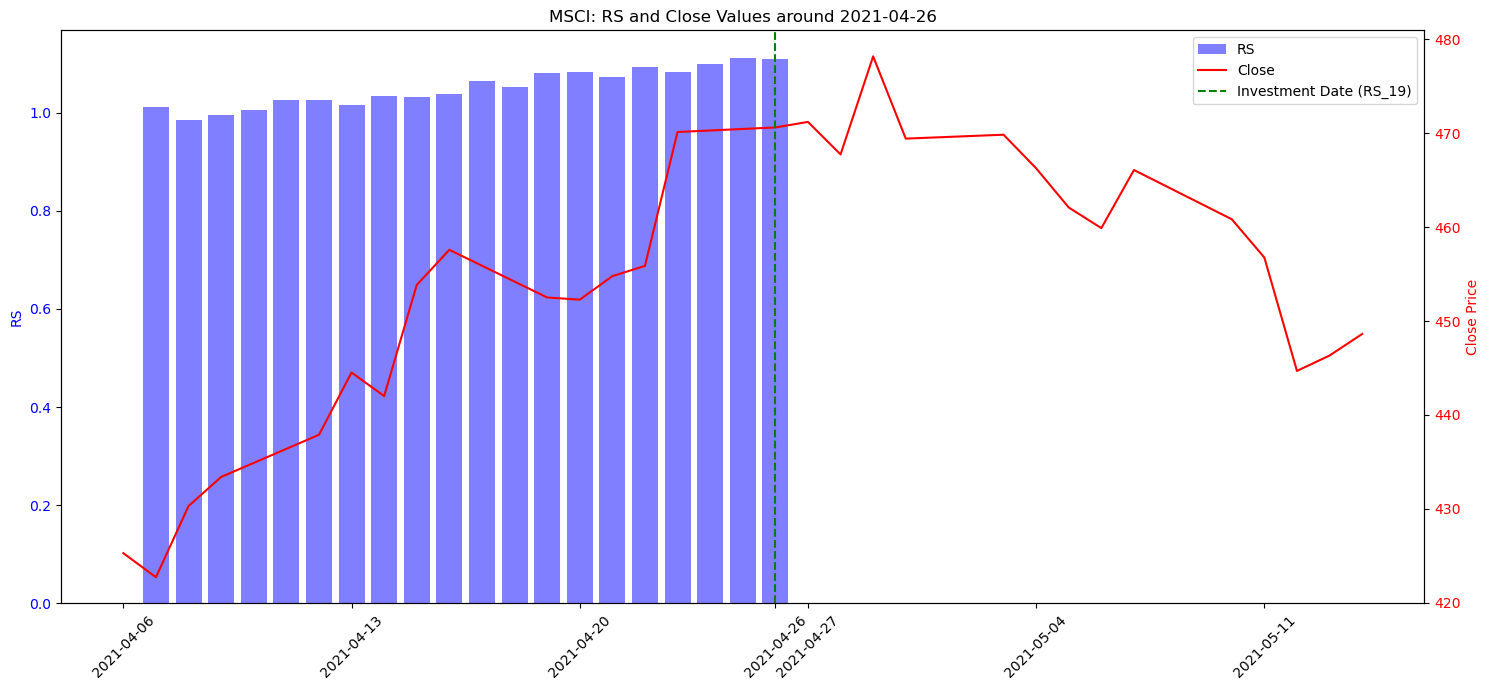

Close price on investment date: 470.607666015625
Close price from the_row: 470.607666015625
Close prices match: True


In [443]:
plot_rs_and_close(df, high_product['Date'].values[4600], high_product['Ticker'].values[4600],col_to_plot='RS')

Target date: 2021-04-06, Nearest date: 2021-04-06
Pct_Change_1: -0.0049971340290526
Investment date: 2021-04-06
Number of RS values: 20
Number of data points: 28


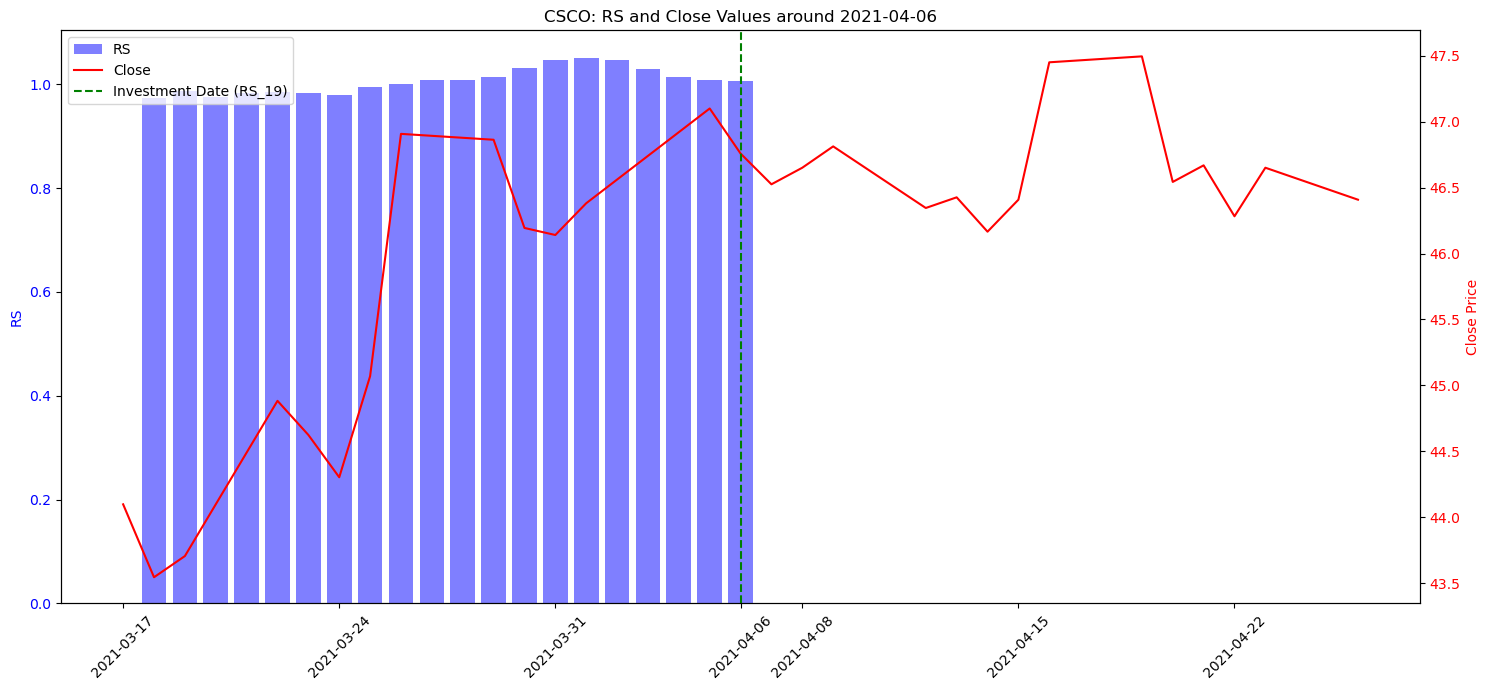

Close price on investment date: 46.75913238525391
Close price from the_row: 46.75913238525391
Close prices match: True


In [427]:
plot_rs_and_close(df, high_product['Date'].values[3300], high_product['Ticker'].values[3300],col_to_plot='RS')

Target date: 2021-04-05, Nearest date: 2021-04-05
Pct_Change_1: 0.0124701800640478
Investment date: 2021-04-05
Number of RS values: 20
Number of data points: 28


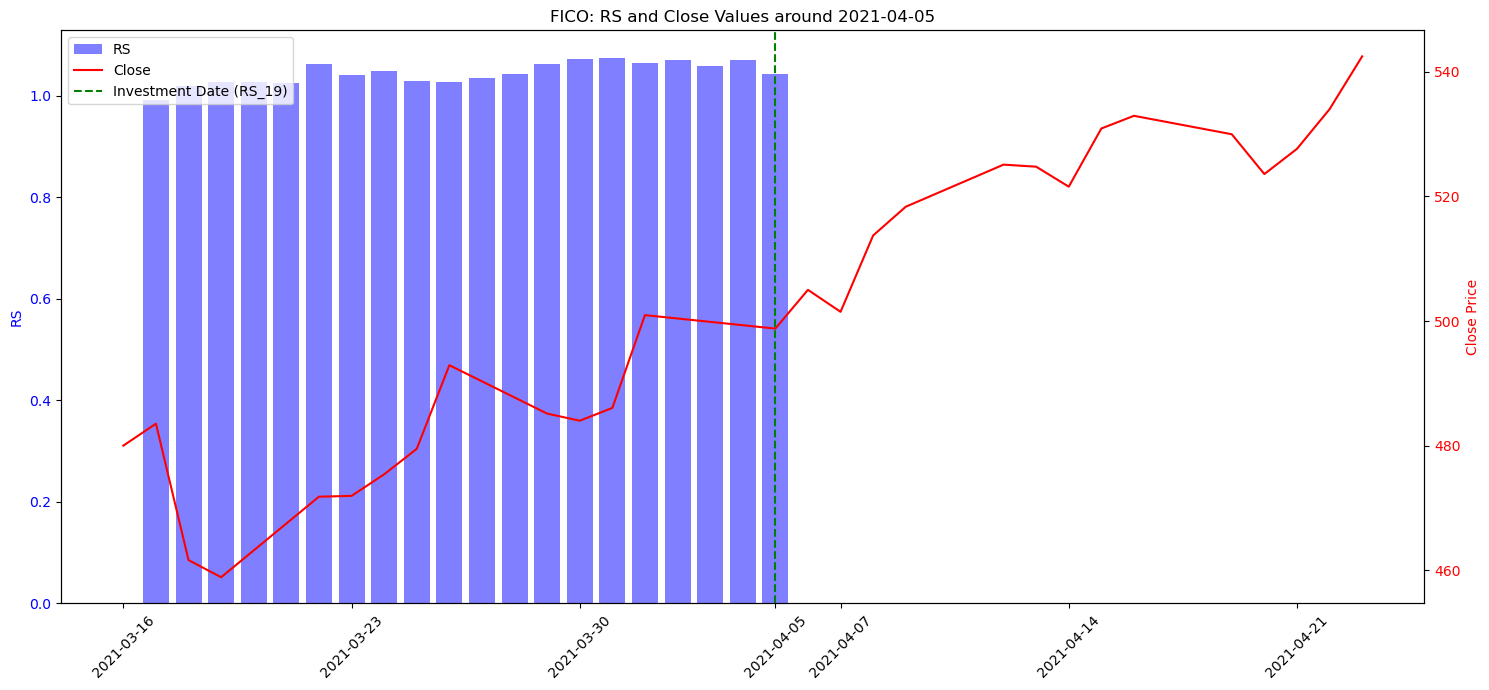

Close price on investment date: 498.7900085449219
Close price from the_row: 498.7900085449219
Close prices match: True


In [429]:
plot_rs_and_close(df, high_product['Date'].values[3200], high_product['Ticker'].values[3200],col_to_plot='RS')

Target date: 2021-04-01, Nearest date: 2021-04-01


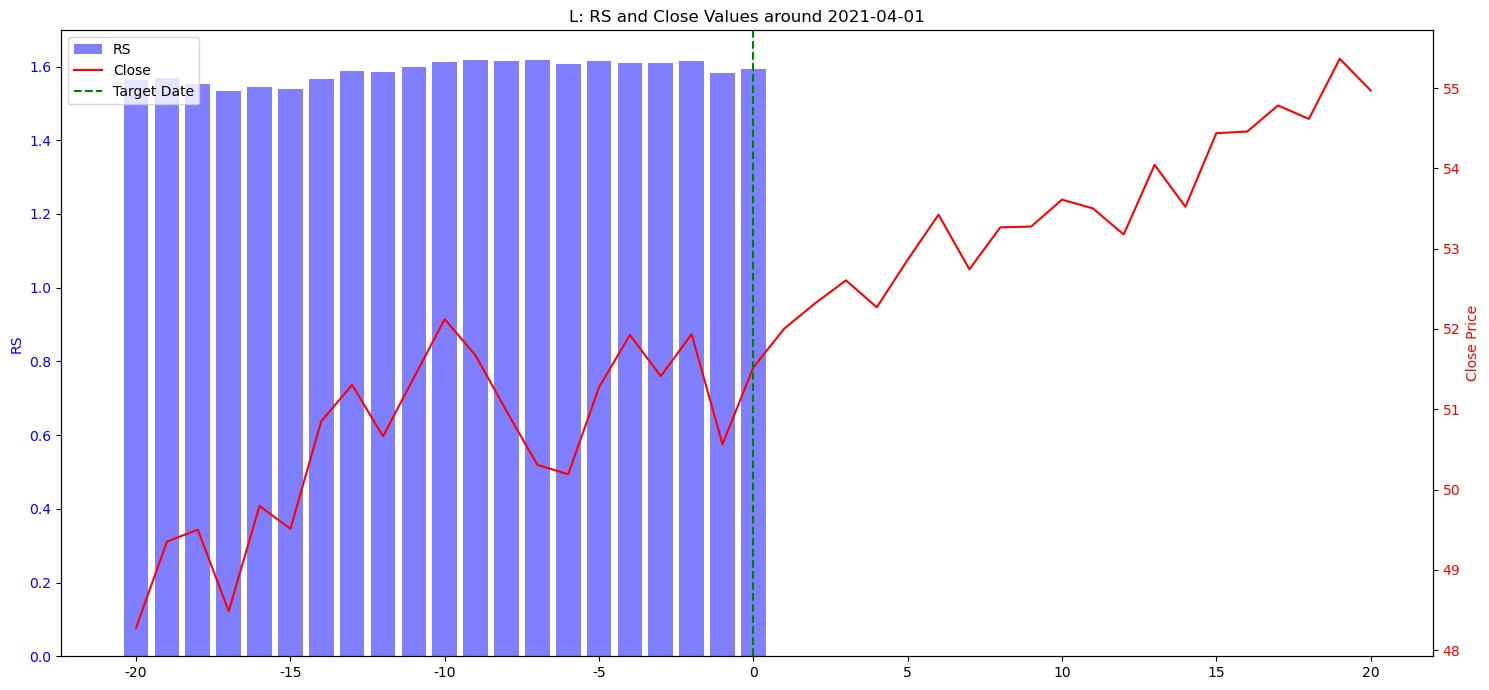

Number of data points plotted: 41
Date range plotted: 2021-03-04 to 2021-04-30
RS range: 1.5345475509889916 to 1.64284505751627
Close range: 48.2768783569336 to 55.36656188964844


In [221]:
plot_rs_and_close(df, high_product['Date'].values[3100], high_product['Ticker'].values[3100],col_to_plot='RS')

In [445]:
print('Average Percent Gain (1 day hold) for high product stocks',high_product['Pct_Change_1'].mean())
print('Average Percent Gain (1 day hold) for all stocks',df['Pct_Change_1'].mean())

Average Percent Gain (1 day hold) for high product stocks 0.0005760092726363449
Average Percent Gain (1 day hold) for all stocks 0.0004937599536376715


In [ ]:
# Low Product
**Compare to a few low product graphs**

**5 out of the 6 stocks plotted with high product went up the next day.  The average percent gain for product was not as high as for just slope.**

Target date: 2021-03-26, Nearest date: 2021-03-26
Pct_Change_1: -0.0156081498786621
Investment date: 2021-03-26
Number of RS values: 20
Number of data points: 28


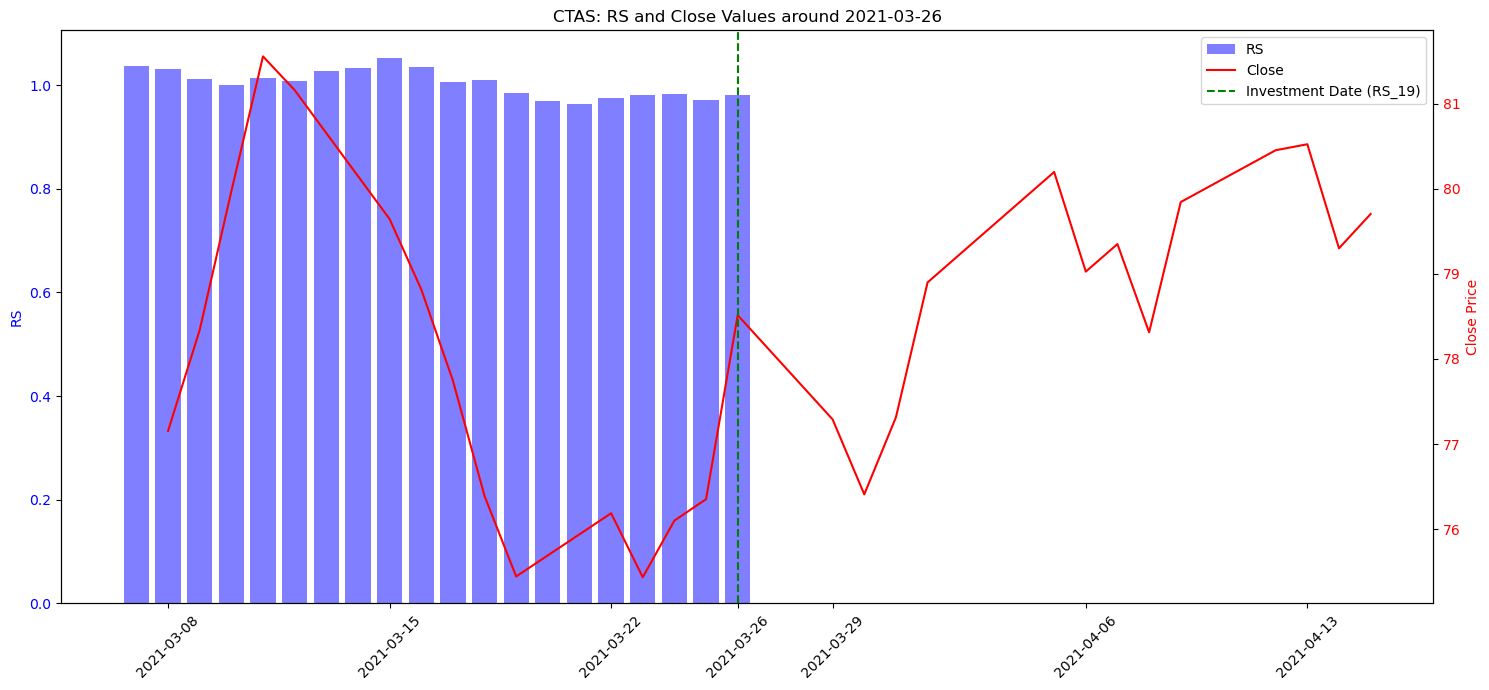

Close price on investment date: 78.51484680175781
Close price from the_row: 78.51484680175781
Close prices match: True


In [449]:
low_product=df[df['Product']<df['Product'].quantile(0.25)]
plot_rs_and_close(df, low_product['Date'].values[2200], low_product['Ticker'].values[2200],col_to_plot='RS')

Target date: 2021-03-29, Nearest date: 2021-03-29
Pct_Change_1: -0.011401244542086
Investment date: 2021-03-29
Number of RS values: 20
Number of data points: 28


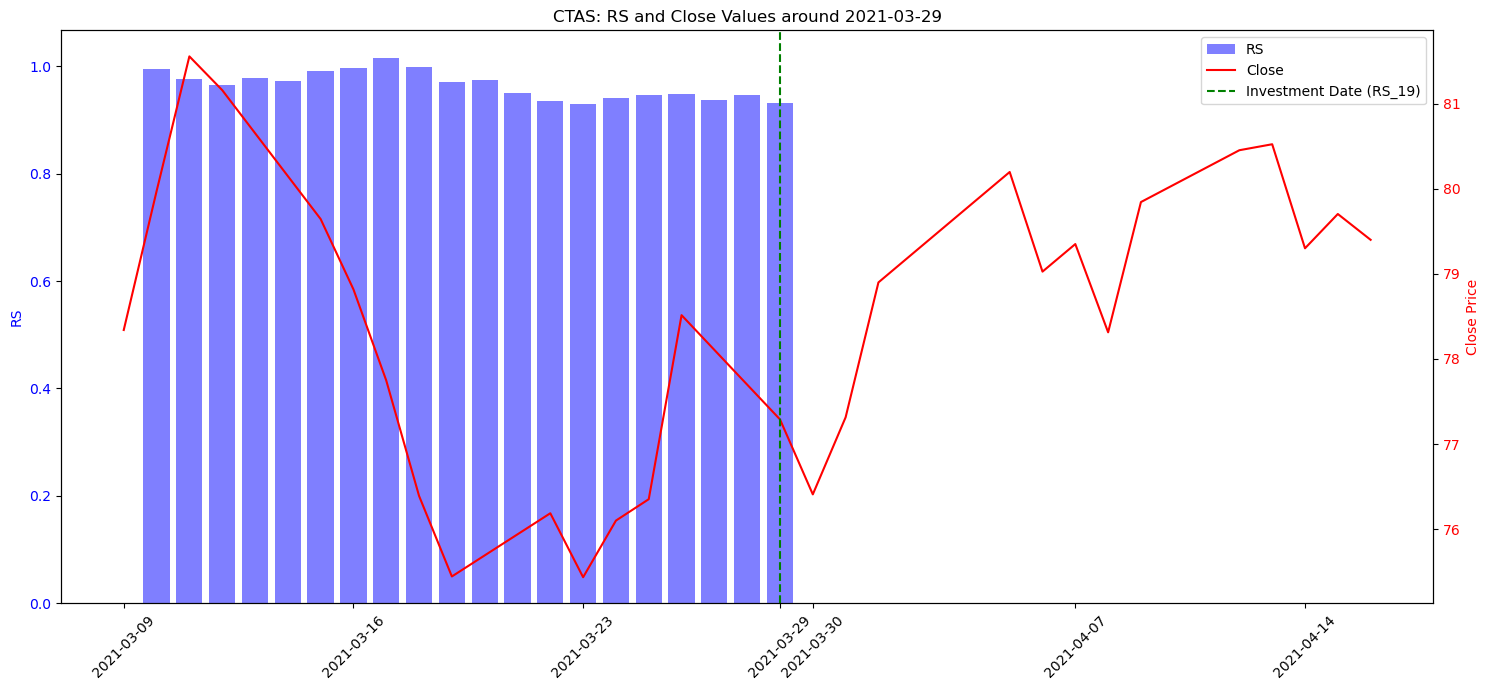

Close price on investment date: 77.28937530517578
Close price from the_row: 77.28937530517578
Close prices match: True


In [451]:
plot_rs_and_close(df, low_product['Date'].values[2300], low_product['Ticker'].values[2300],col_to_plot='RS')

Target date: 2021-03-25, Nearest date: 2021-03-25
Pct_Change_1: 0.0130388825442679
Investment date: 2021-03-25
Number of RS values: 20
Number of data points: 28


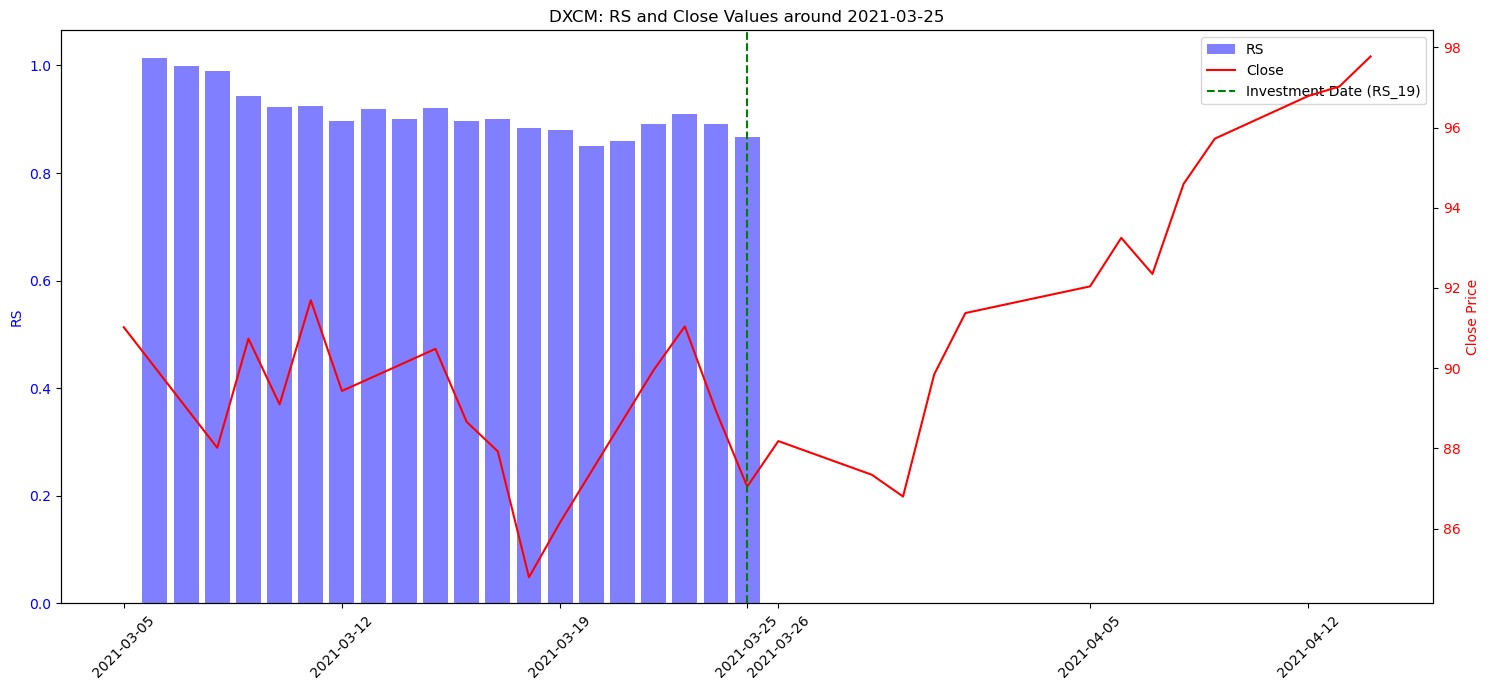

Close price on investment date: 87.04750061035156
Close price from the_row: 87.04750061035156
Close prices match: True


In [453]:
plot_rs_and_close(df, low_product['Date'].values[2100], low_product['Ticker'].values[2100],col_to_plot='RS')

Target date: 2021-03-15, Nearest date: 2021-03-15
Pct_Change_1: -0.0201143837941563
Investment date: 2021-03-15
Number of RS values: 20
Number of data points: 23


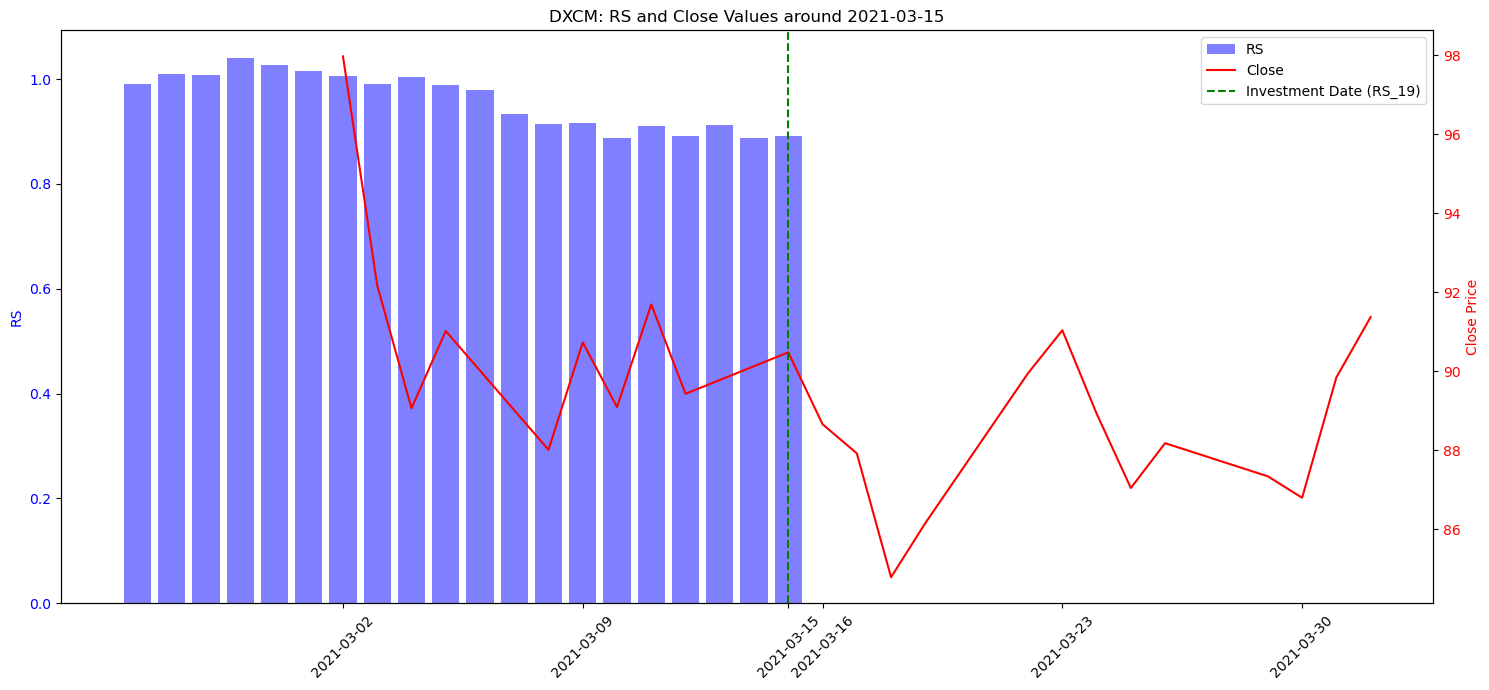

Close price on investment date: 90.48249816894533
Close price from the_row: 90.48249816894533
Close prices match: True


In [455]:
plot_rs_and_close(df, low_product['Date'].values[1200], low_product['Ticker'].values[1200],col_to_plot='RS')

**3 out of the 4 graphs show a decrease in the low_product data.**

**The Graphs seem to be supportive of a short-term strategy that uses the magnitude of the Product metric to rank stocks**

# TTM
### Look for relationships between the TTM and percent gains in the short (but longer)-term.
**Typically investors use the ttm_weekly bars and the daily bars in conjunction with each other.  One might expect that if these values are increasing the probability that the stock will rise is higher**

**The variable set below would indicate very high strength.  The TTM_Weekly has been going up for the past 3 weeks and the TTM_Daily is going up for the past 4 days**

In [3]:
df['TTM_daily_weekly_going_up'] = (
    (df['TTM_Weekly_change_lag1'] > 0) &
    (df['TTM_Weekly_change_lag2'] > 0) &
    (df['TTM_Weekly_change_lag3'] > 0) &
    (df['TTM_change_lag0'] > 0) &
    (df['TTM_change_lag1'] > 0) &
    (df['TTM_change_lag2'] > 0) &
    (df['TTM_change_lag3'] > 0)
)

In [5]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """
    Calculate Cramer's V statistic for categorical-categorical association.
    
    Parameters:
    x, y: categorical variables
    
    Returns:
    float: Cramer's V
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    
    return np.sqrt(chi2 / (n * min_dim))
    
C=cramers_v(df['TTM_daily_weekly_going_up'],df['Invest_20'])
print('Cramers V score for TTM_Consistently Increasing Vs Positive Percent Gains (hold 20 days)')
print(C)

Cramers V score for TTM_Consistently Increasing Vs Positive Percent Gains (hold 20 days)
0.006457988220360294


**We see another lack of association between positive percent gains and increasing ttm_values**

**Set the variable to be True if the previous weekly and daily ttm value was positive. Check association with 1 day positive gains.**

In [7]:
df['TTM_daily_weekly_going_up'] = (
    (df['TTM_Weekly_change_lag1'] > 0) &
    (df['TTM_change_lag0'] > 0))
C=cramers_v(df['TTM_daily_weekly_going_up'],df['Invest_1'])
print('Cramers V score for most recent TTM Daily and TTM weekly increasing')
print(C)

Cramers V score for most recent TTM Daily and TTM weekly increasing
0.0007396030401364589


# Add the condition that the raw daily TTM value is in its upper quartile.

In [17]:
#add the raw value
df['TTM_daily_weekly_going_up'] = (
    (df['TTM_Weekly_change_lag1'] > 0) &
    (df['TTM_change_lag0'] > 0)&
(df['TTM_raw_lag0']>df['TTM_raw_lag0'].quantile(0.75))
)
C=cramers_v(df['TTM_daily_weekly_going_up'],df['Invest_20'])
print('Cramers V score for most recent TTM Daily and TTM weekly increasing and raw value is high')
print(C)

Cramers V score for most recent TTM Daily and TTM weekly increasing and raw value is high
0.013558800196052212


#### Adding th raw value does increase the cramers v score, although it is still pretty low

In [11]:

print('Average Percent Gain of raw_high/daily_increasing/weekly_increasing',df[df['TTM_daily_weekly_going_up']]['Pct_Change_20'].mean())
print()
print('Average Percent Gain of Entire Dataset',df['Pct_Change_20'].mean())

Average Percent Gain of raw_high/daily_increasing/weekly_increasing 0.002113400191940356

Average Percent Gain of Entire Dataset 0.009816421727241339


In [32]:
df['TTM_raw_lag0'].describe()

count    388763.000000
mean          0.027323
std           0.297423
min          -1.000000
25%          -0.147244
50%           0.032681
75%           0.212506
max           1.000000
Name: TTM_raw_lag0, dtype: float64

**These TTM Values Frequently show up in Permutation Feature Importance Analysis as being important. The above analysis suggests a lack of association. Let look at some graphs**

40621
Percent Gain 2.1854630861655298


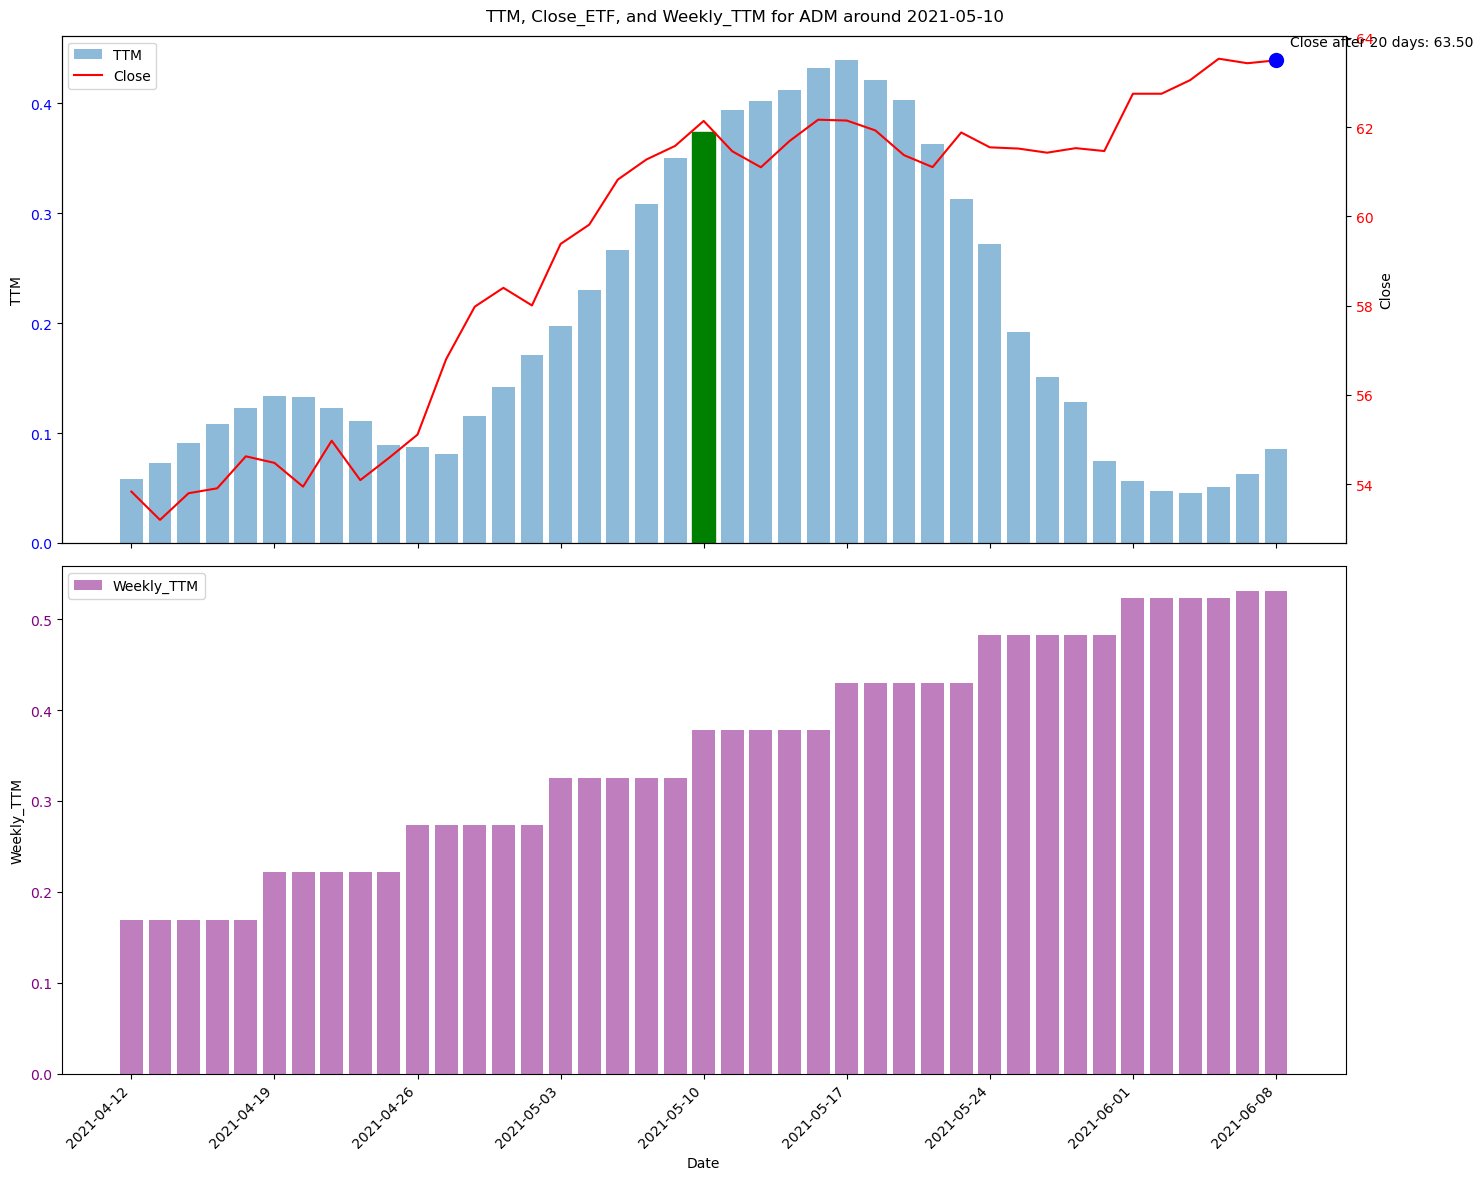

In [13]:
import matplotlib.pyplot as plt
import stock_project_functions_SAVE as spf
import model_functions_SAVE as mf
test=df[df['TTM_daily_weekly_going_up']]
check=df[df['Ticker']==test['Ticker'].values[4000]]
print(len(test))
mf.plot_ttm_and_close(check,test['Ticker'].values[4000], test['Date'].values[4000])

0.0252312653593476


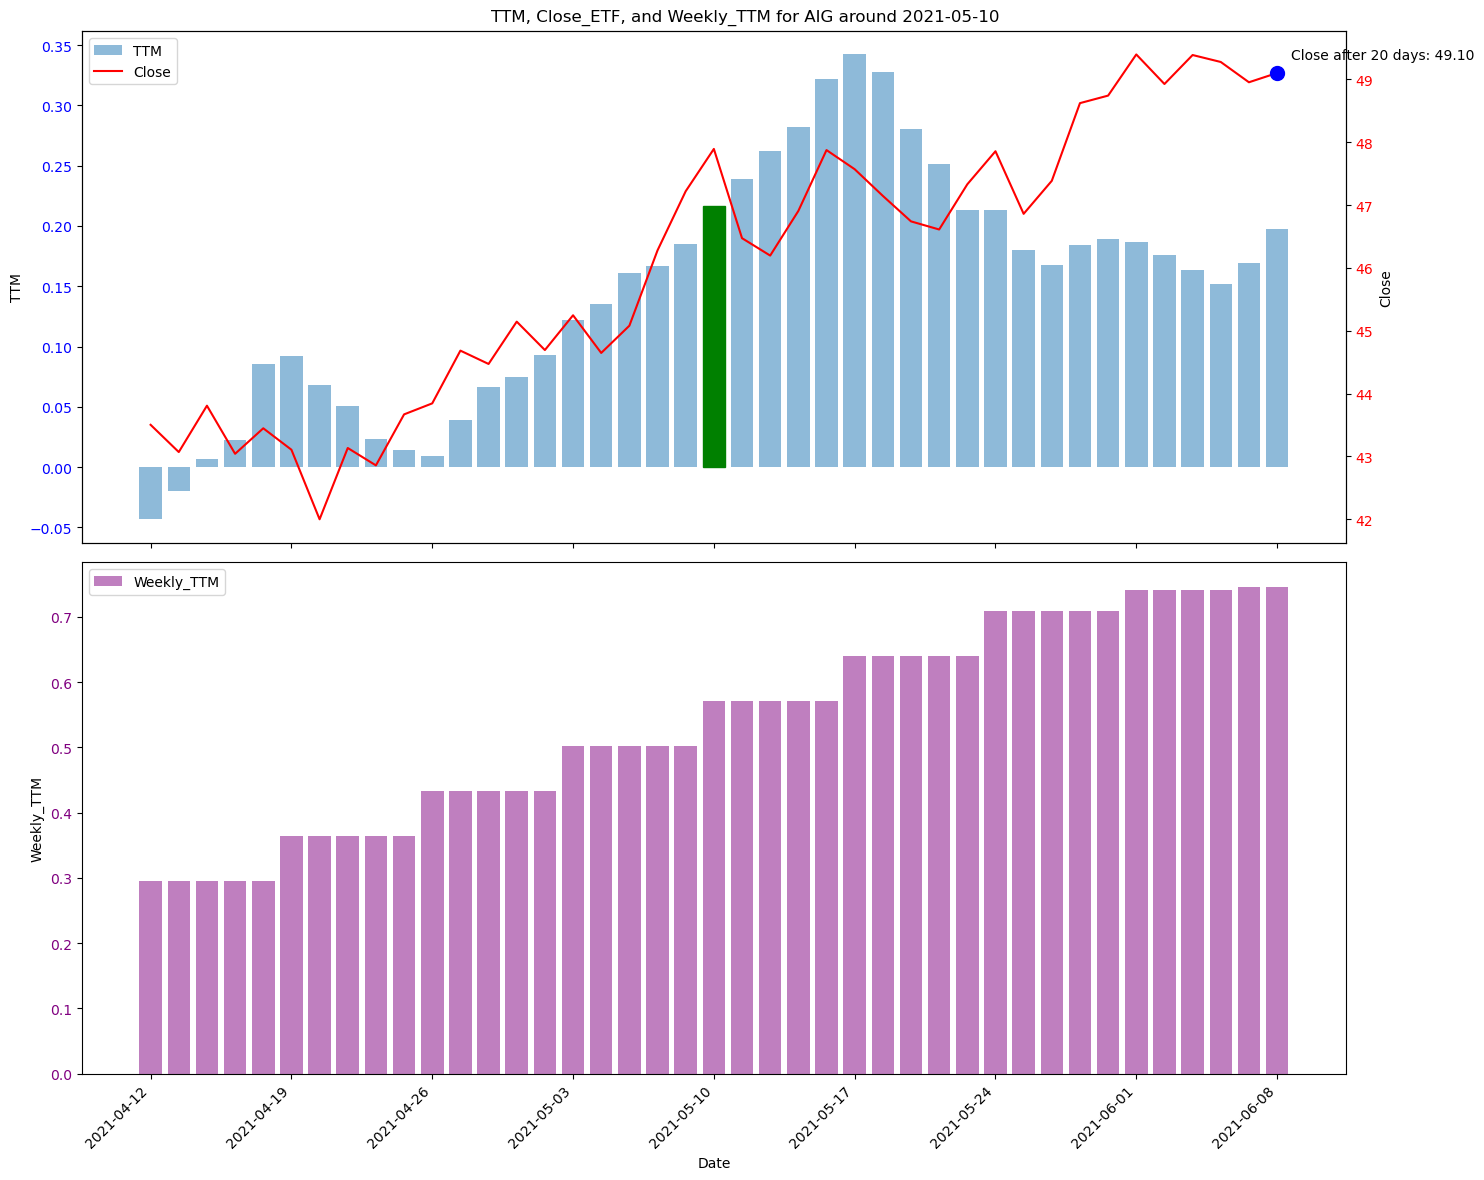

In [40]:
test=df[df['TTM_daily_weekly_going_up']]
check=df[df['Ticker']==test['Ticker'].values[4001]]

mf.plot_ttm_and_close(check,test['Ticker'].values[4001], test['Date'].values[4001])

-0.0418935120332159


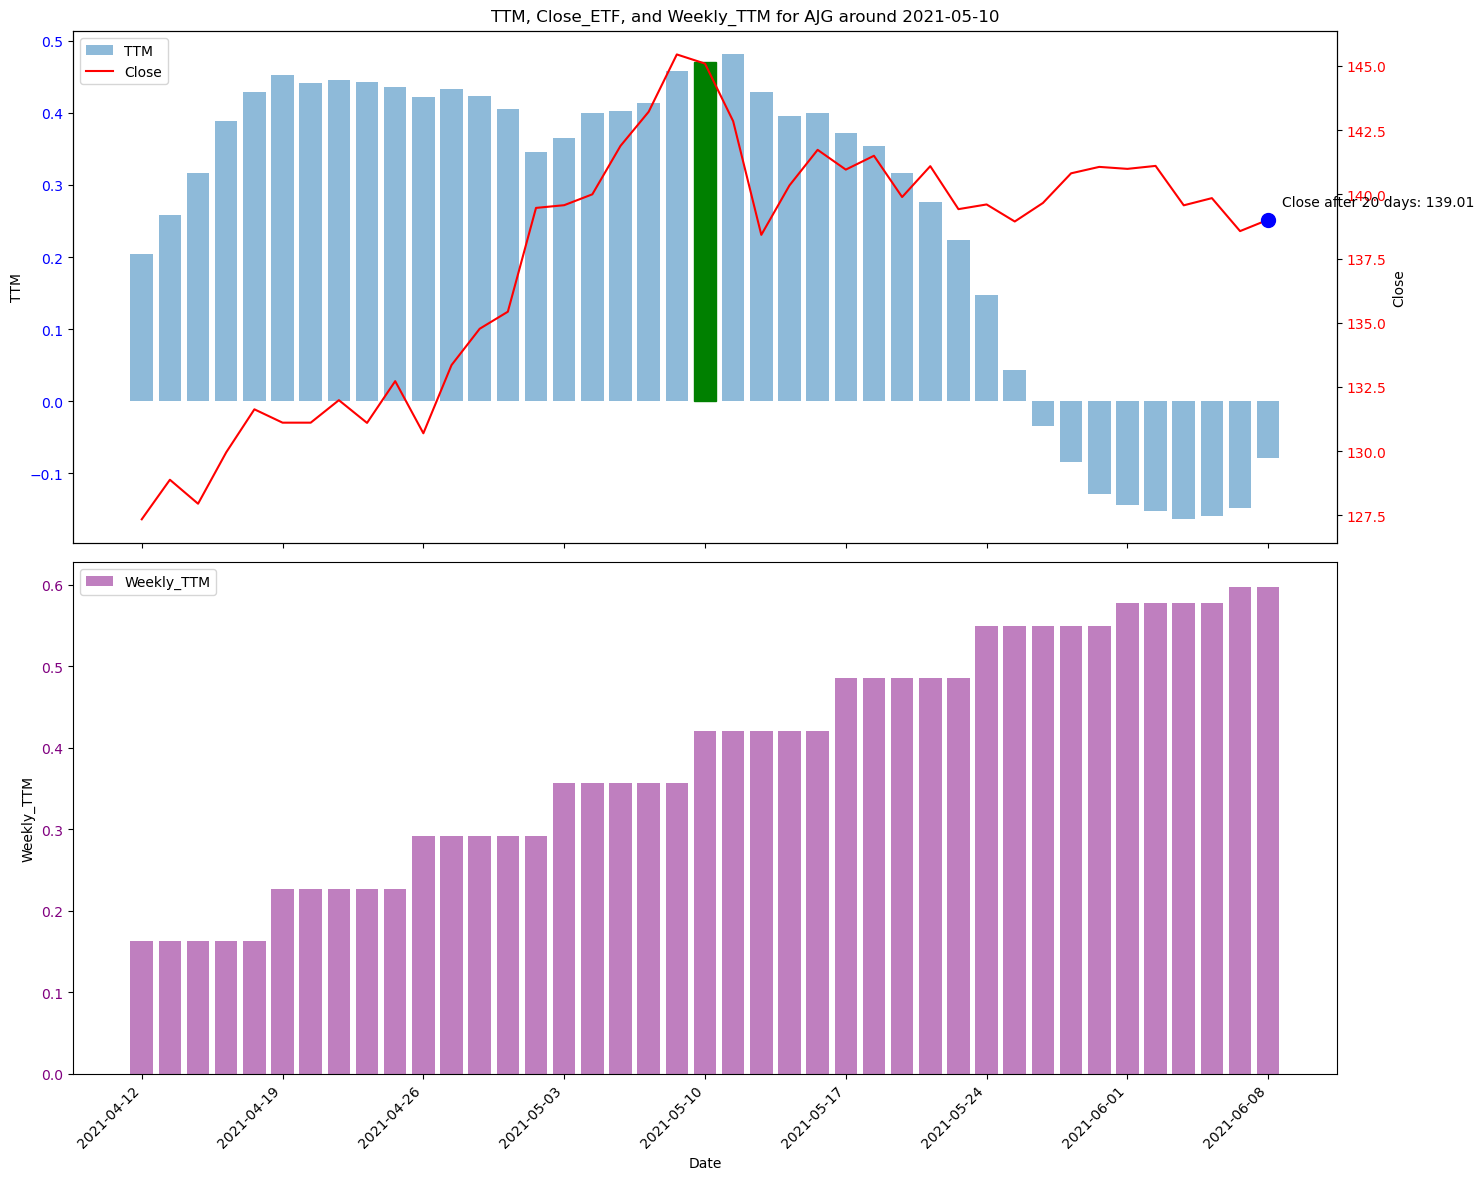

In [42]:
check=df[df['Ticker']==test['Ticker'].values[4002]]
mf.plot_ttm_and_close(check,test['Ticker'].values[4002], test['Date'].values[4002])

0.0622714918311021


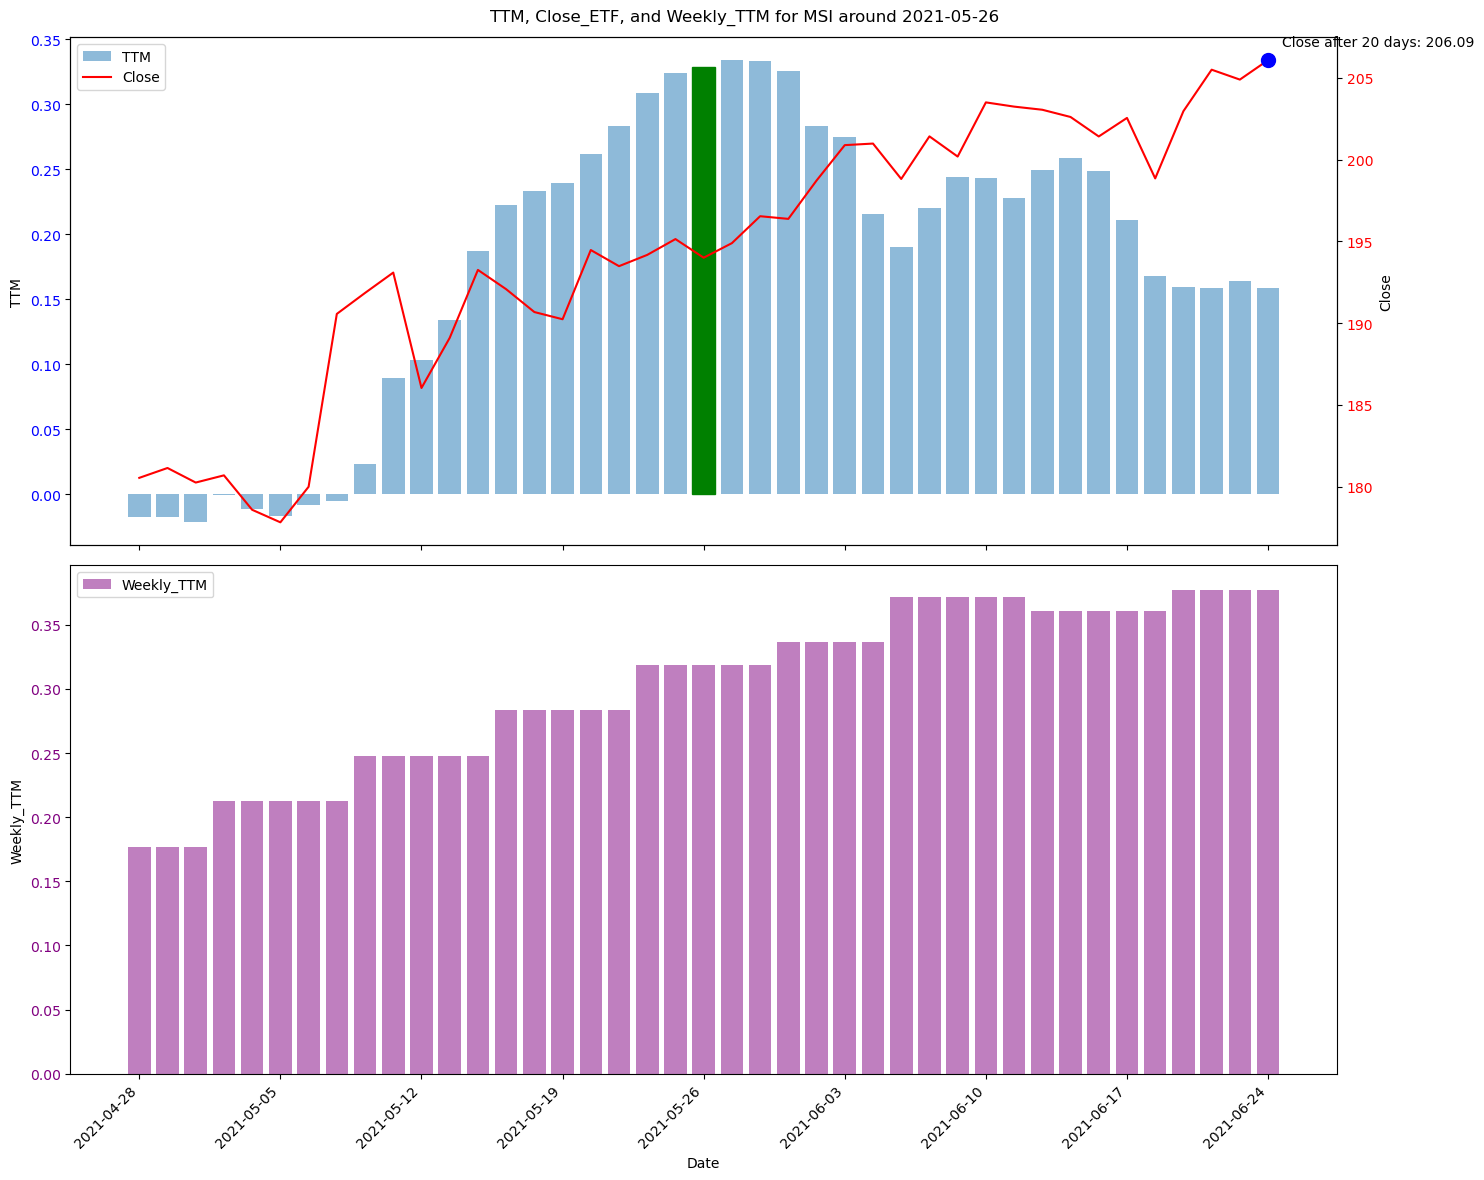

In [44]:
check=df[df['Ticker']==test['Ticker'].values[4602]]
mf.plot_ttm_and_close(check,test['Ticker'].values[4602], test['Date'].values[4602])

0.01936214414052


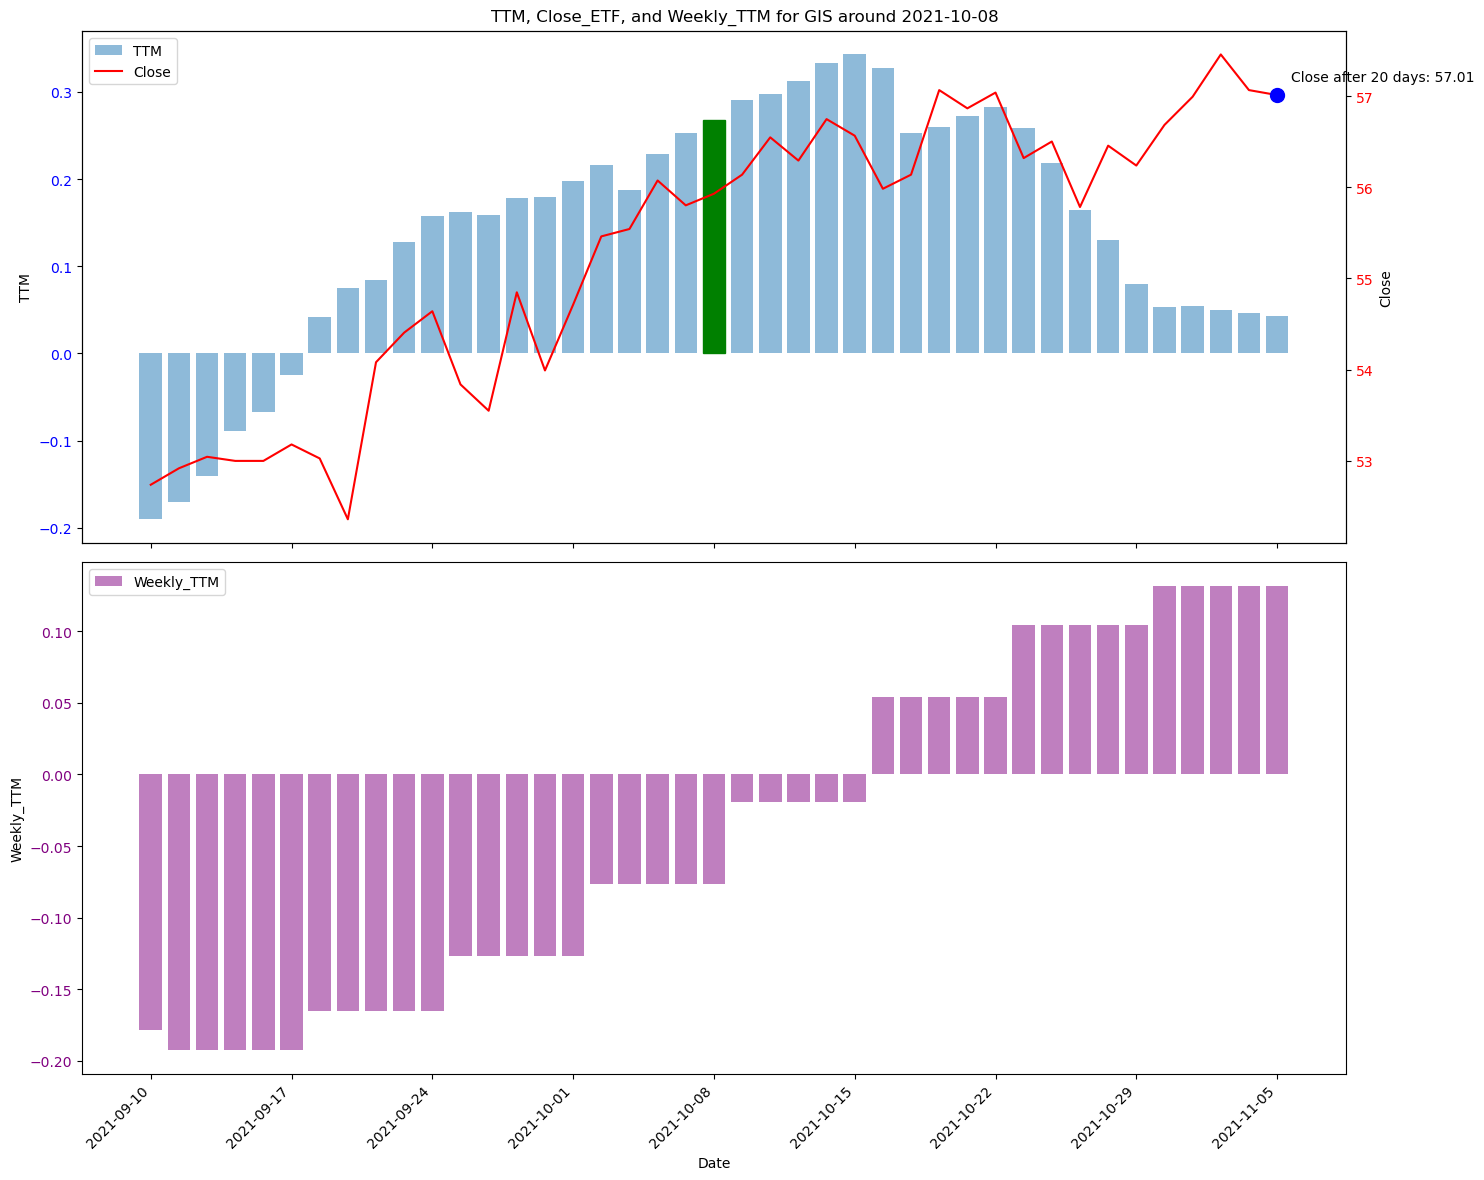

In [46]:
check=df[df['Ticker']==test['Ticker'].values[7602]]
mf.plot_ttm_and_close(check,test['Ticker'].values[7602], test['Date'].values[7602])

0.0487371523980085


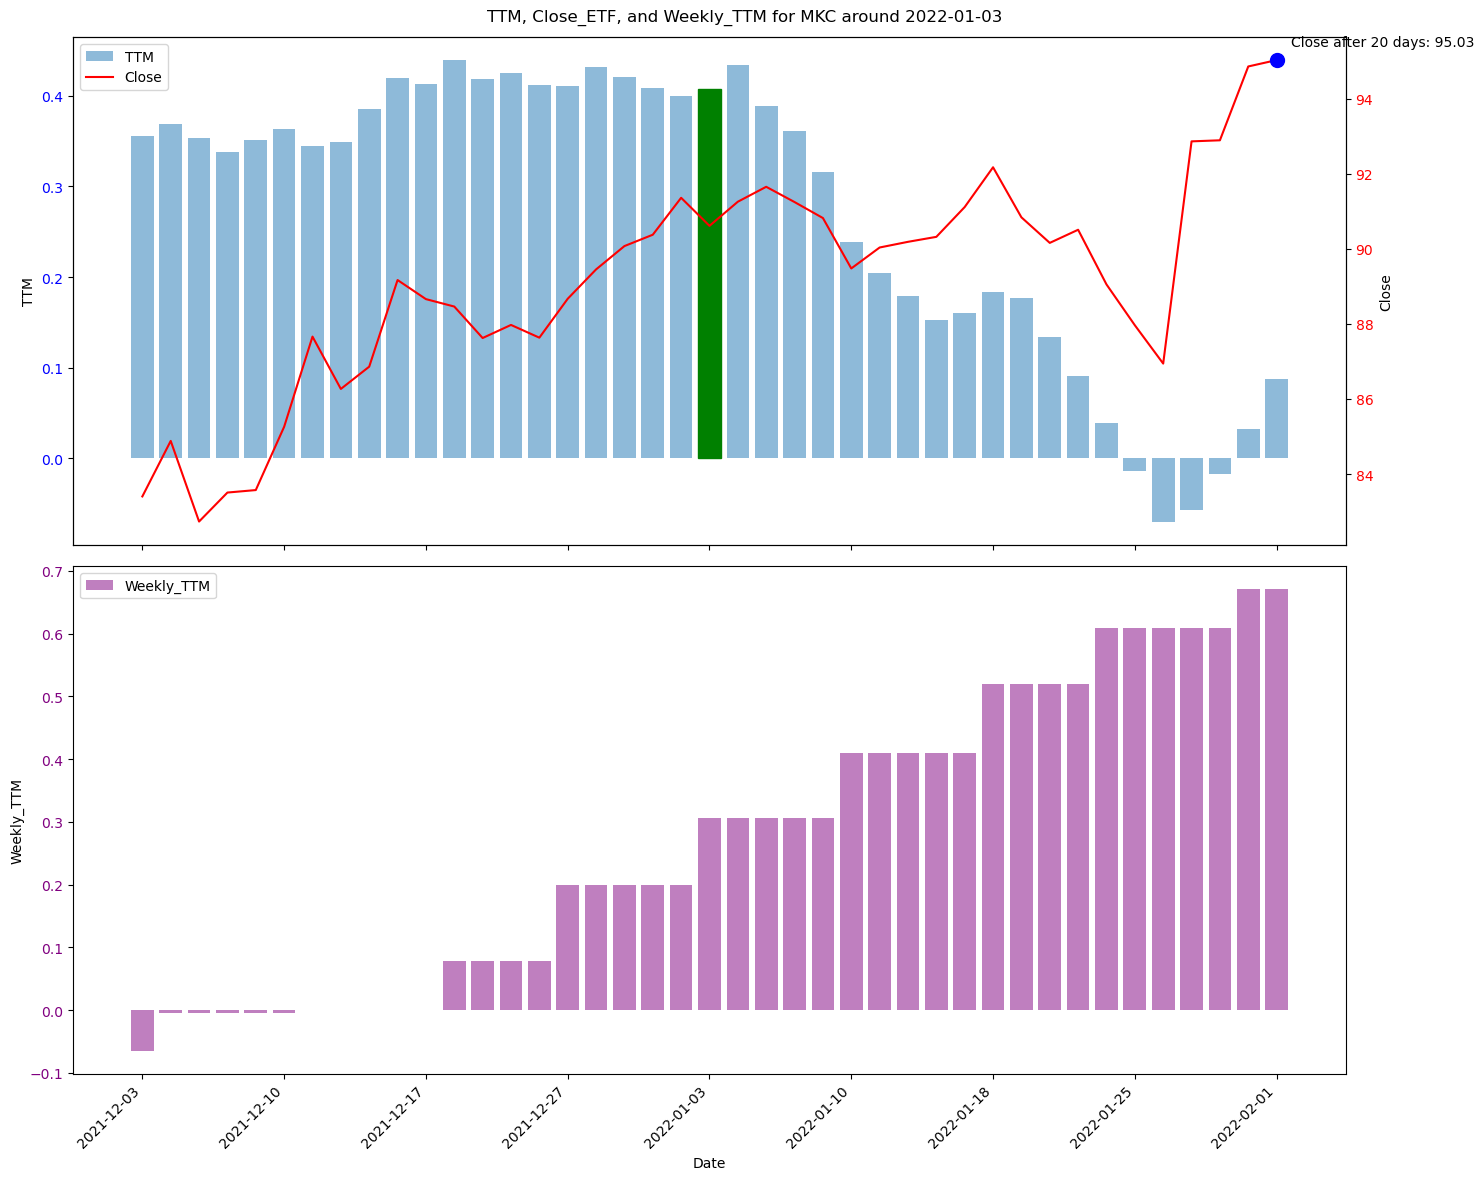

In [48]:
check=df[df['Ticker']==test['Ticker'].values[10602]]
mf.plot_ttm_and_close(check,test['Ticker'].values[10602], test['Date'].values[10602])

##### **The Graphs do point to a relationship between these values and the percent change.  5 out of 6 times when the TTM_Weekly was increasing, The TTM_Daily was also increasing and the Daily_Raw value was high the stock price had risen 20 days later.**

# Add condition that Squeeze is On

Percent Gain 1.68750718892472


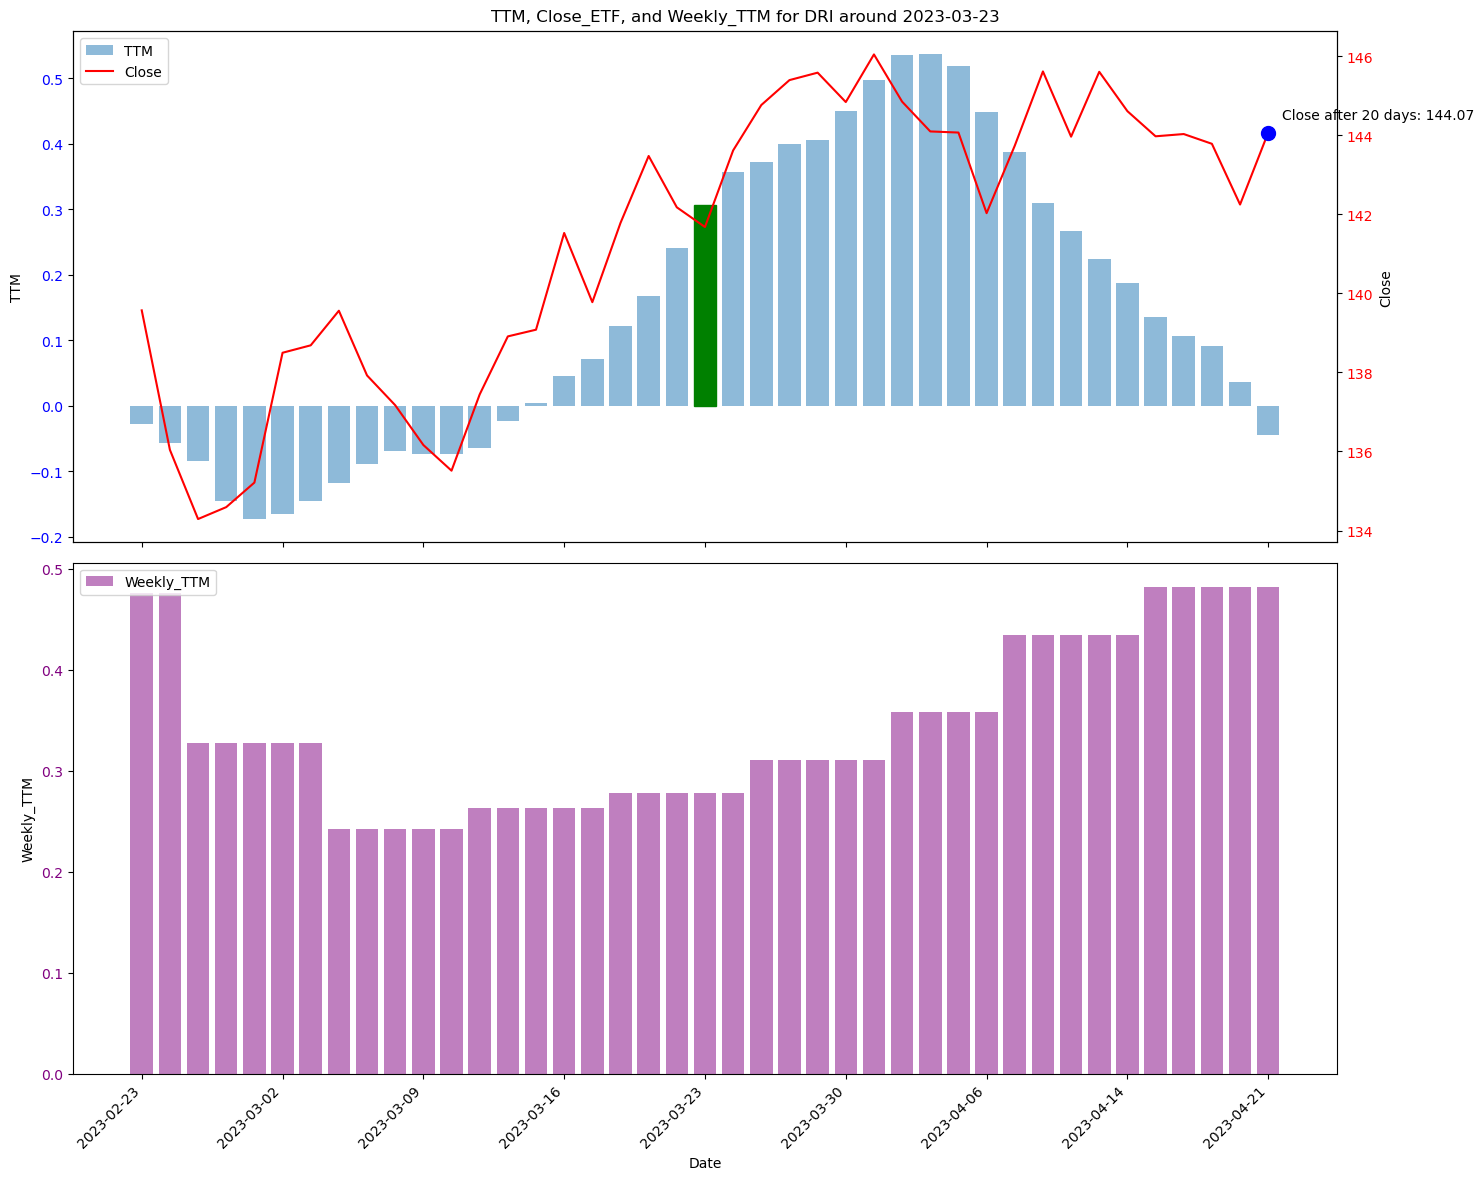

In [19]:
squeeze_on=test[test['Squeeze_On']]
squeeze_off=test[~test['Squeeze_On']]
check=df[df['Ticker']==squeeze_on['Ticker'].values[1102]]

mf.plot_ttm_and_close(check,squeeze_on['Ticker'].values[1102], squeeze_on['Date'].values[1102])

-0.0634134480791292


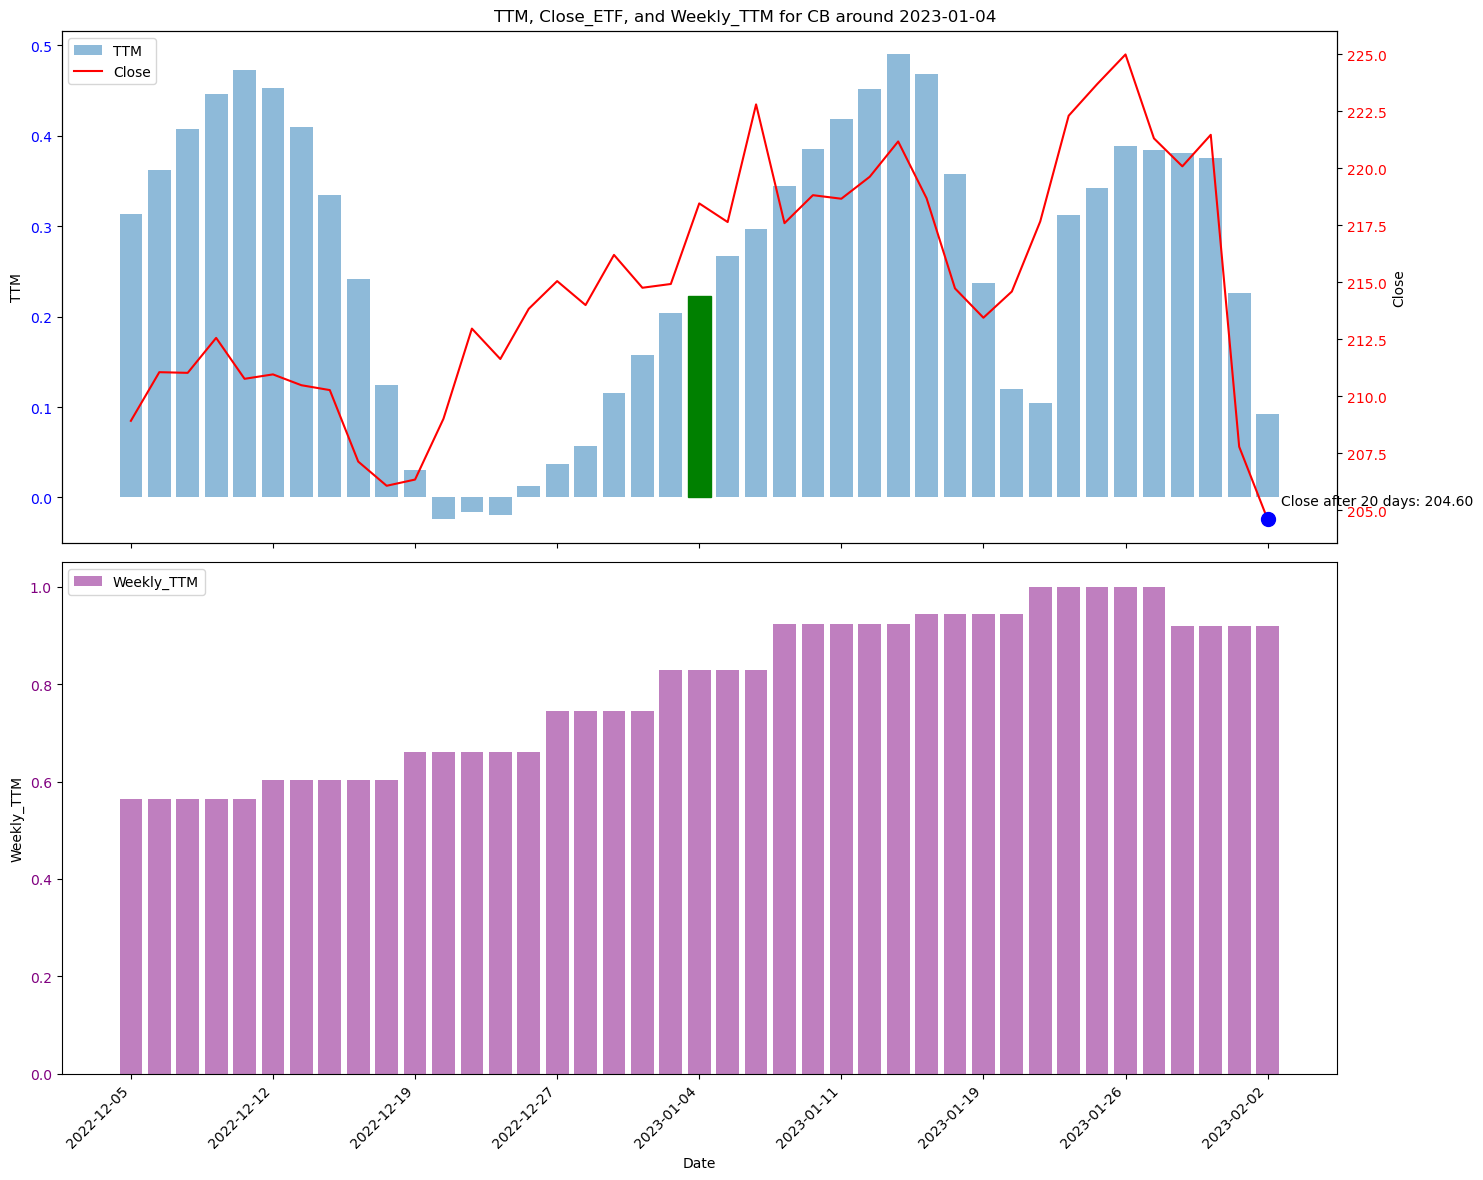

In [55]:
check=df[df['Ticker']==squeeze_on['Ticker'].values[1002]]

mf.plot_ttm_and_close(check,squeeze_on['Ticker'].values[1002], squeeze_on['Date'].values[1002])

0.0429990139286087


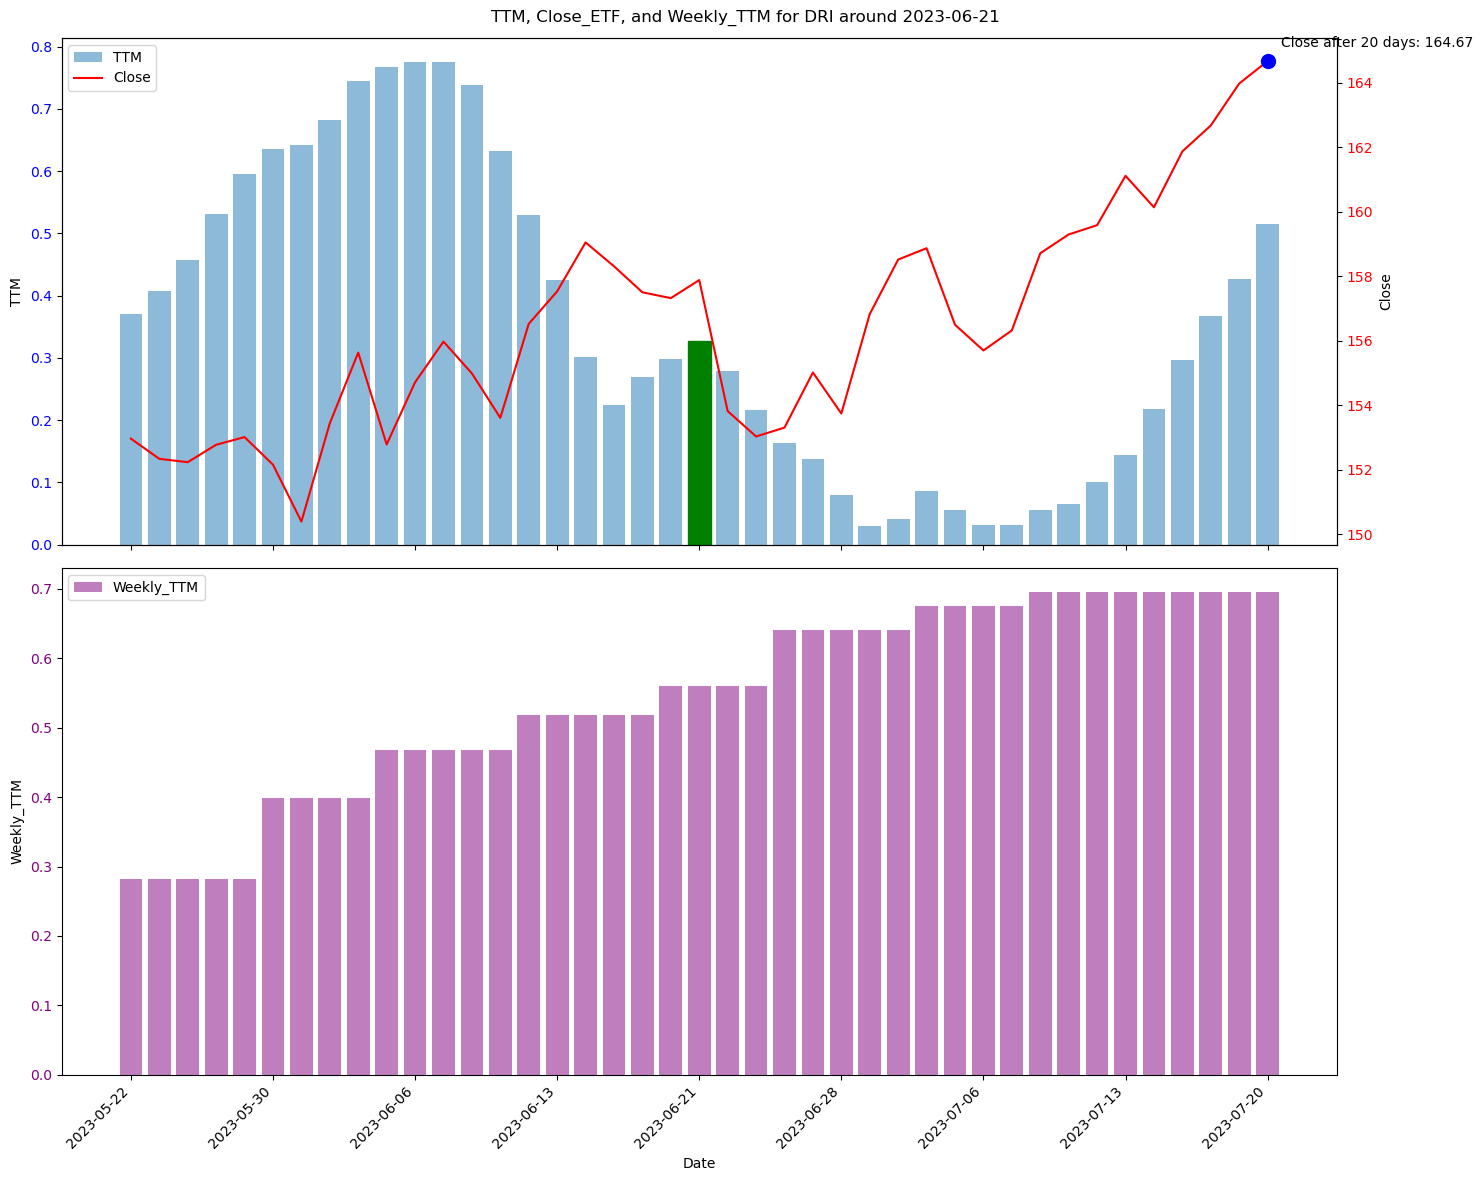

In [57]:
check=df[df['Ticker']==squeeze_on['Ticker'].values[1200]]

mf.plot_ttm_and_close(check,squeeze_on['Ticker'].values[1200], squeeze_on['Date'].values[1200])

0.004471385676858


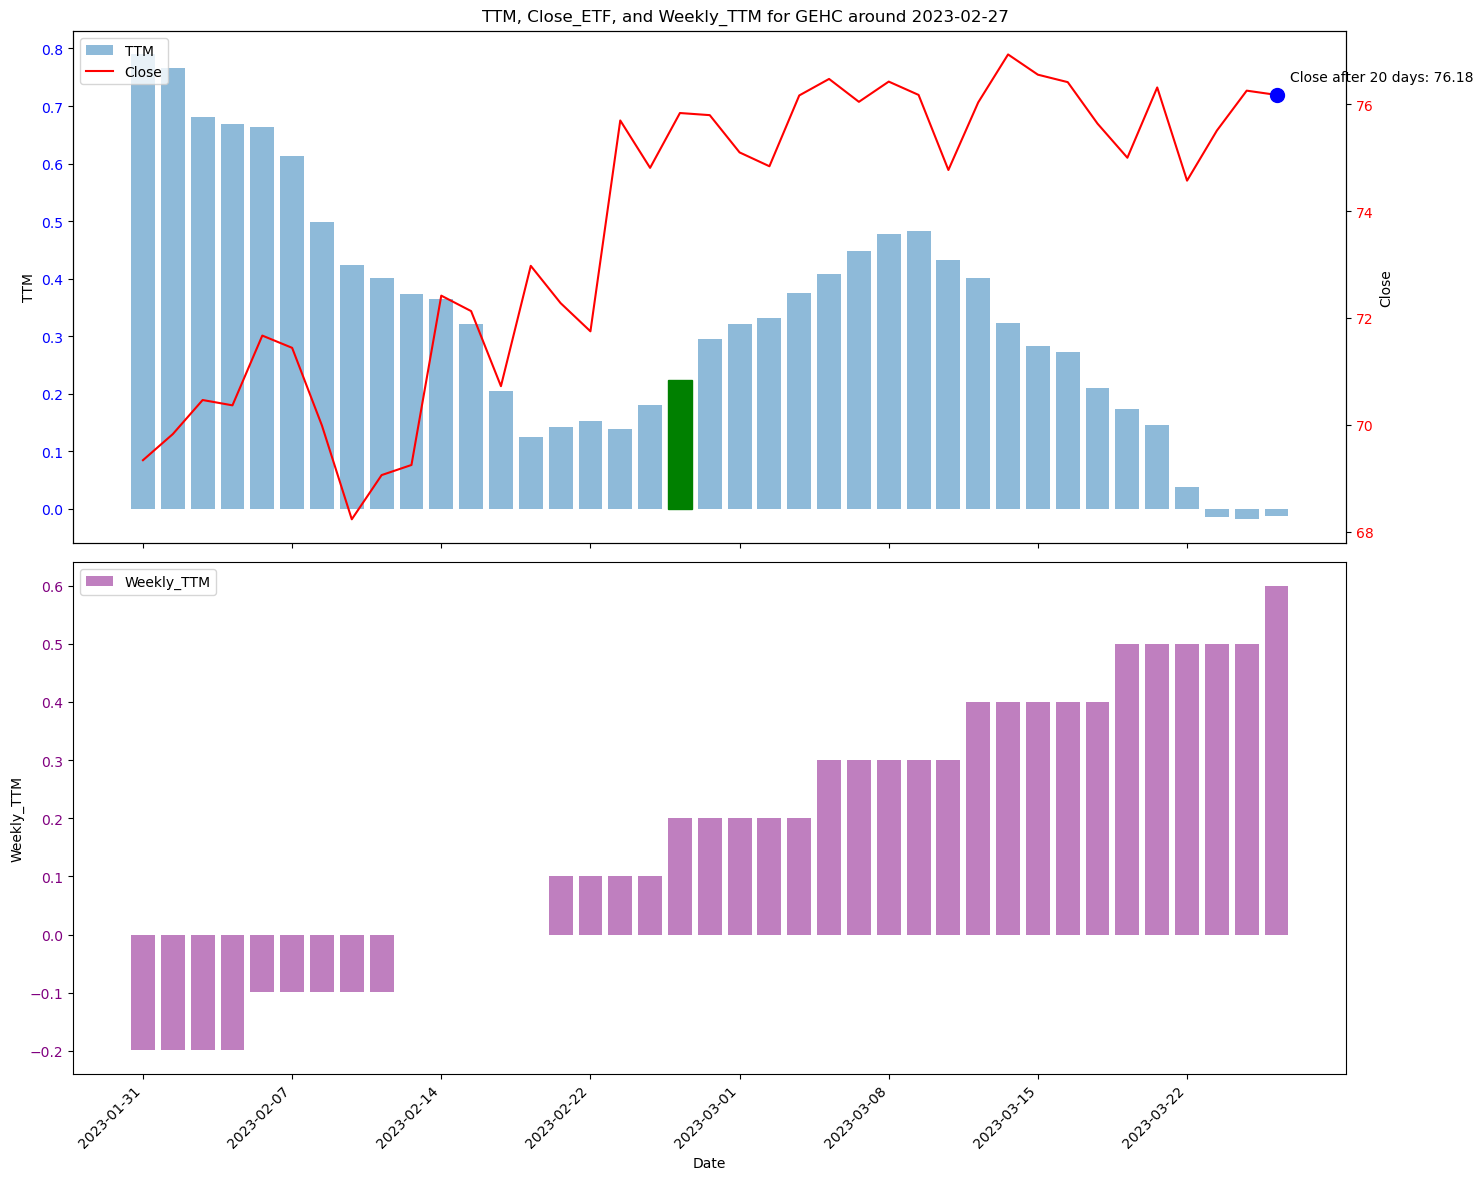

In [59]:
check=df[df['Ticker']==squeeze_on['Ticker'].values[1100]]

mf.plot_ttm_and_close(check,squeeze_on['Ticker'].values[1100], squeeze_on['Date'].values[1100])

0.0343465162557965


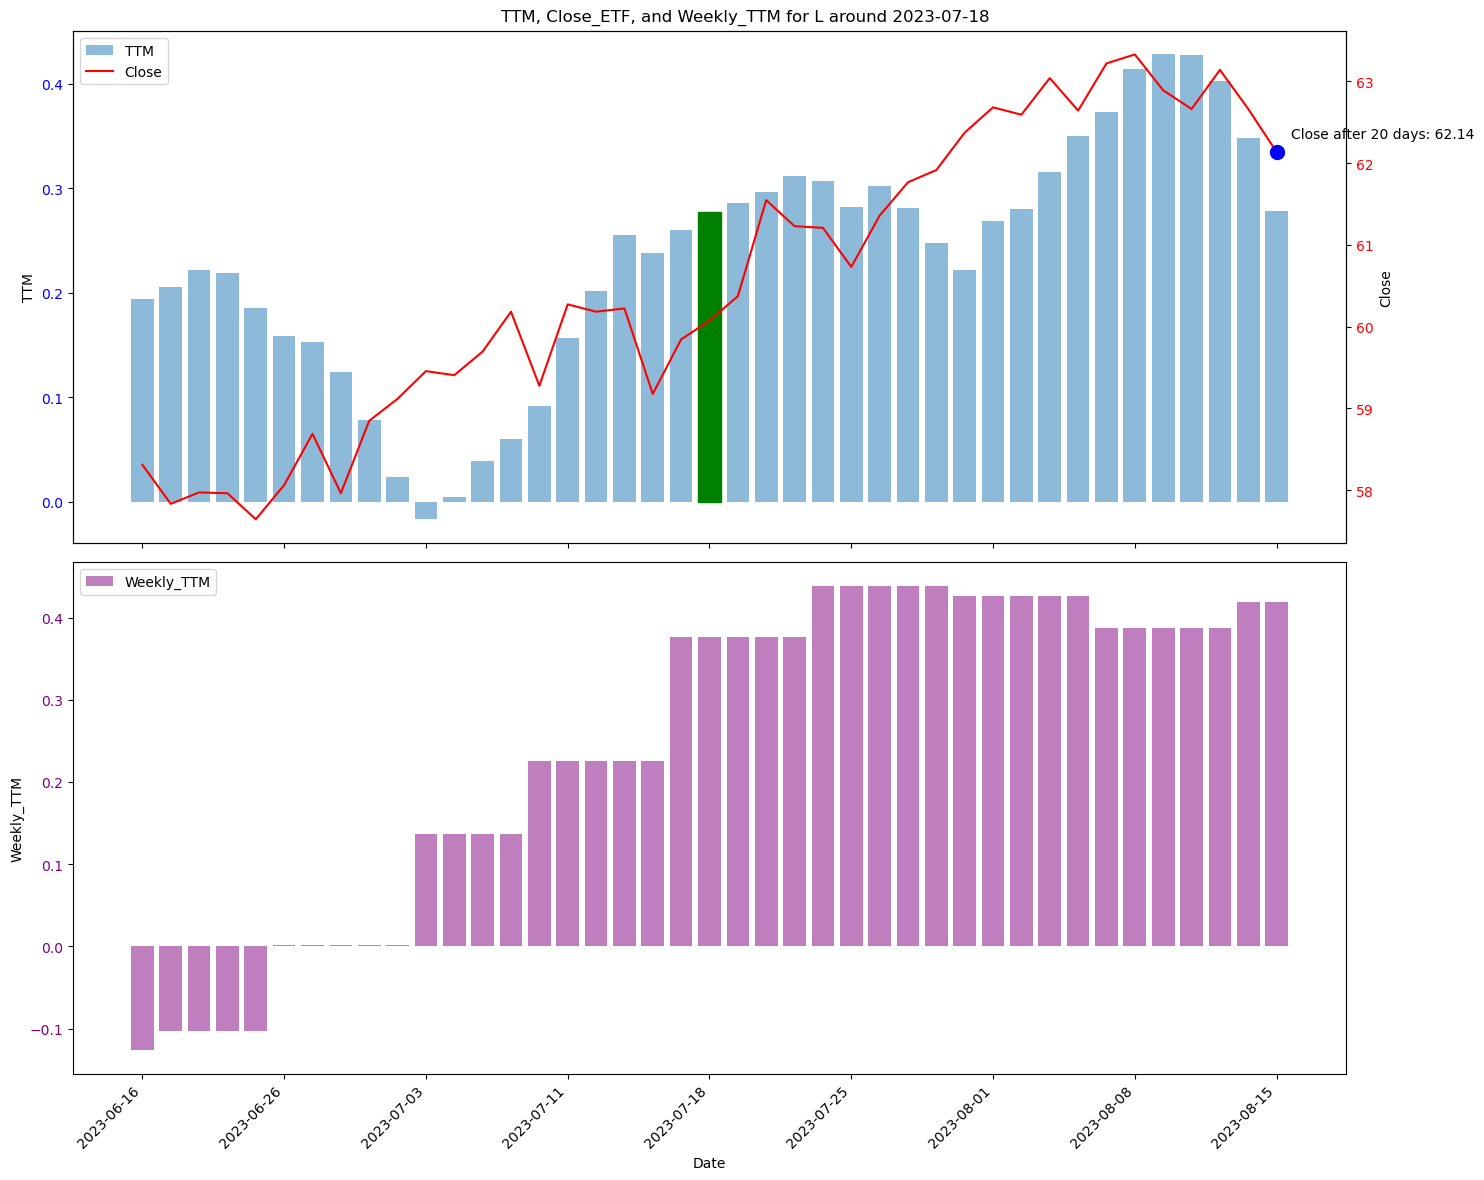

In [61]:
check=df[df['Ticker']==squeeze_on['Ticker'].values[1250]]

mf.plot_ttm_and_close(check,squeeze_on['Ticker'].values[1250], squeeze_on['Date'].values[1250])

**These are just more observations where the TTM_Daily and Weekly are increasing and the raw value is high and the stock produces gains.  We did see one observation that produced a substatial loss.  Based on these graphs you would think that the squeeze being on and the ttm values being high/increasing indicates gains.  Let's see if that is true.**

# Squeeze_ Off

0.0657514124876837


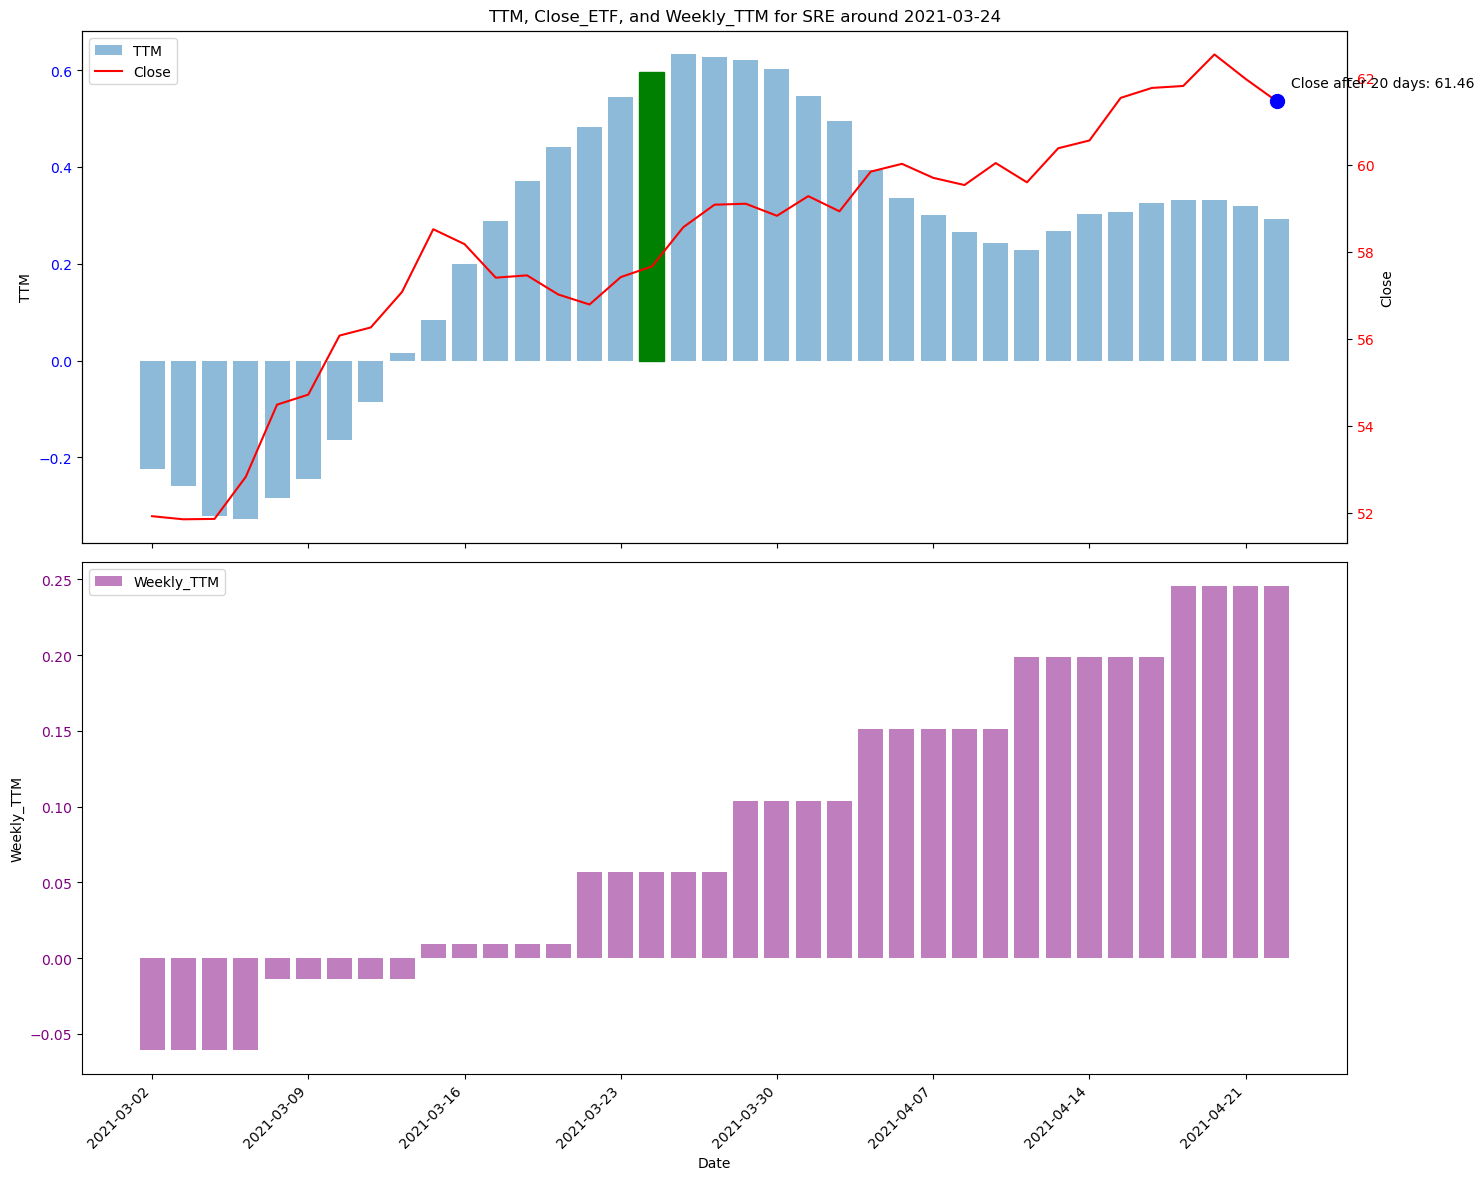

In [65]:
check=df[df['Ticker']==squeeze_off['Ticker'].values[1250]]

mf.plot_ttm_and_close(check,squeeze_off['Ticker'].values[1250], squeeze_off['Date'].values[1250])

0.0376611181422625


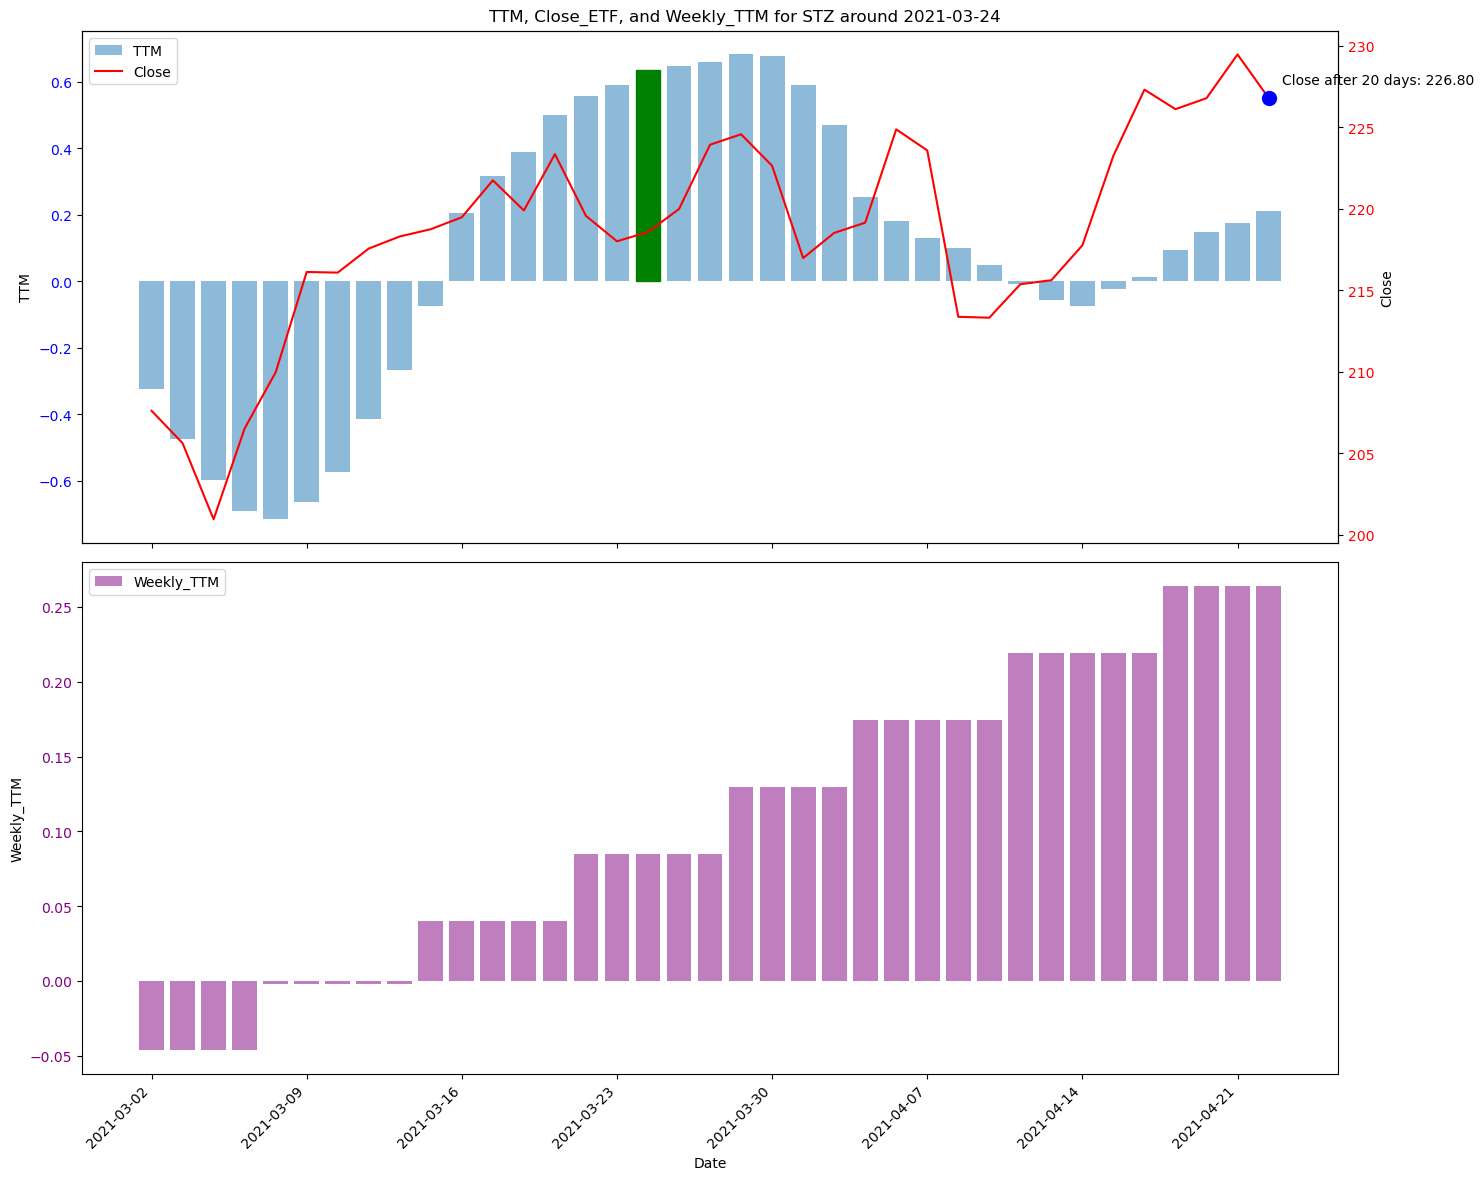

In [67]:
check=df[df['Ticker']==squeeze_off['Ticker'].values[1252]]

mf.plot_ttm_and_close(check,squeeze_off['Ticker'].values[1252], squeeze_off['Date'].values[1252])

0.0249187336329268


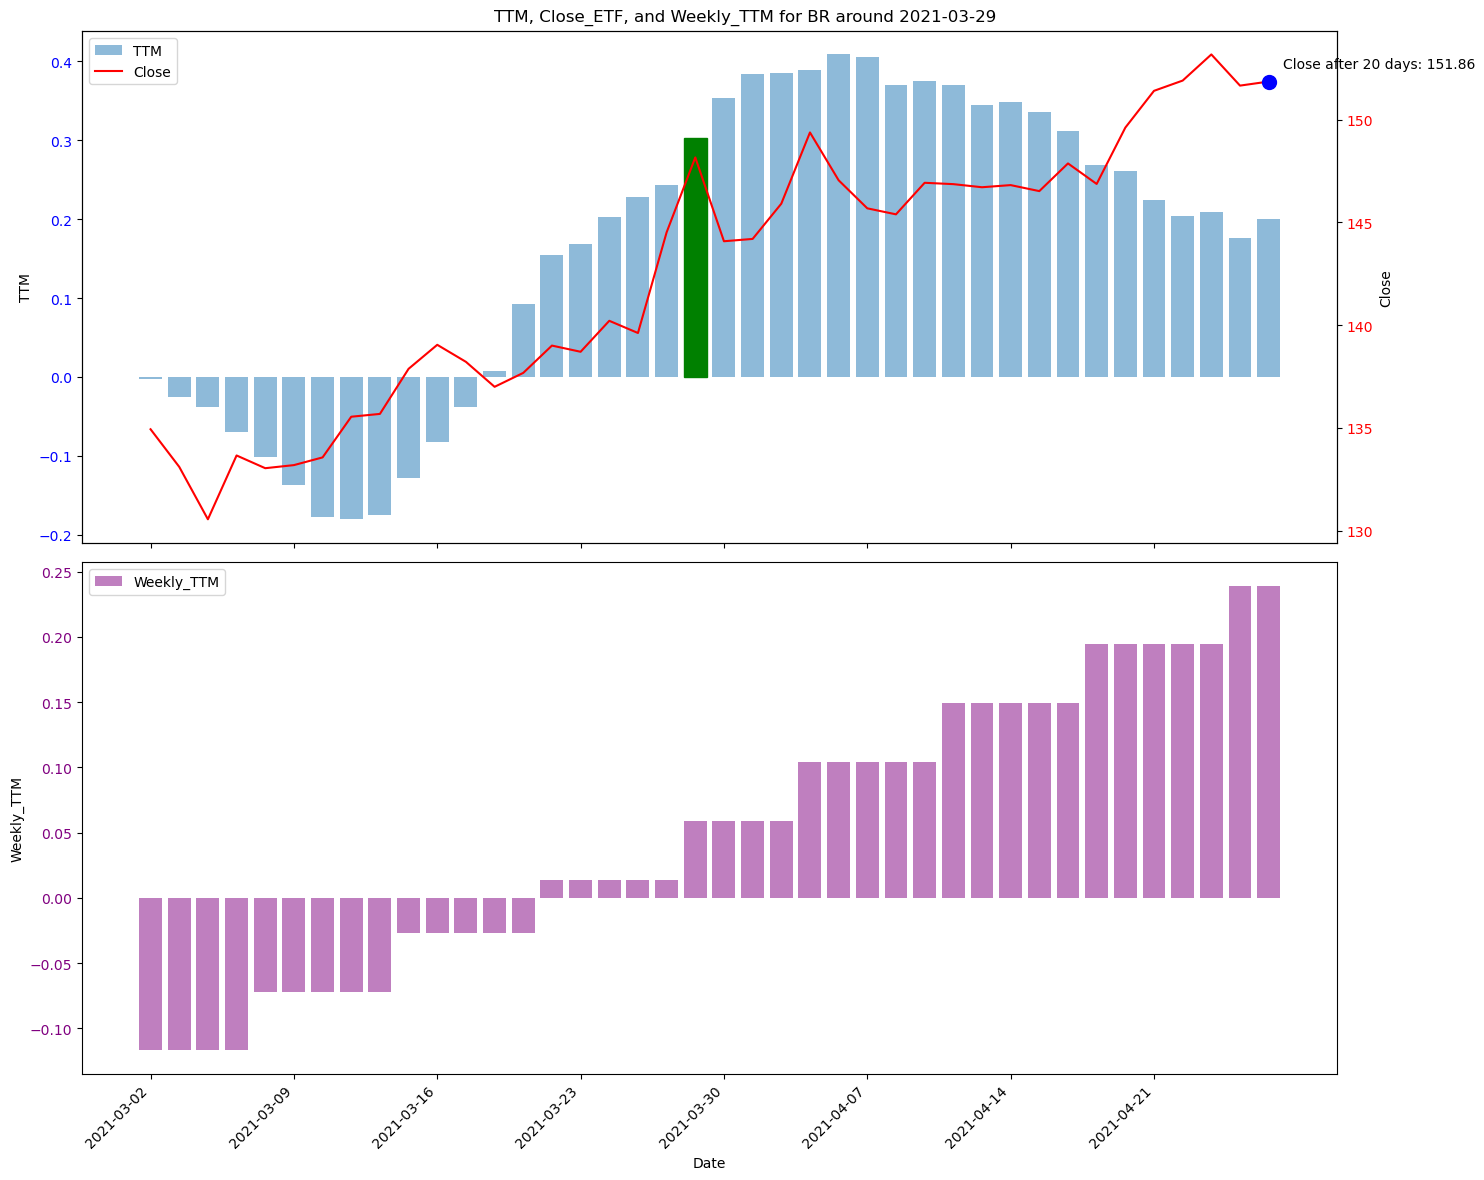

In [69]:
check=df[df['Ticker']==squeeze_off['Ticker'].values[1452]]

mf.plot_ttm_and_close(check,squeeze_off['Ticker'].values[1452], squeeze_off['Date'].values[1452])

0.0784878513418669


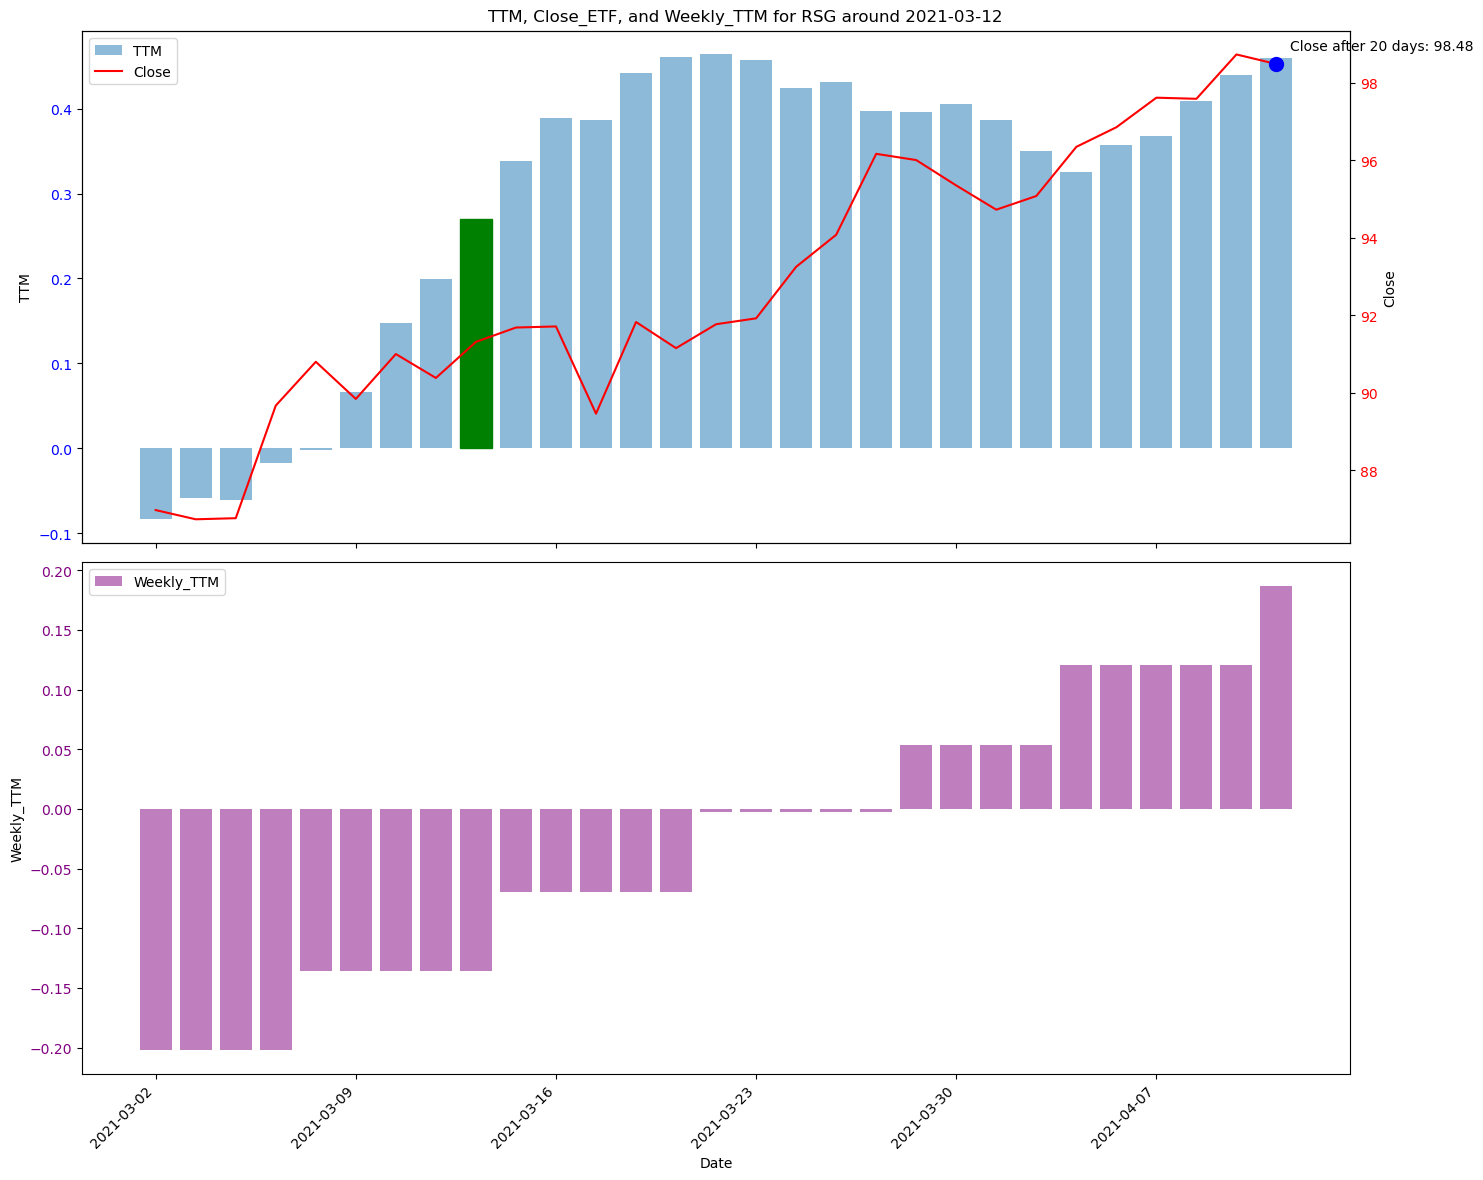

In [71]:
check=df[df['Ticker']==squeeze_off['Ticker'].values[452]]

mf.plot_ttm_and_close(check,squeeze_off['Ticker'].values[452], squeeze_off['Date'].values[452])

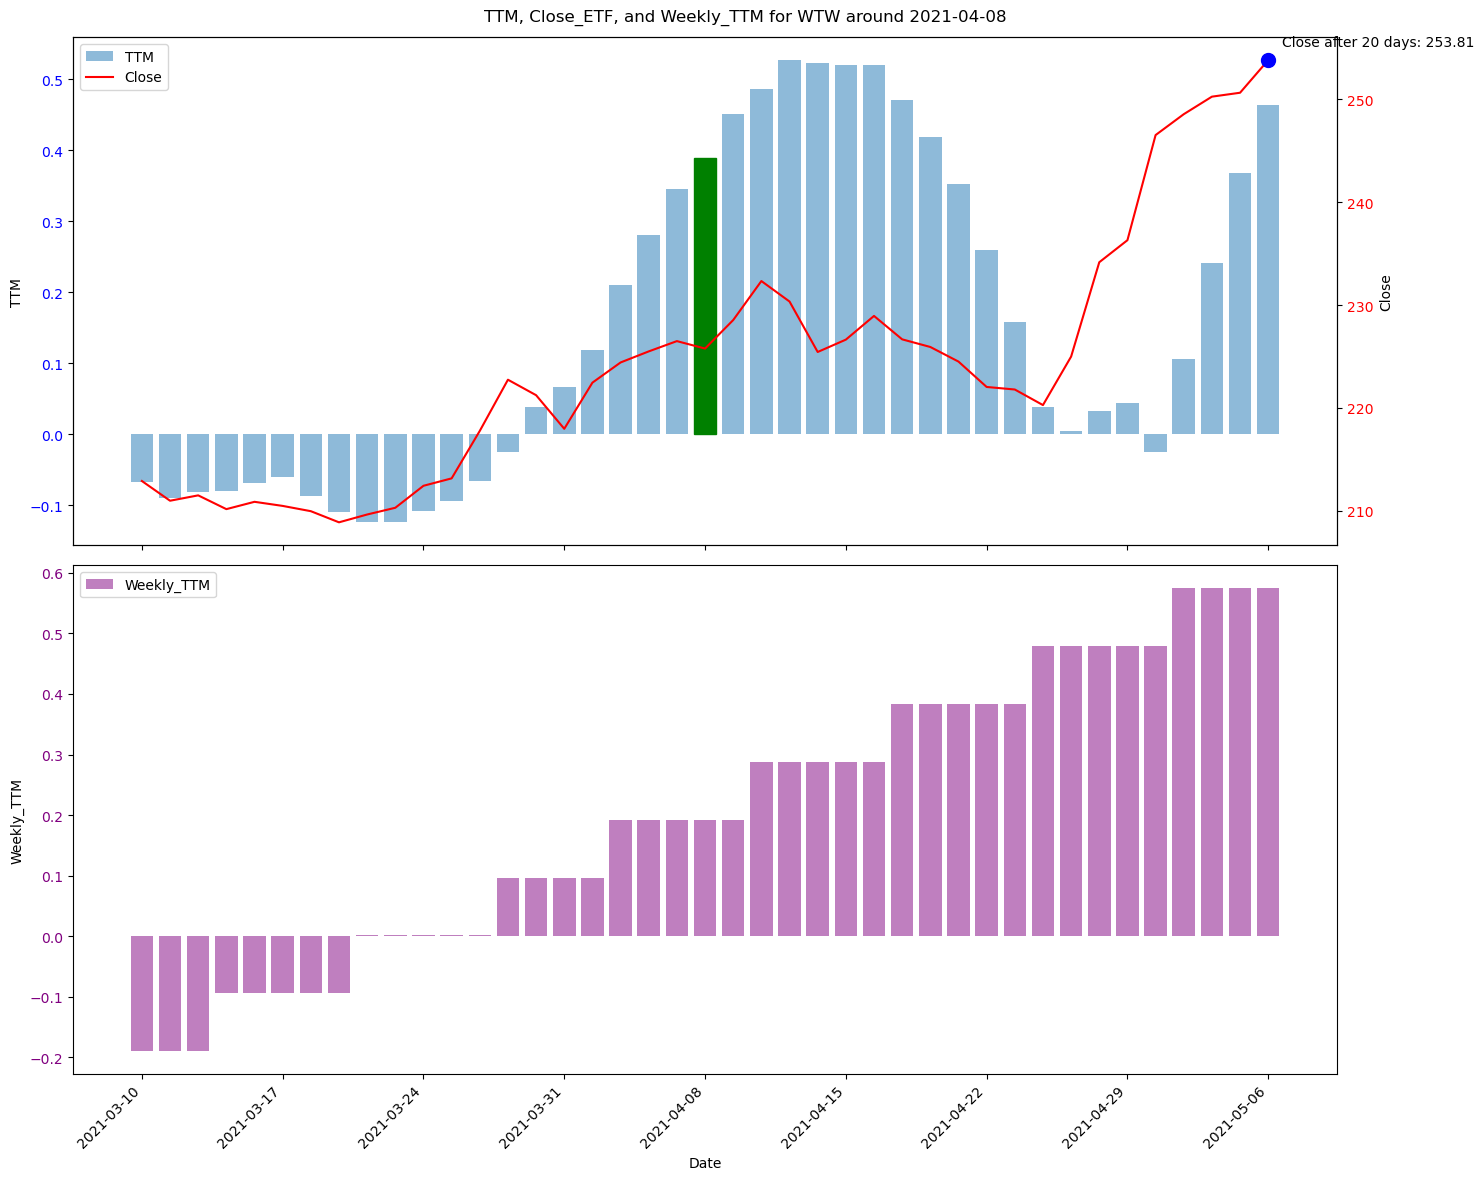

In [593]:

check=df[df['Ticker']==squeeze_off['Ticker'].values[1952]]

mf.plot_ttm_and_close(check,squeeze_off['Ticker'].values[1952], squeeze_off['Date'].values[1952])

39013


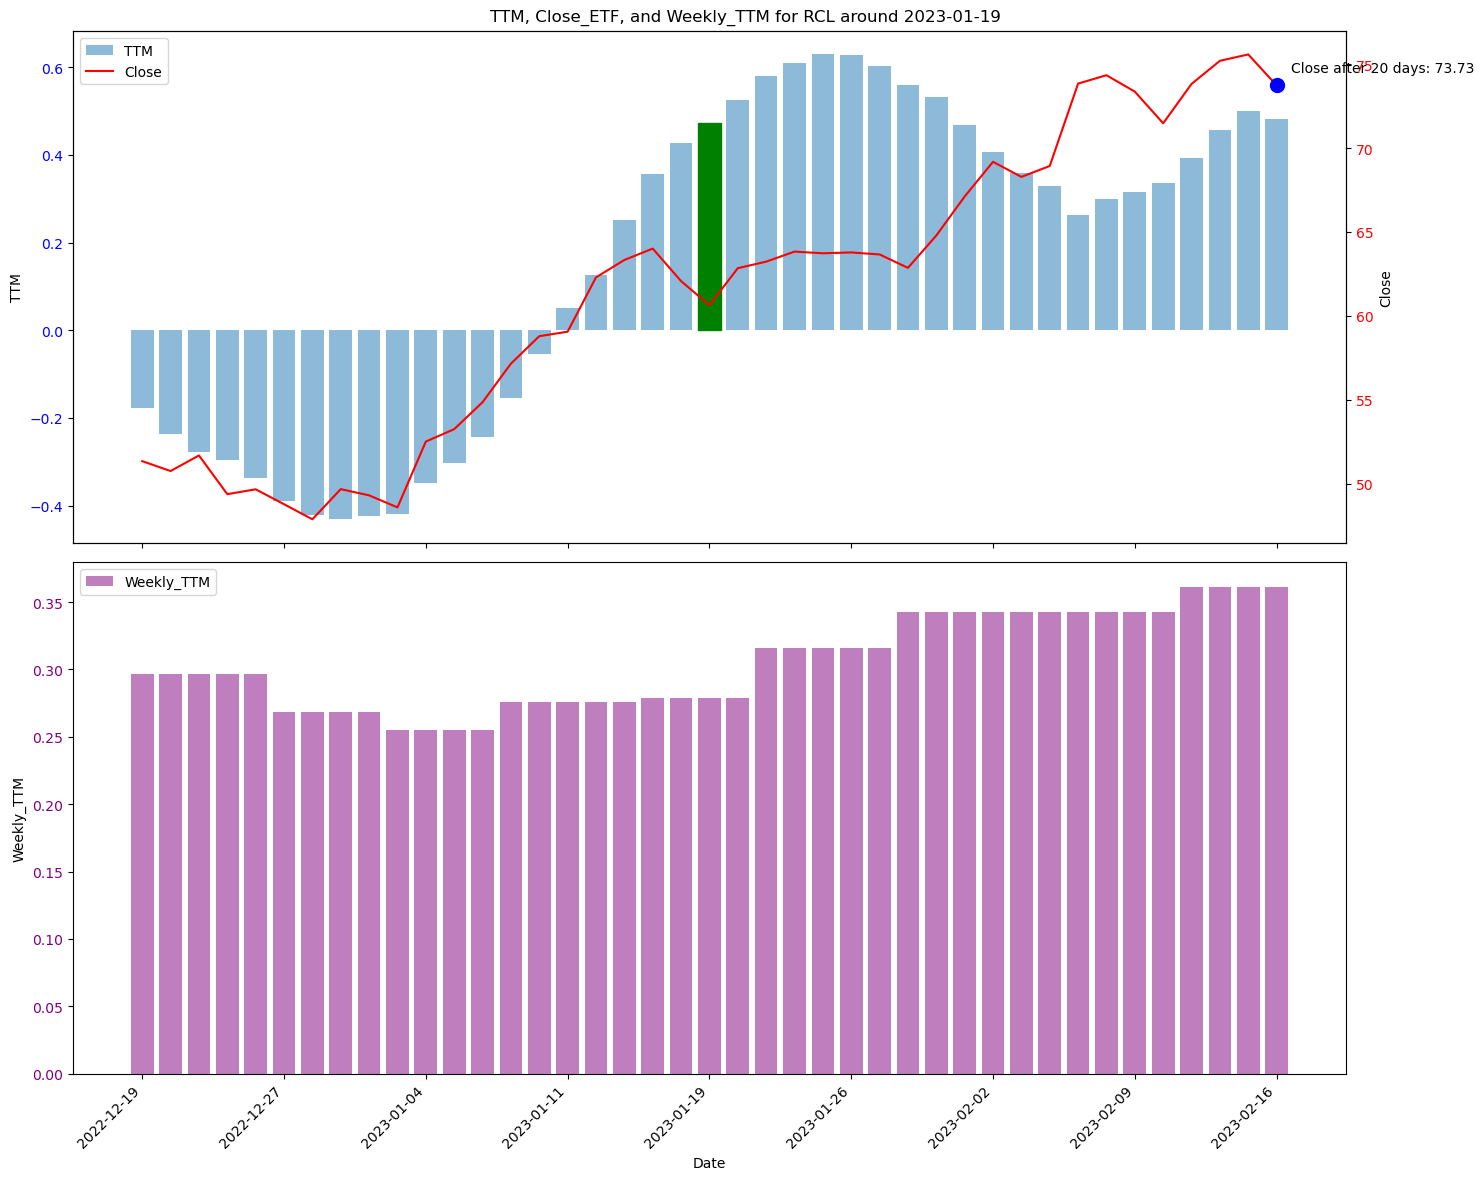

In [610]:
print(len(squeeze_off))
check=df[df['Ticker']==squeeze_off['Ticker'].values[21952]]

mf.plot_ttm_and_close(check,squeeze_off['Ticker'].values[21952], squeeze_off['Date'].values[21952])


39013


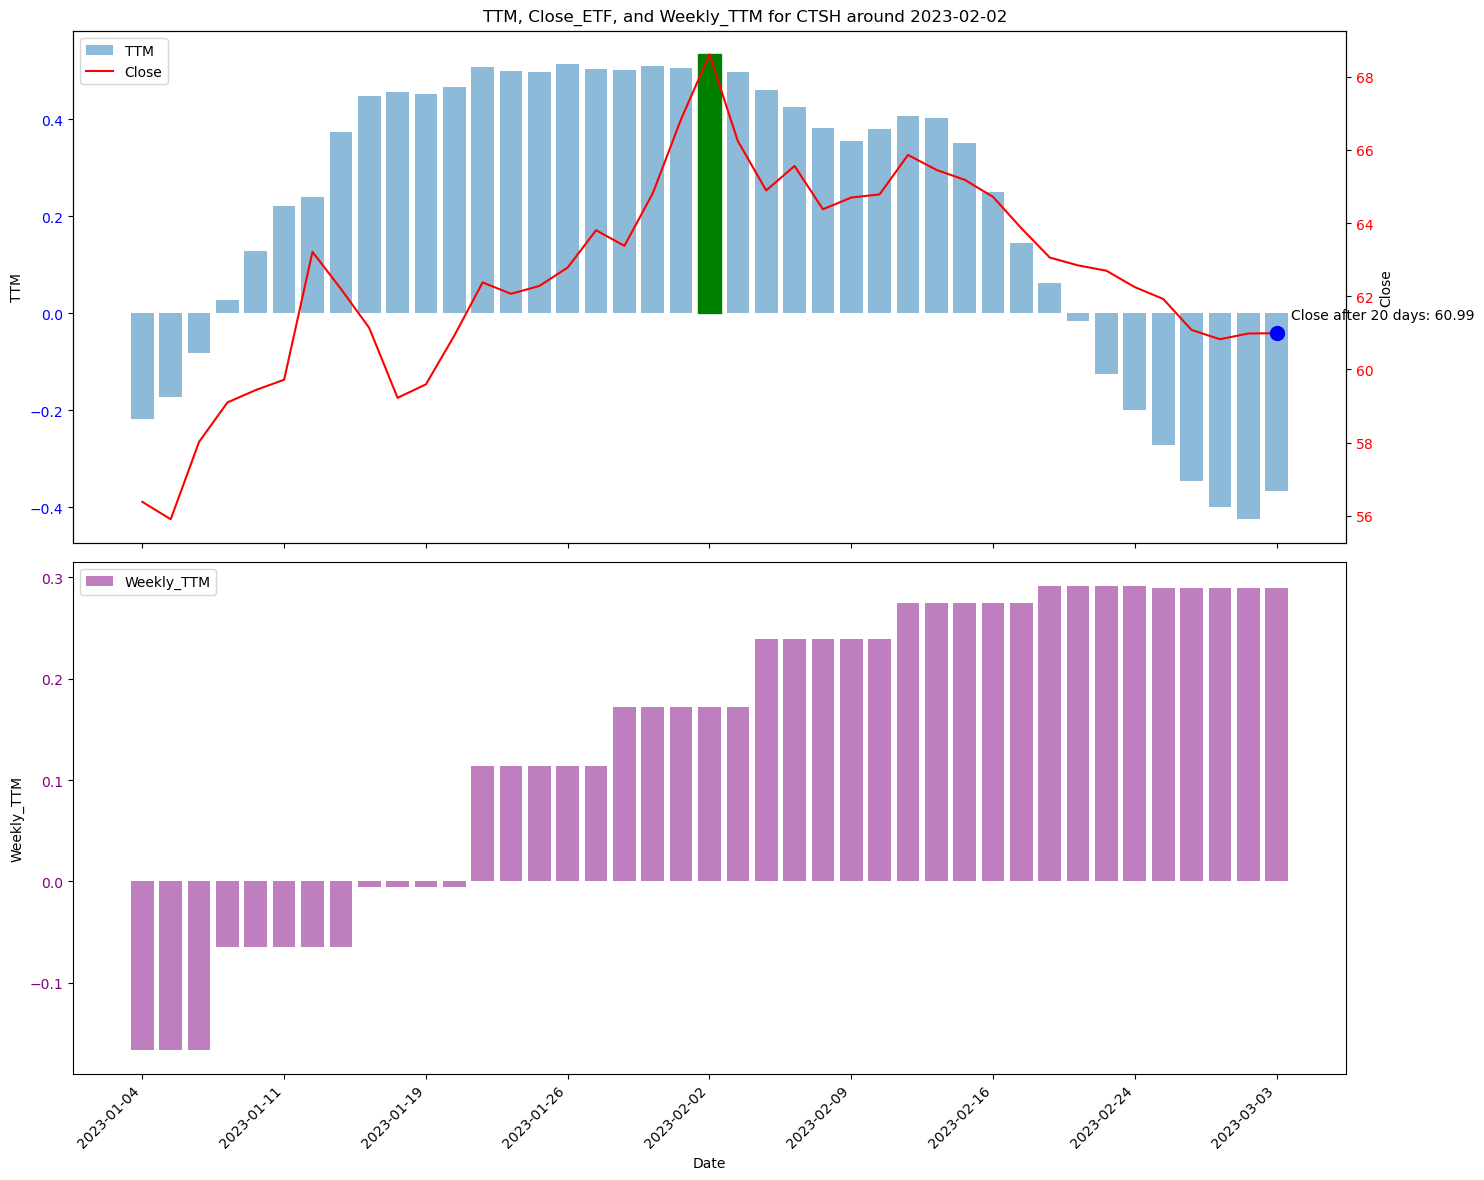

In [612]:
print(len(squeeze_off))
check=df[df['Ticker']==squeeze_off['Ticker'].values[22952]]

mf.plot_ttm_and_close(check,squeeze_off['Ticker'].values[22952], squeeze_off['Date'].values[22952])


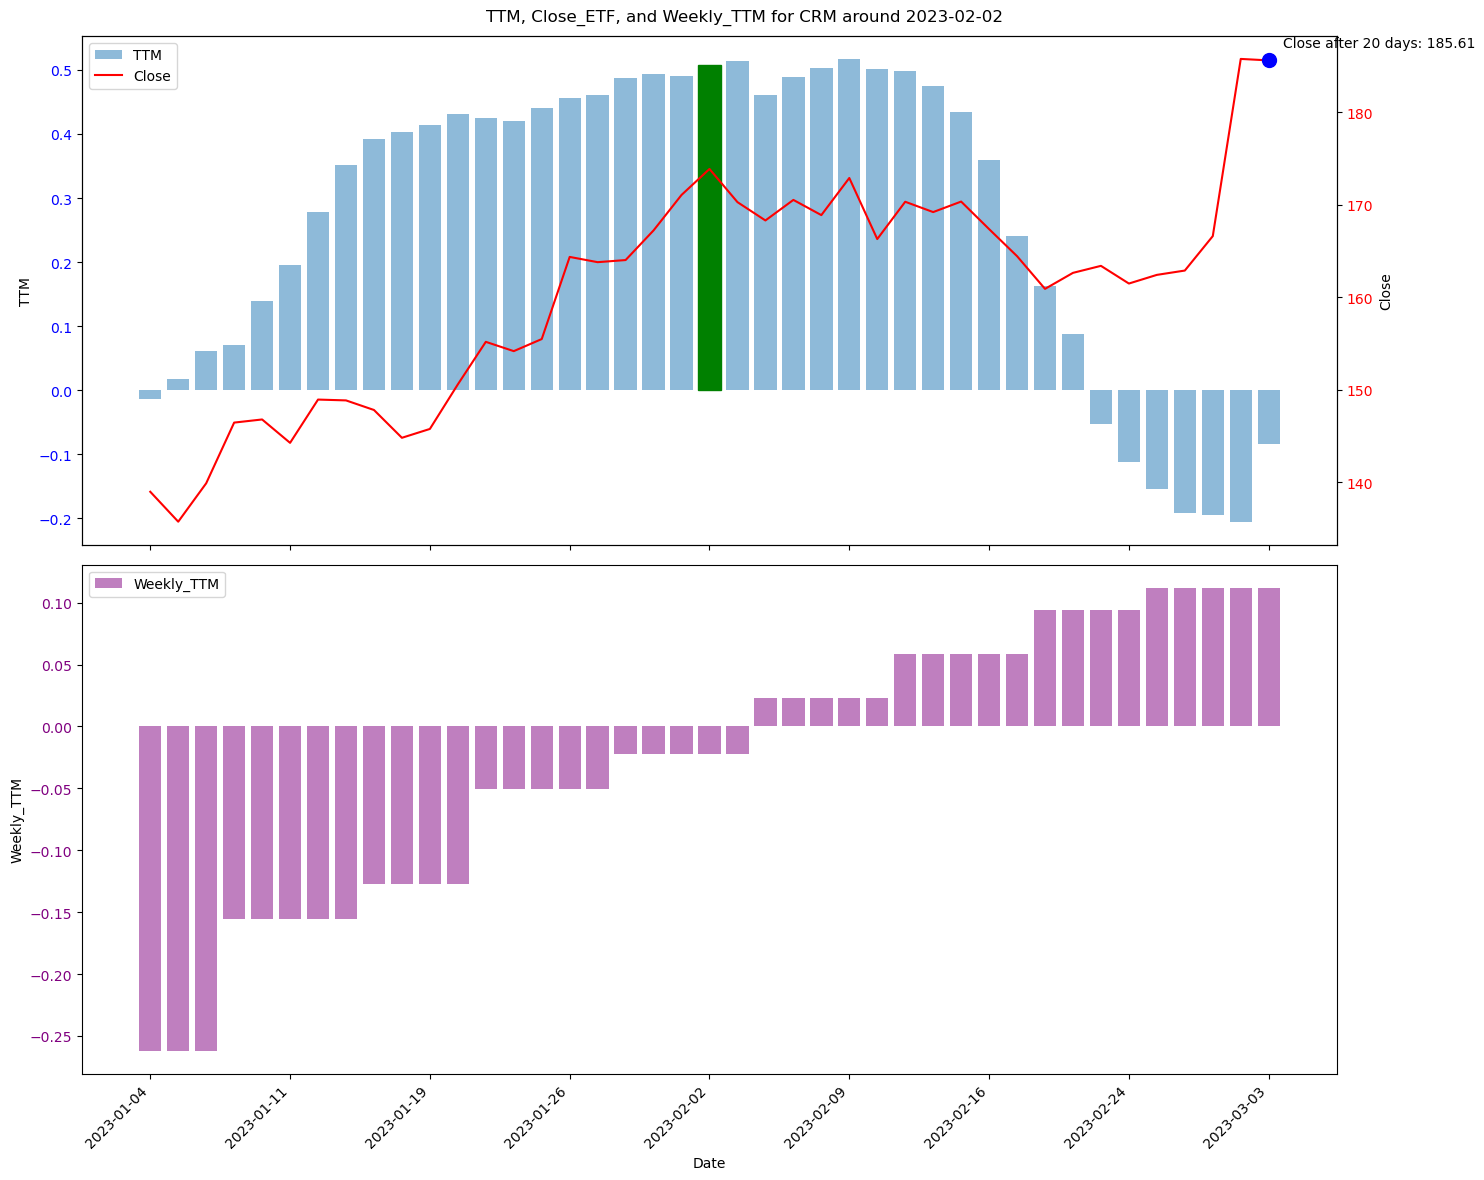

In [620]:
check=df[df['Ticker']==squeeze_off['Ticker'].values[22951]]

mf.plot_ttm_and_close(check,squeeze_off['Ticker'].values[22951], squeeze_off['Date'].values[22951])


In [73]:
print('Average Percent Gain (20 day): High/Increasing TTM/squeeze_on', squeeze_on['Pct_Change_20'].mean())
print('Average Percent Gain (20 day): High/Increasing TTM/squeeze_off', squeeze_off['Pct_Change_20'].mean())
print('Average Percent Gain (20 day): All Data', df['Pct_Change_20'].mean())

Average Percent Gain (20 day): High/Increasing TTM/squeeze_on -0.0017776074752776981
Average Percent Gain (20 day): High/Increasing TTM/squeeze_off 0.0022737759725490417
Average Percent Gain (20 day): All Data 0.009816421727241339


**This story is not adding up.  It seesm like there is a relationship between the ttm values and high percent gains, but the average percent change doest suggest that**

In [602]:
print(df['Pct_Change_20'].describe())
print(squeeze_off['Pct_Change_20'].describe())
print("Max Pct_Change_20 in full dataset:", df['Pct_Change_20'].max())
print("Min Pct_Change_20 in full dataset:", df['Pct_Change_20'].min())
print("Pct_Change_20 99th percentile:", df['Pct_Change_20'].quantile(0.99))
print("Pct_Change_20 1st percentile:", df['Pct_Change_20'].quantile(0.01))


count    388763.000000
mean          0.009816
std           0.086123
min          -0.622085
25%          -0.041787
50%           0.008562
75%           0.058802
max           2.223735
Name: Pct_Change_20, dtype: float64
count    39013.000000
mean         0.002274
std          0.076718
min         -0.407985
25%         -0.042447
50%          0.004610
75%          0.048040
max          1.074736
Name: Pct_Change_20, dtype: float64
Max Pct_Change_20 in full dataset: 2.223735050992365
Min Pct_Change_20 in full dataset: -0.6220849575466526
Pct_Change_20 99th percentile: 0.24146193393994717
Pct_Change_20 1st percentile: -0.1999771013215933


In [79]:
print(df['Invest_20'].value_counts())
print(squeeze_on['Invest_20'].value_counts())
print(squeeze_off['Invest_20'].value_counts())

Invest_20
True     211952
False    176811
Name: count, dtype: int64
Invest_20
False    811
True     797
Name: count, dtype: int64
Invest_20
True     20546
False    18467
Name: count, dtype: int64


**Possibly we can conclude that there is something about the Squeeze being off that indicates negative gains. We see that when the squeeze was off there were less positive percent changes than negative ones, and the proportions are quite different than that of the overal dataset.  Furthermore, The average percent gain was negative.**

# TTM Not Increasing/Up

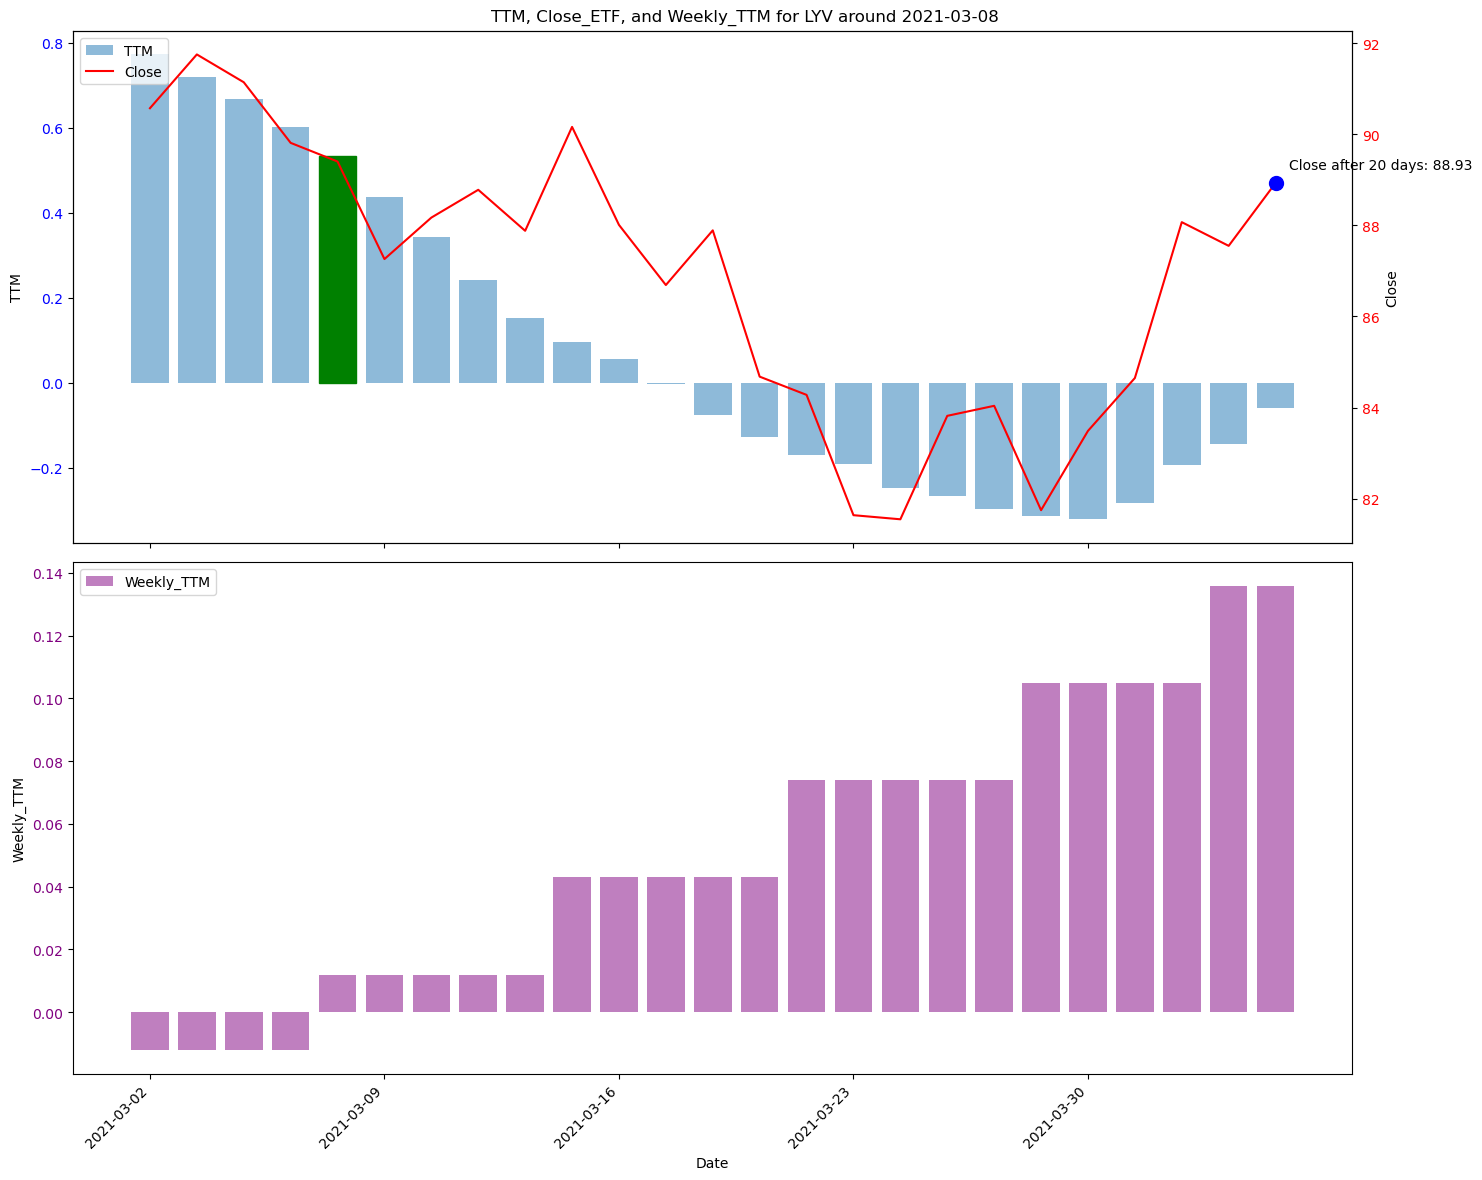

In [636]:
not_ttm_up=df[~df['TTM_daily_weekly_going_up']]
check=df[df['Ticker']==not_ttm_up['Ticker'].values[1951]]

mf.plot_ttm_and_close(check,not_ttm_up['Ticker'].values[1951], not_ttm_up['Date'].values[1951])

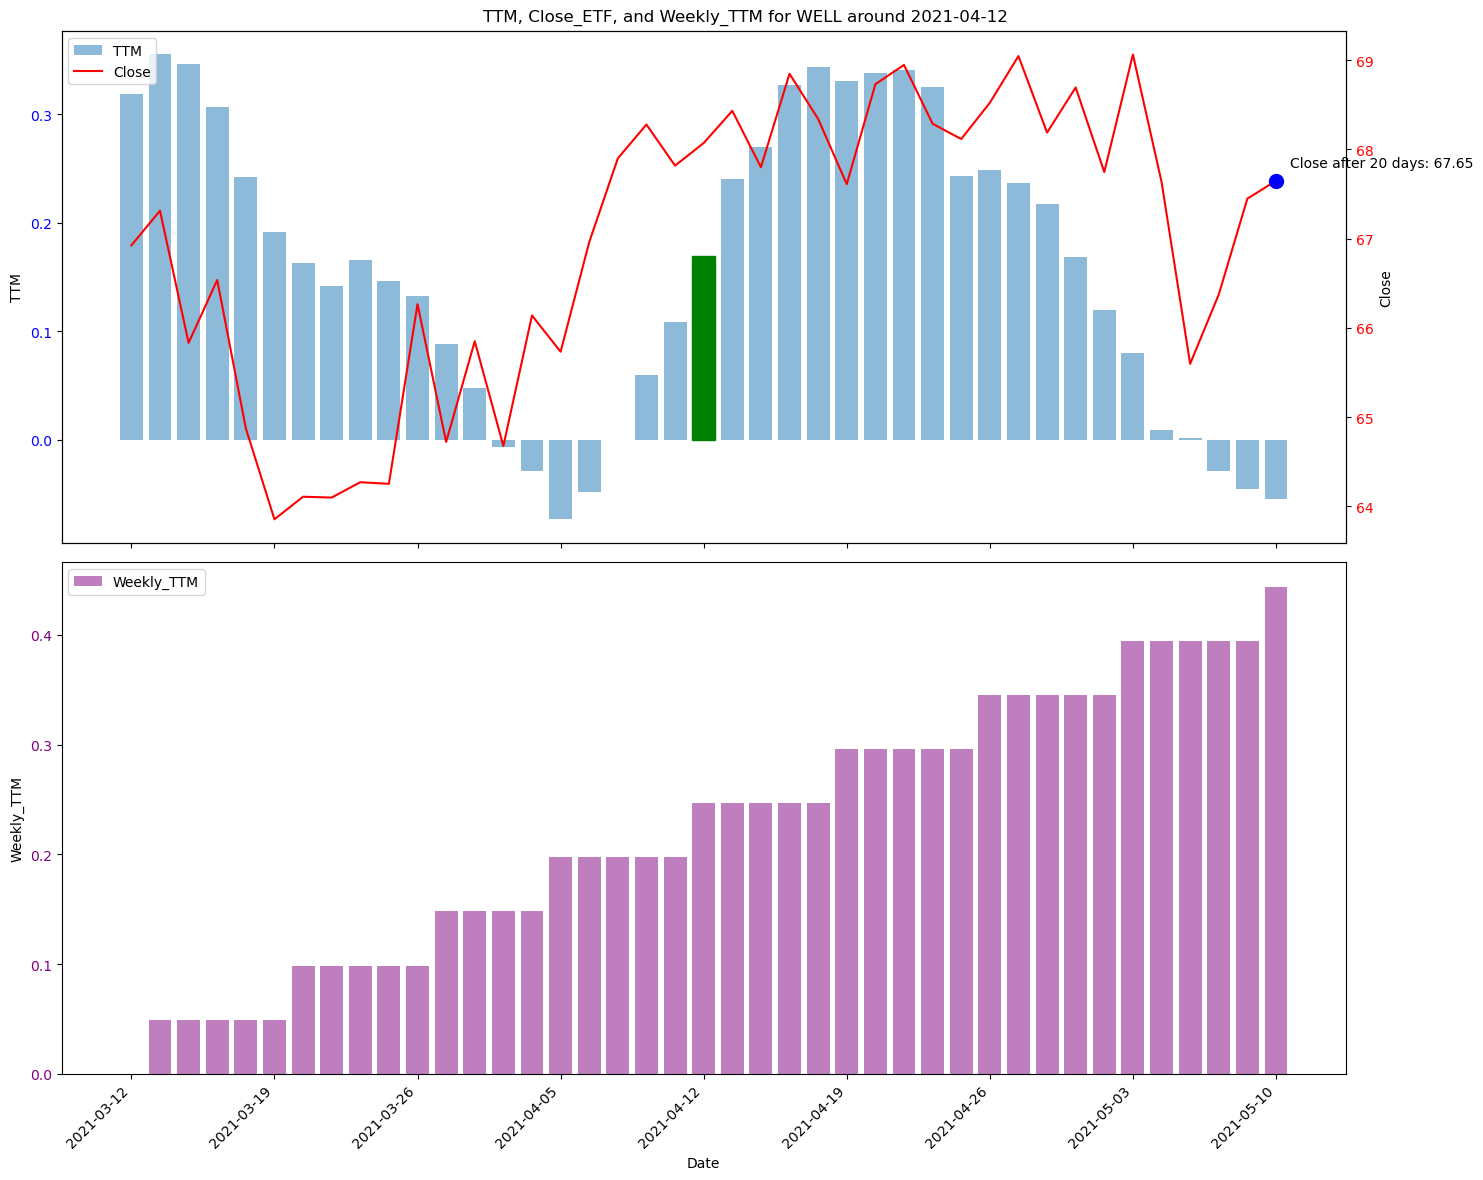

In [649]:

check=df[df['Ticker']==not_ttm_up['Ticker'].values[11051]]

mf.plot_ttm_and_close(check,not_ttm_up['Ticker'].values[11051], not_ttm_up['Date'].values[11051])

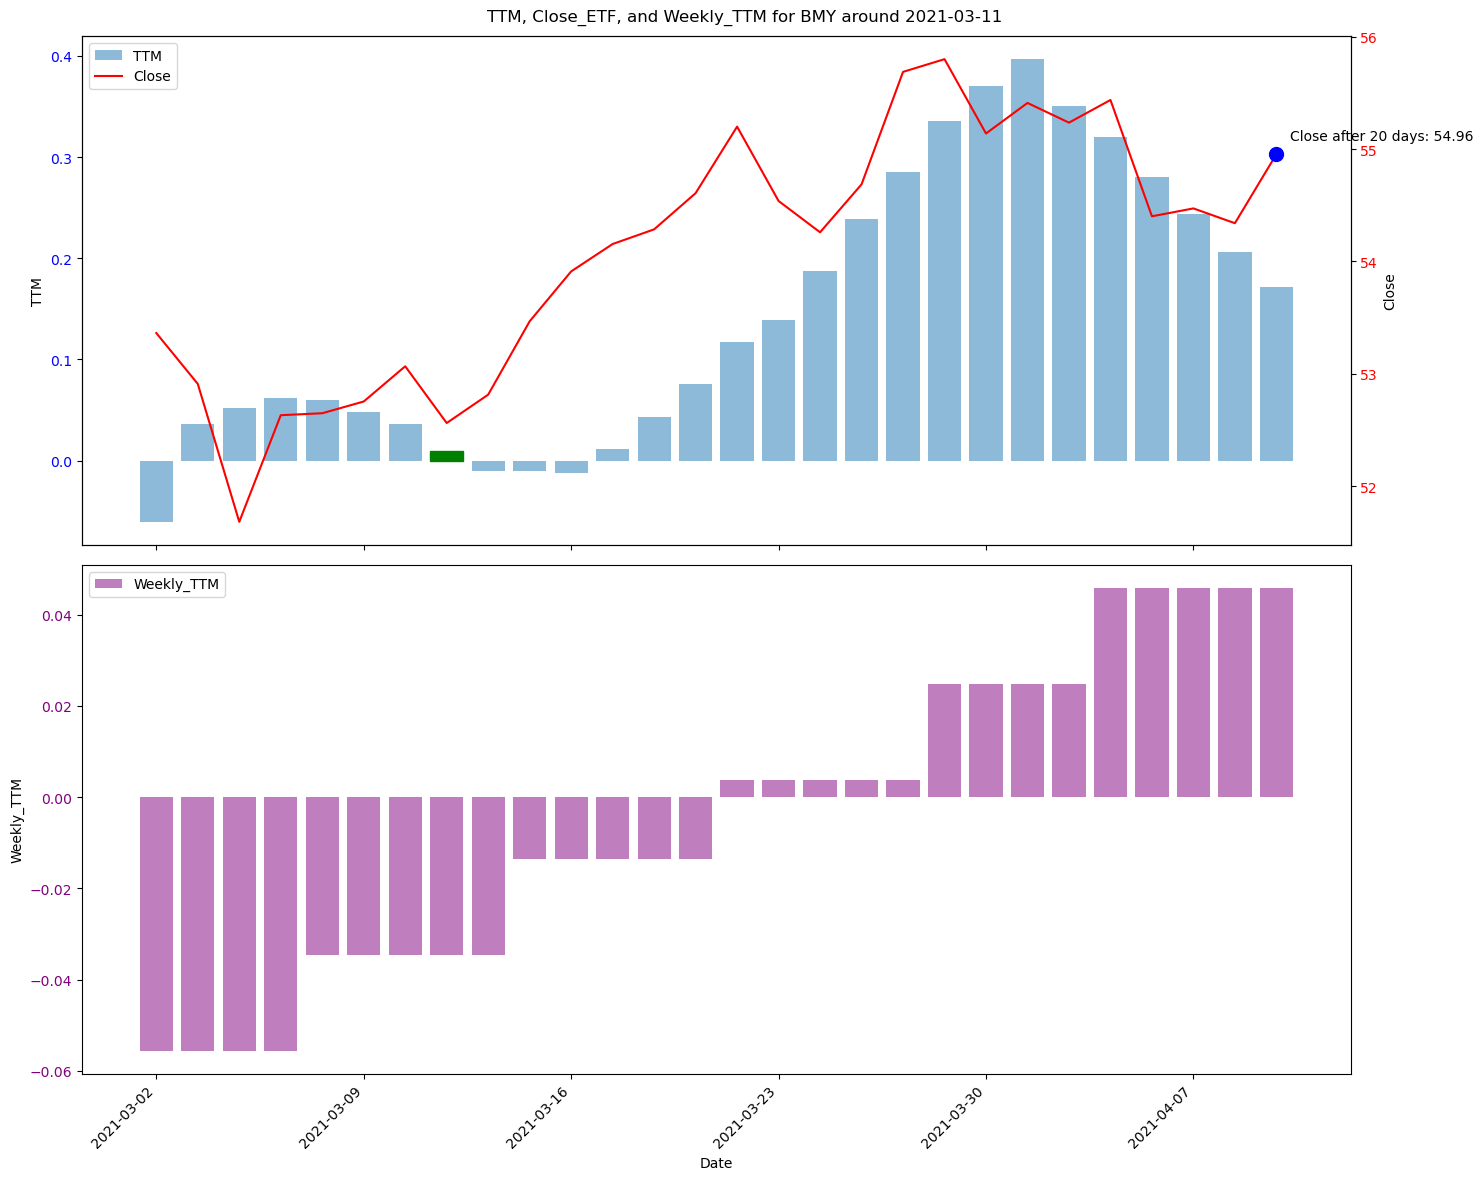

In [651]:
check=df[df['Ticker']==not_ttm_up['Ticker'].values[2951]]

mf.plot_ttm_and_close(check,not_ttm_up['Ticker'].values[2951], not_ttm_up['Date'].values[2951])

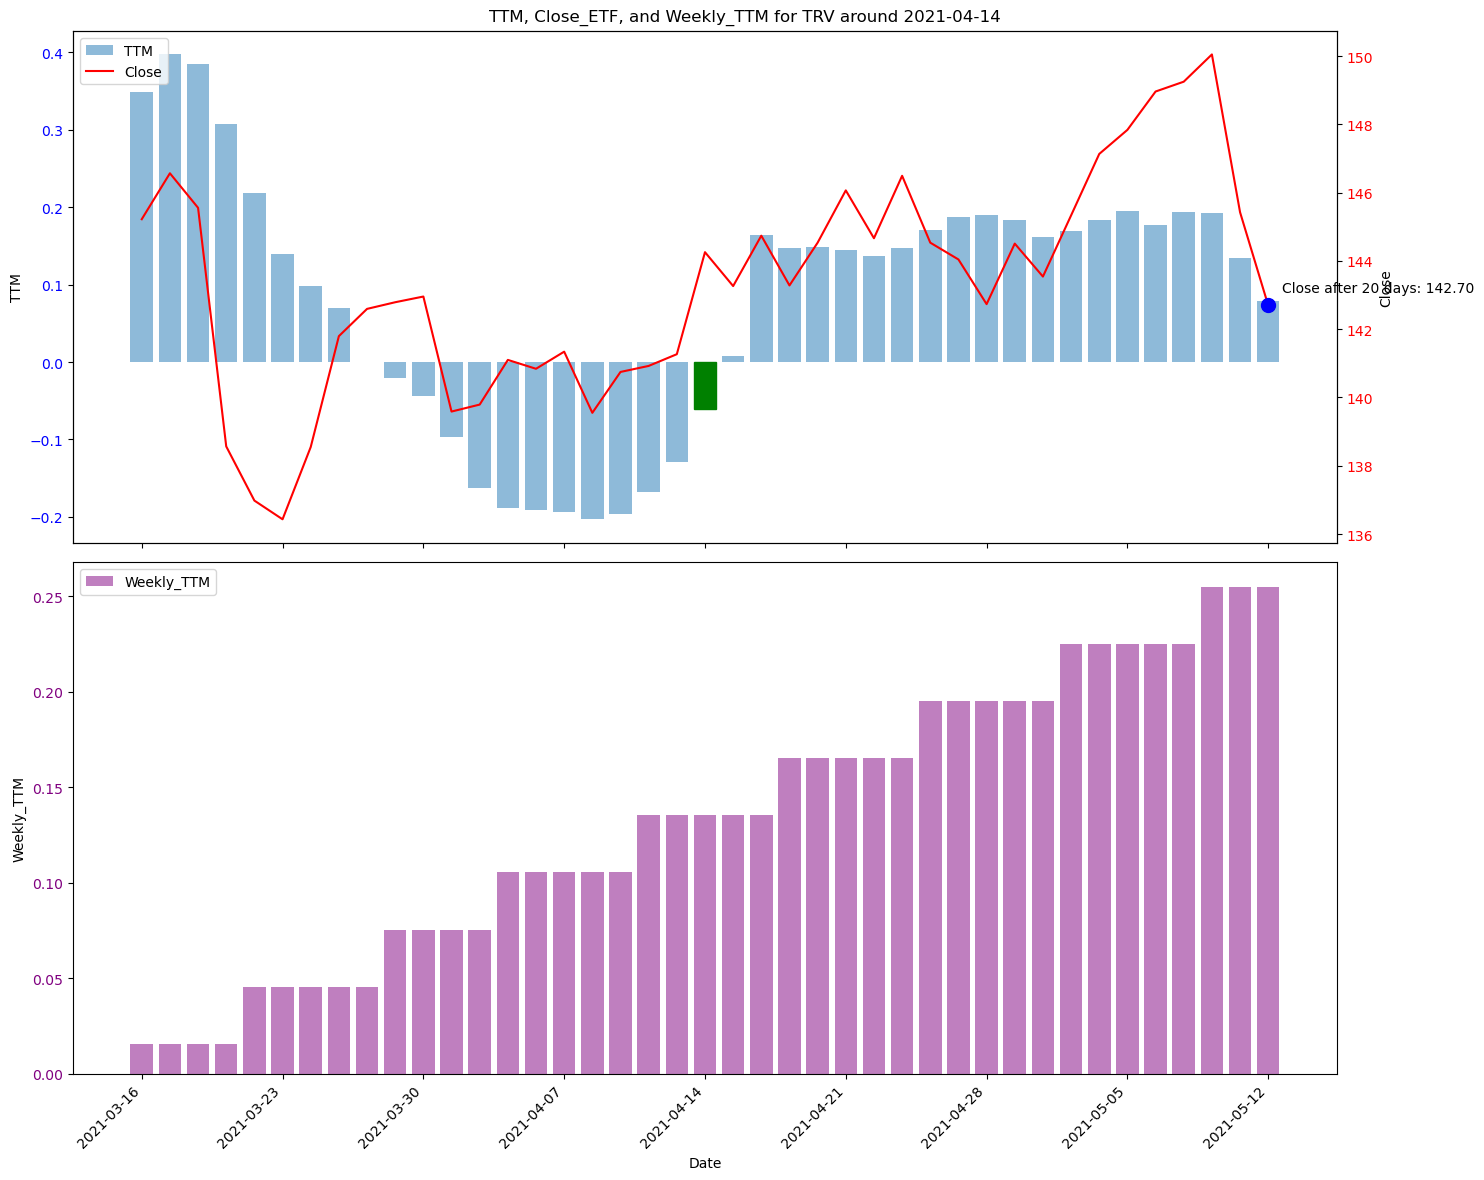

In [646]:
check=df[df['Ticker']==not_ttm_up['Ticker'].values[11693]]

mf.plot_ttm_and_close(check,not_ttm_up['Ticker'].values[11693], not_ttm_up['Date'].values[11693])

**Seems to be more of a chance of being down with this subset.  Let's try specifically specifying that we have decreasing behavior in the ttm columns and the raw value is negative**

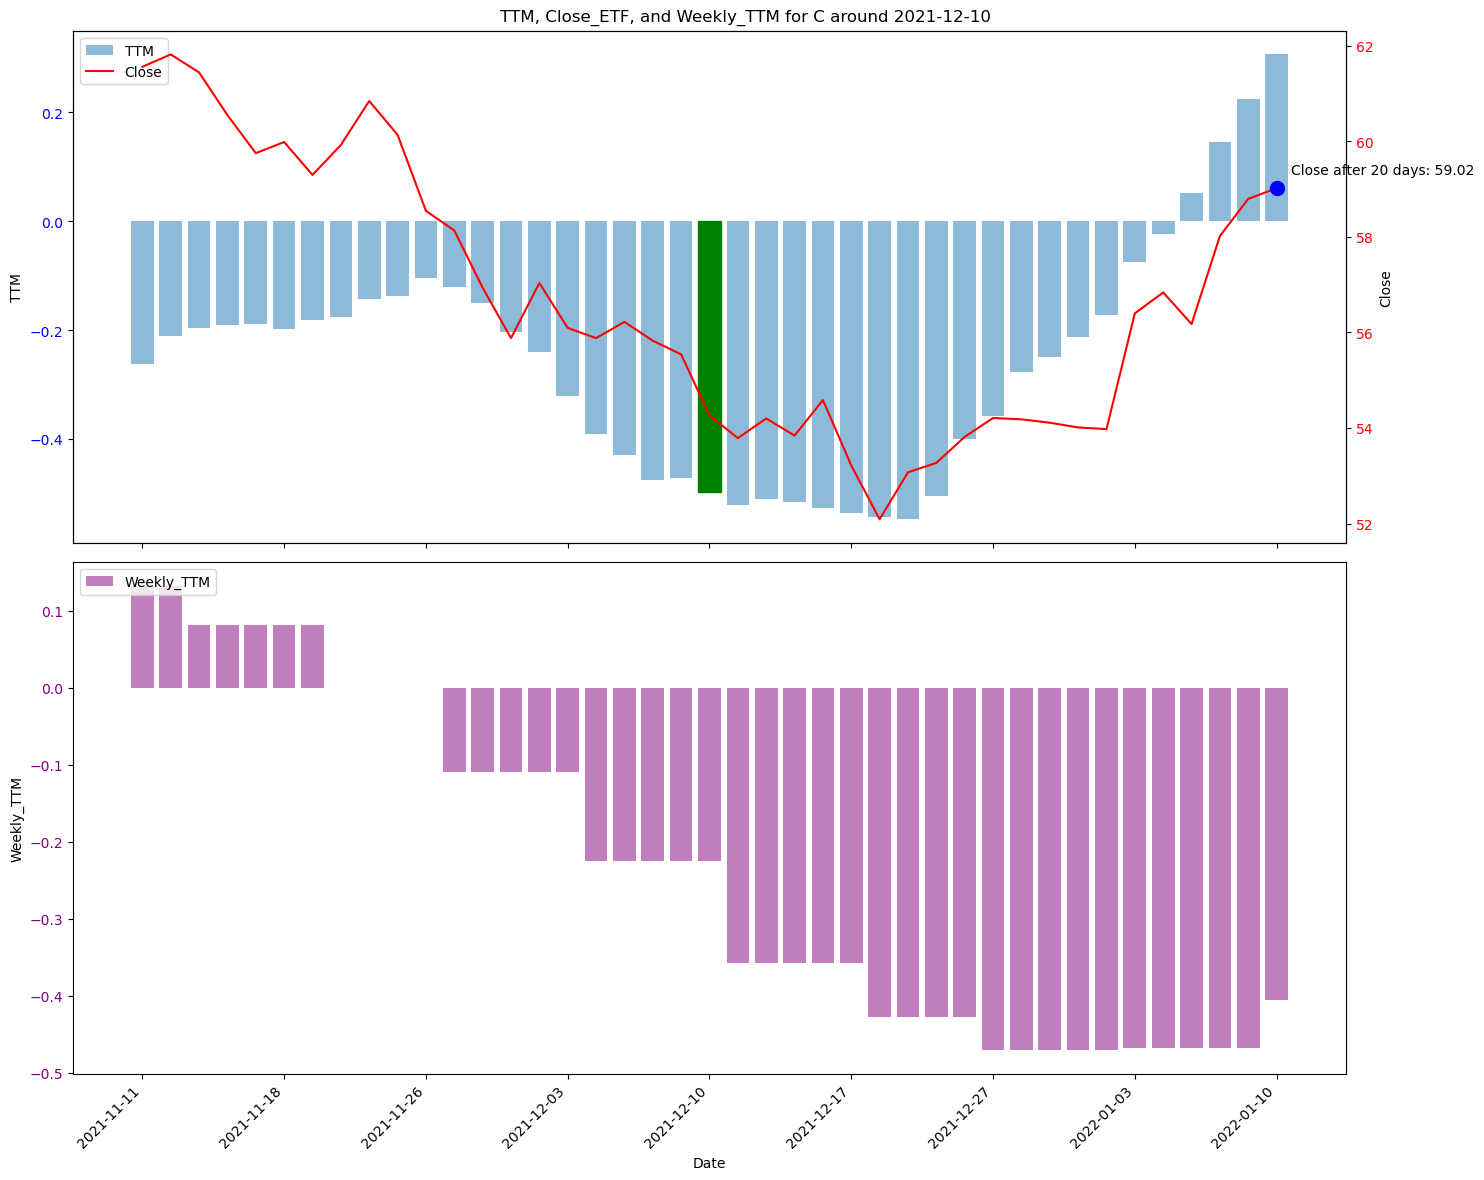

In [660]:
df['TTM_daily_weekly_going_down'] = (
    (df['TTM_Weekly_change_lag1'] <0) &
    (df['TTM_change_lag0'] <0)&(df['TTM_raw_lag0']<0)
)
ttm_down=df[df['TTM_daily_weekly_going_down']]
check=df[df['Ticker']==ttm_down['Ticker'].values[11693]]

mf.plot_ttm_and_close(check,ttm_down['Ticker'].values[11693], ttm_down['Date'].values[11693])

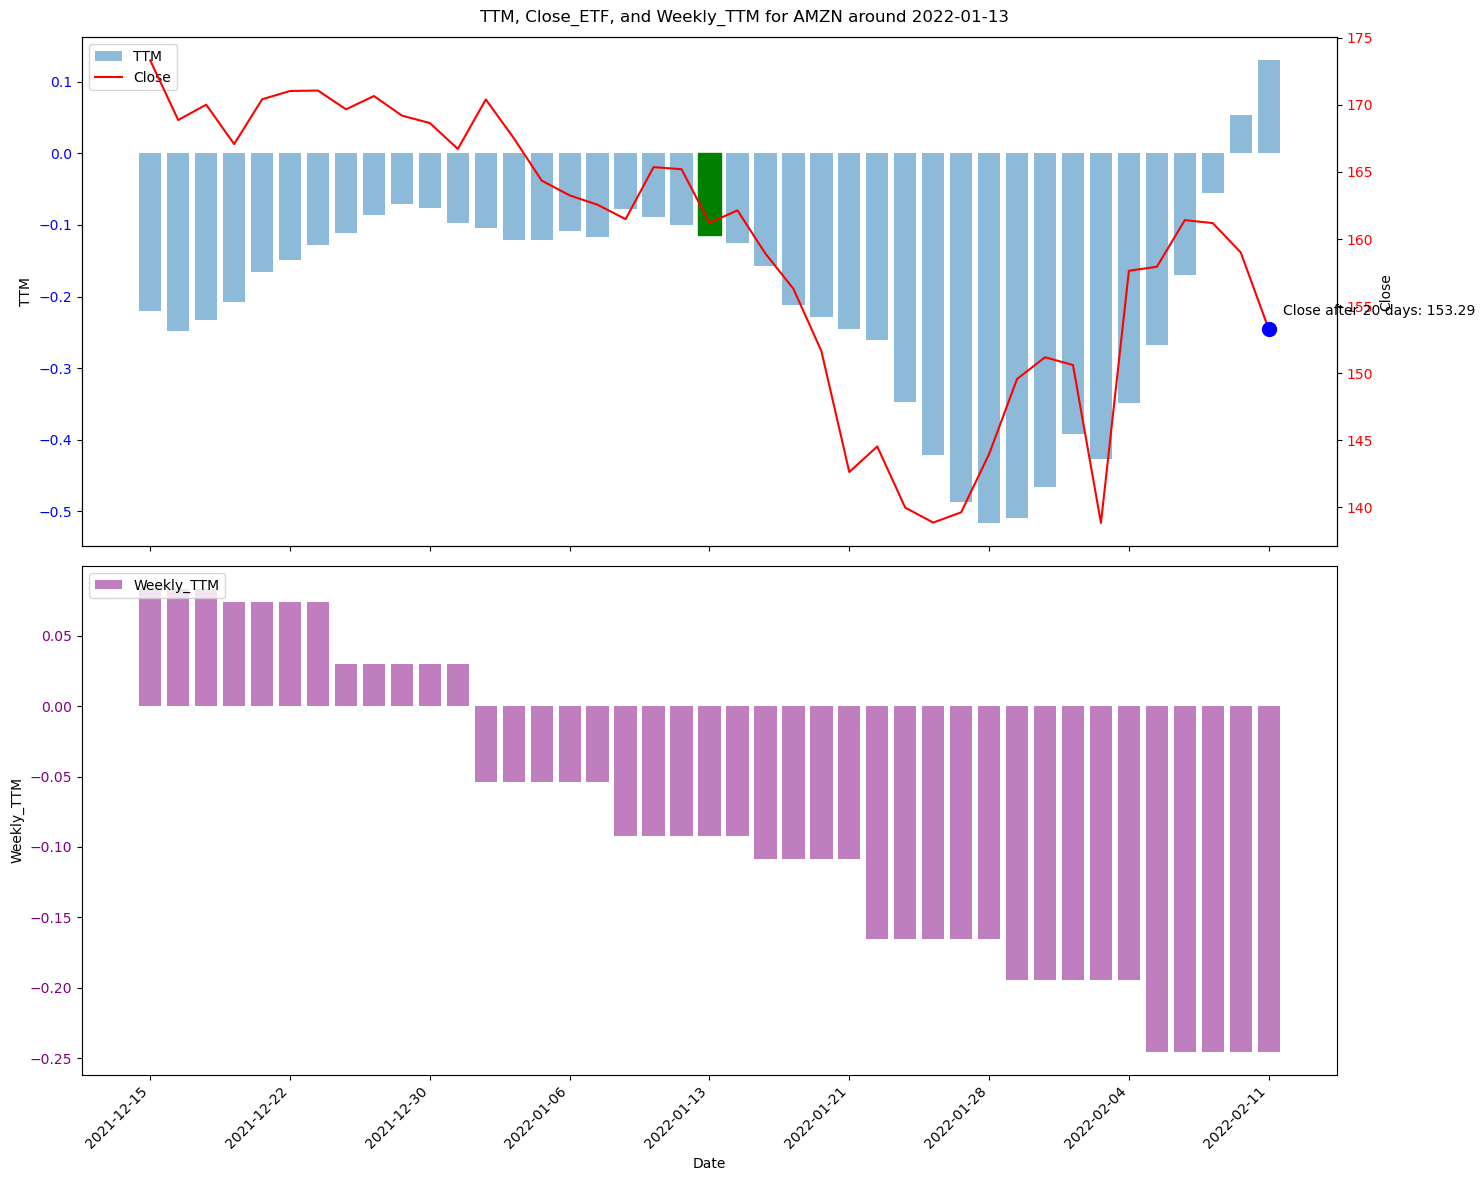

In [662]:
check=df[df['Ticker']==ttm_down['Ticker'].values[12693]]

mf.plot_ttm_and_close(check,ttm_down['Ticker'].values[12693], ttm_down['Date'].values[12693])

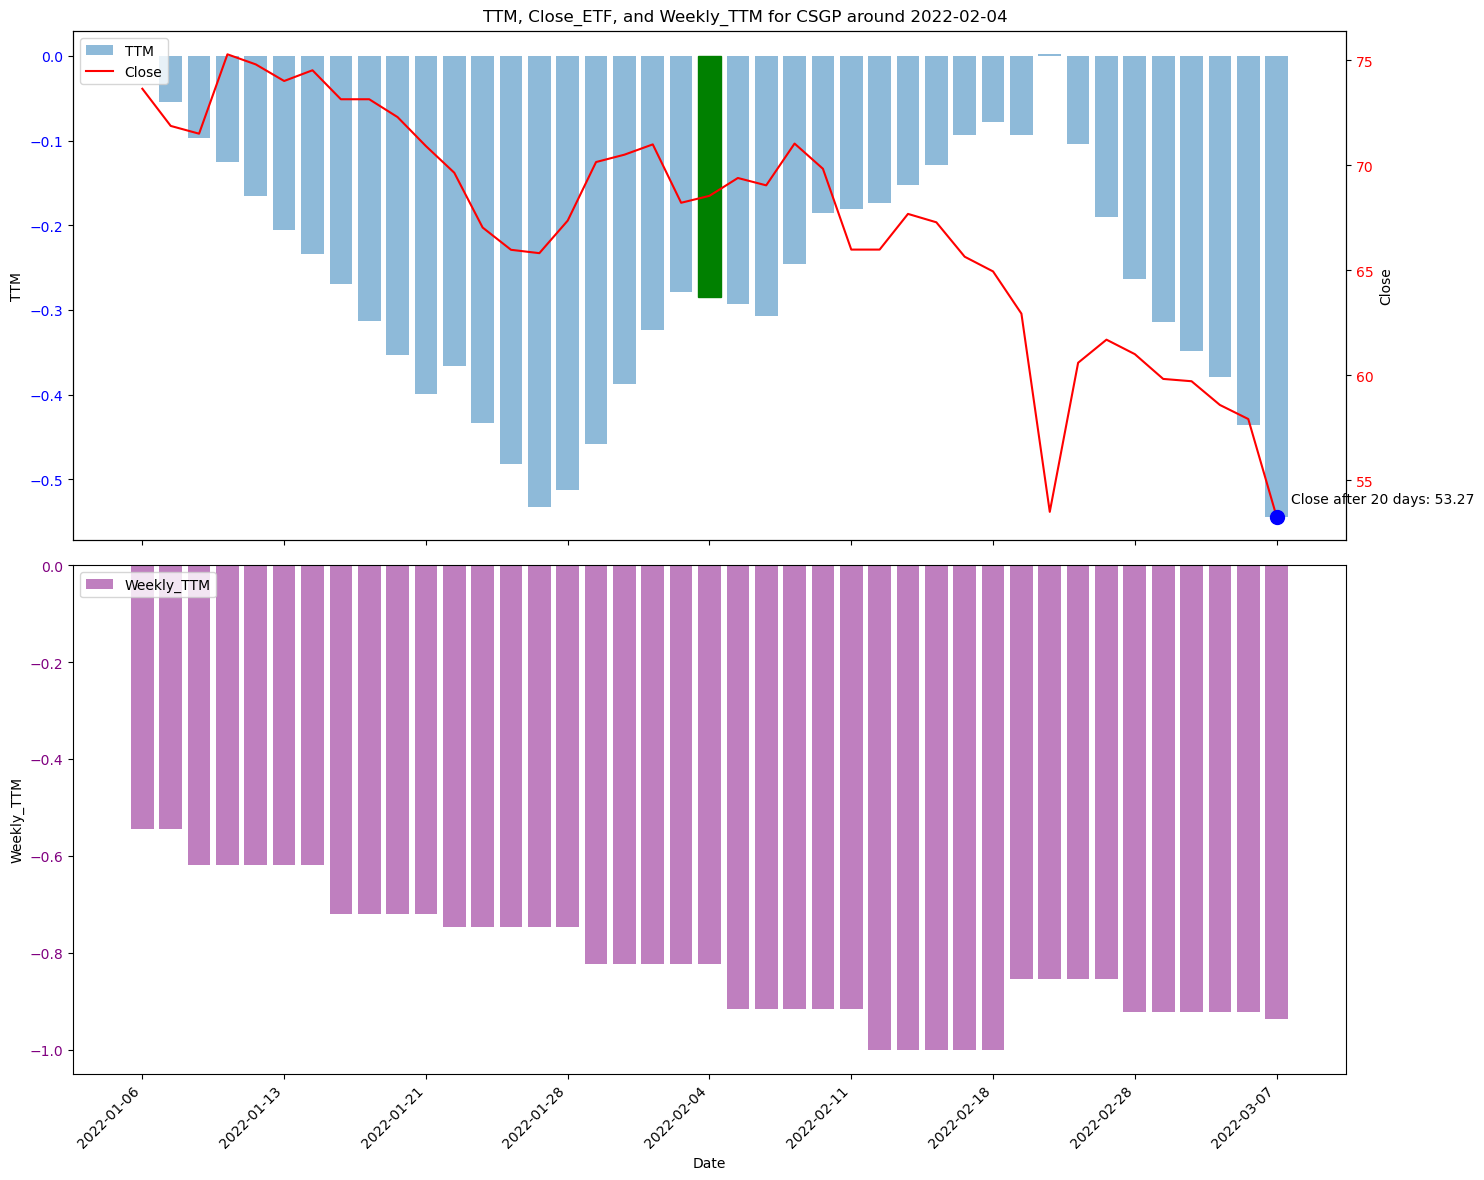

In [691]:
check=df[df['Ticker']==ttm_down['Ticker'].values[14693]]

mf.plot_ttm_and_close(check,ttm_down['Ticker'].values[14693], ttm_down['Date'].values[14693])

**The graphs would suggest a connection between the ttm values being down/not increasing and the percent change being negative.**

### The discrepency between what we see in the graphs and the average percent change analysis may have to do with specific time periods.  Maybe the subset with the high/increasing ttm has dates where the average percent change is lower as whole

In [97]:
print('Squeeze_Off/TTM Increasing/high Average Percent Change: ',squeeze_off['Pct_Change_20'].mean())
squeeze_off_dates=squeeze_off['Date'].unique()
df_squeeze_on_dates=df[df['Date'].isin(squeeze_off_dates)]
print('All Stocks on the same Dates as Squeeze off Average Percent Change: ',df_squeeze_on_dates['Pct_Change_20'].mean())

Squeeze_Off/TTM Increasing/high Average Percent Change:  0.0022737759725490417
All Stocks on the same Dates as Squeeze off Average Percent Change:  0.009238181231975489


**The average percent change for all stocks is similar to when it contained all dates, suggesting that there is nothing period specific happening here**

# Modeling with TTM_Values

**Fit Model with only TTM Values**

In [100]:
from xgboost import XGBClassifier
features=[col for col in df.columns if 'TTM' in col and 'lag' in col]
model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(df,features,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 536 Days
Test Size: 169 Days
Validation Size: 135 Days

*************** Test Set: 2023-11-01 00:00:00: 2024-07-05 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.02752327088323219
Avg Pct Gain of Test Data:  0.02370501238793823
Correlation of Predicted Probability with Pct change (Test Set):  0.06472086304451113
Correlation of The slope of RS values with Pct change (Test Set):  -0.0009211471119730307
	Accuracy (Test Set): 0.5169
	Precision (Test Set): 0.6254
	Recall (Test Set): 0.5440
	F1 Score (Test Set): 0.5819
	Mathews Score (Test Set): 0.0167

*************** Validation Set: 2023-04-19 00:00:00: 2023-10-30 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.00757968312436166
Avg Pct Gain of Validation Data:  0.00556033319194034
Correlation of Predicted Probability with Pct change (Validation Set):  0.014183479399012534
Correlation of The slope of RS values with Pct change (Validatio

**Fit model with TTM and Squeeze_On Features**

In [26]:

features=[col for col in df.columns if 'TTM' in col and 'lag' in col]+[col for col in df.columns if 'Squeeze_On' in col and 'Lag' in col]

model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(df,features,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 536 Days
Test Size: 169 Days
Validation Size: 135 Days

*************** Test Set: 2023-11-01 00:00:00: 2024-07-05 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.028284456106320896
Avg Pct Gain of Test Data:  0.023705012387938235
Correlation of Predicted Probability with Pct change (Test Set):  0.07265534003301108
Correlation of The slope of RS values with Pct change (Test Set):  -0.0009211471119730307
	Accuracy (Test Set): 0.5182
	Precision (Test Set): 0.6269
	Recall (Test Set): 0.5437
	F1 Score (Test Set): 0.5823
	Mathews Score (Test Set): 0.0201

*************** Validation Set: 2023-04-19 00:00:00: 2023-10-30 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.007834108496772242
Avg Pct Gain of Validation Data:  0.005560333191940344
Correlation of Predicted Probability with Pct change (Validation Set):  0.011422678221204926
Correlation of The slope of RS values with Pct change (Valid

**Accuracy is around 50% but the mathews scores suggest that there may be some slight advantage to using these features compared to not using them.  There is some precision on the test.** 

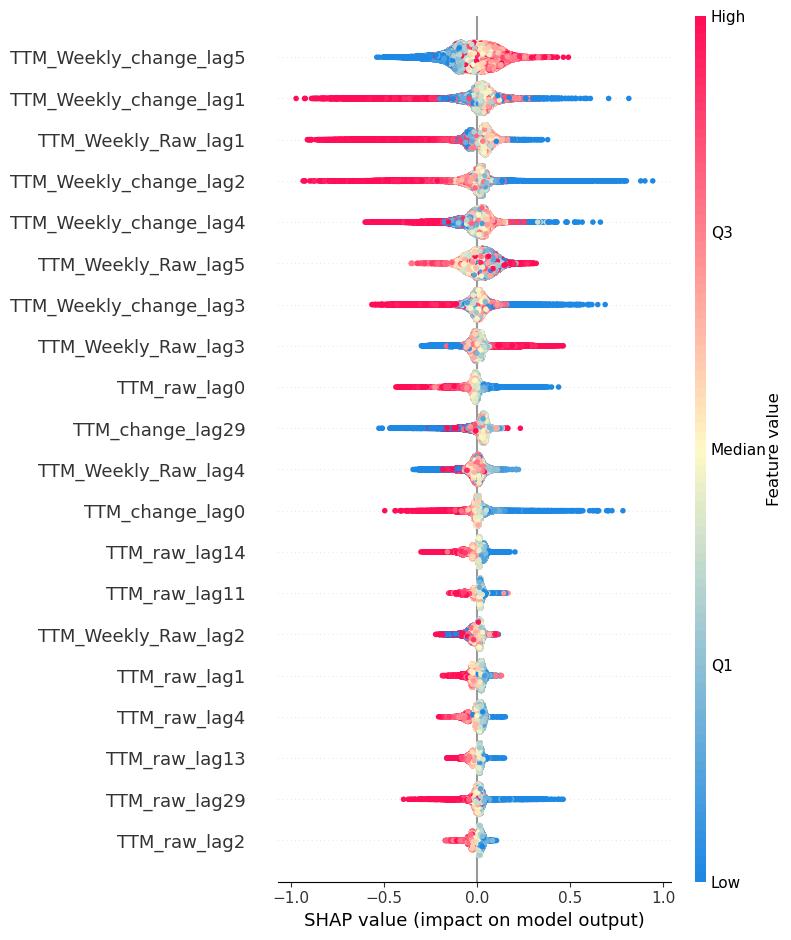

In [52]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Create a custom colormap
colors = ['#1E88E5', '#FFF9C4', '#FF0D57']  # blue, light yellow, red
n_bins = 100  # Number of color gradations
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

# Prepare the plot
plt.figure(figsize=(12, 8))

# Create the summary plot with custom colormap
shap.summary_plot(
    shap_values, 
    X_test,
    plot_type="dot",
    cmap=cmap,
    show=False  # Don't display the plot yet
)

# Modify the colorbar
cbar = plt.gcf().axes[-1]  # Get the colorbar axes
cbar.set_ylabel("Feature value")

# Adjust colorbar ticks for better readability
cbar.set_yticks(np.linspace(0, 1, 5))
cbar.set_yticklabels(['Low', 'Q1', 'Median', 'Q3', 'High'])

# Display the plot
plt.tight_layout()
plt.show()


# TTM_Weekly_Change_Lag1 being low can increase the prediction.  Lets take a look at some rows where the TTM__Weekly_Change_Lag1 is small (aka negative)

Percent Gain -3.41211169551944


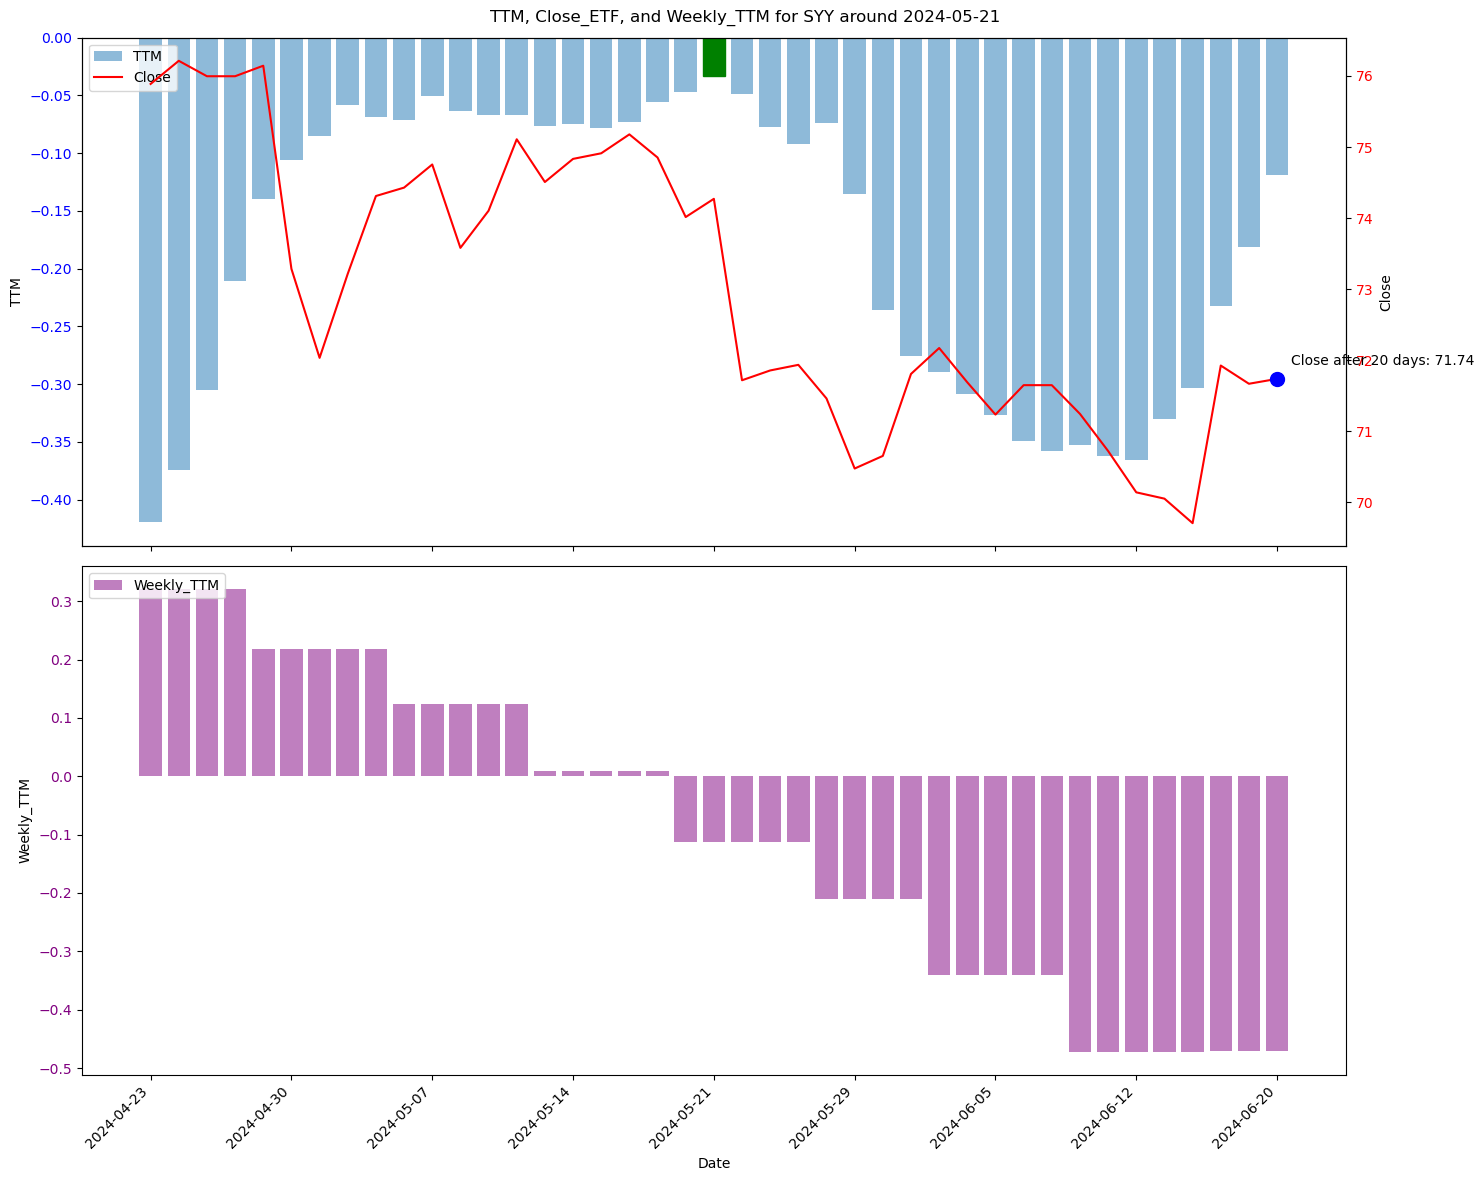

Percent Gain 3.2797725791336503


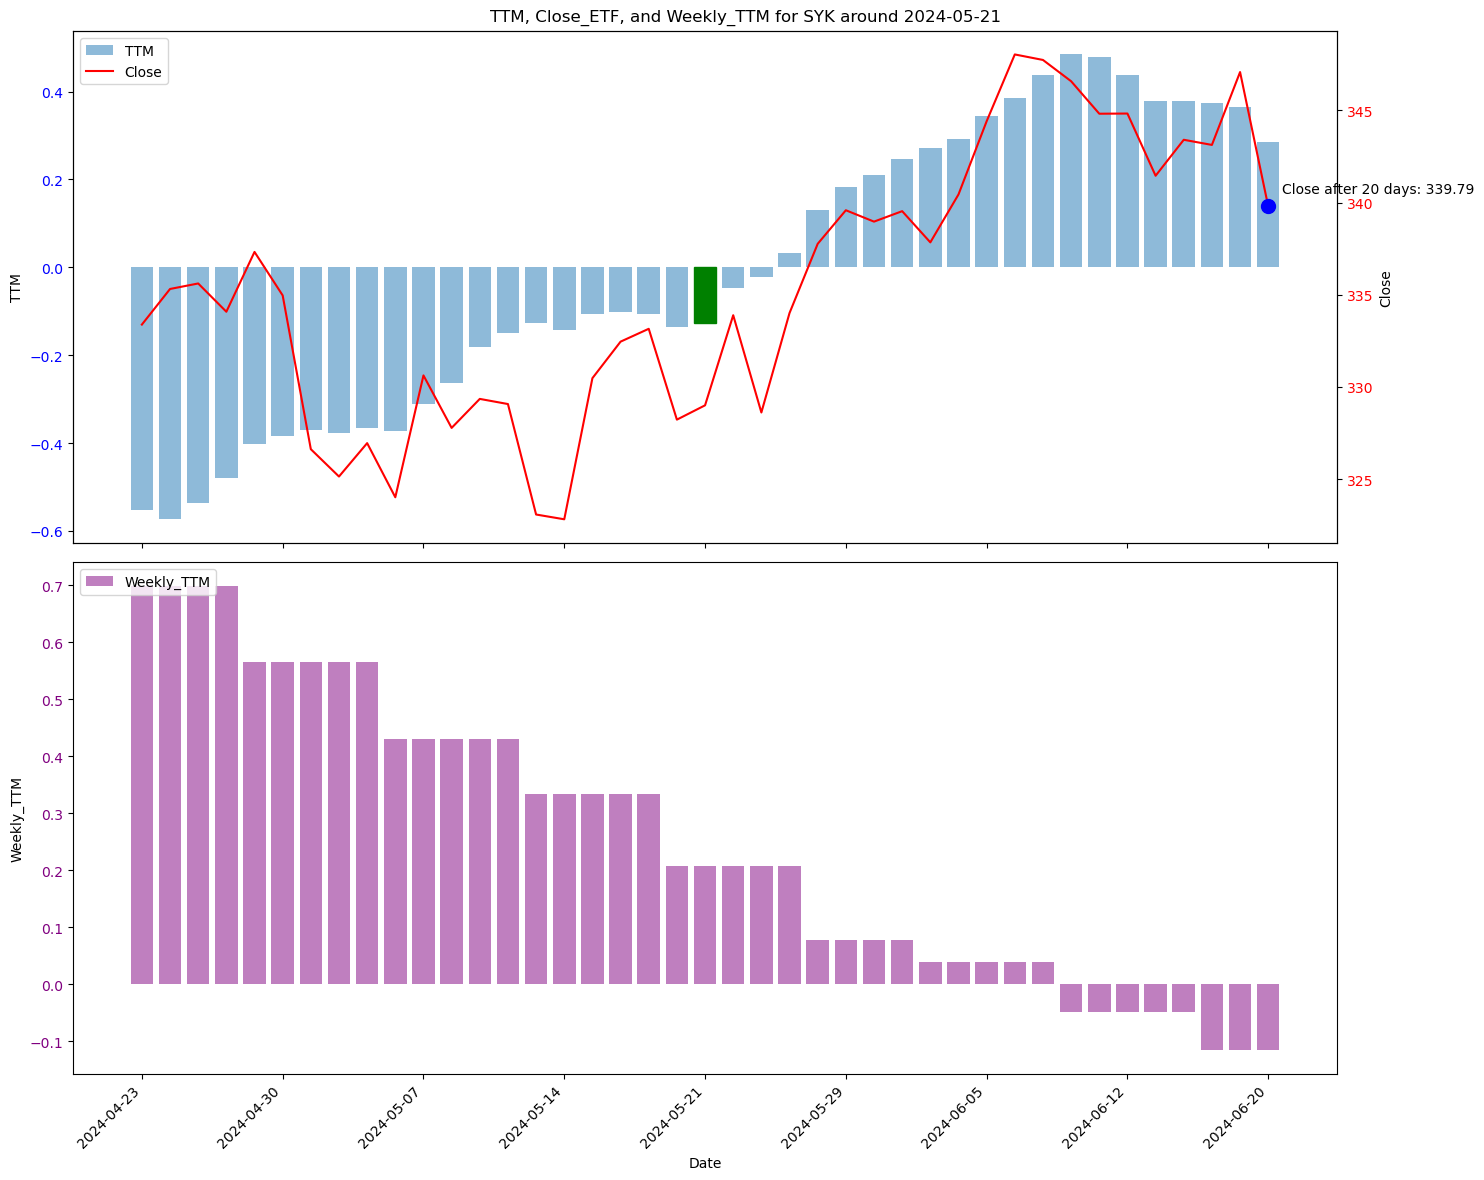

Percent Gain -12.12022514813886


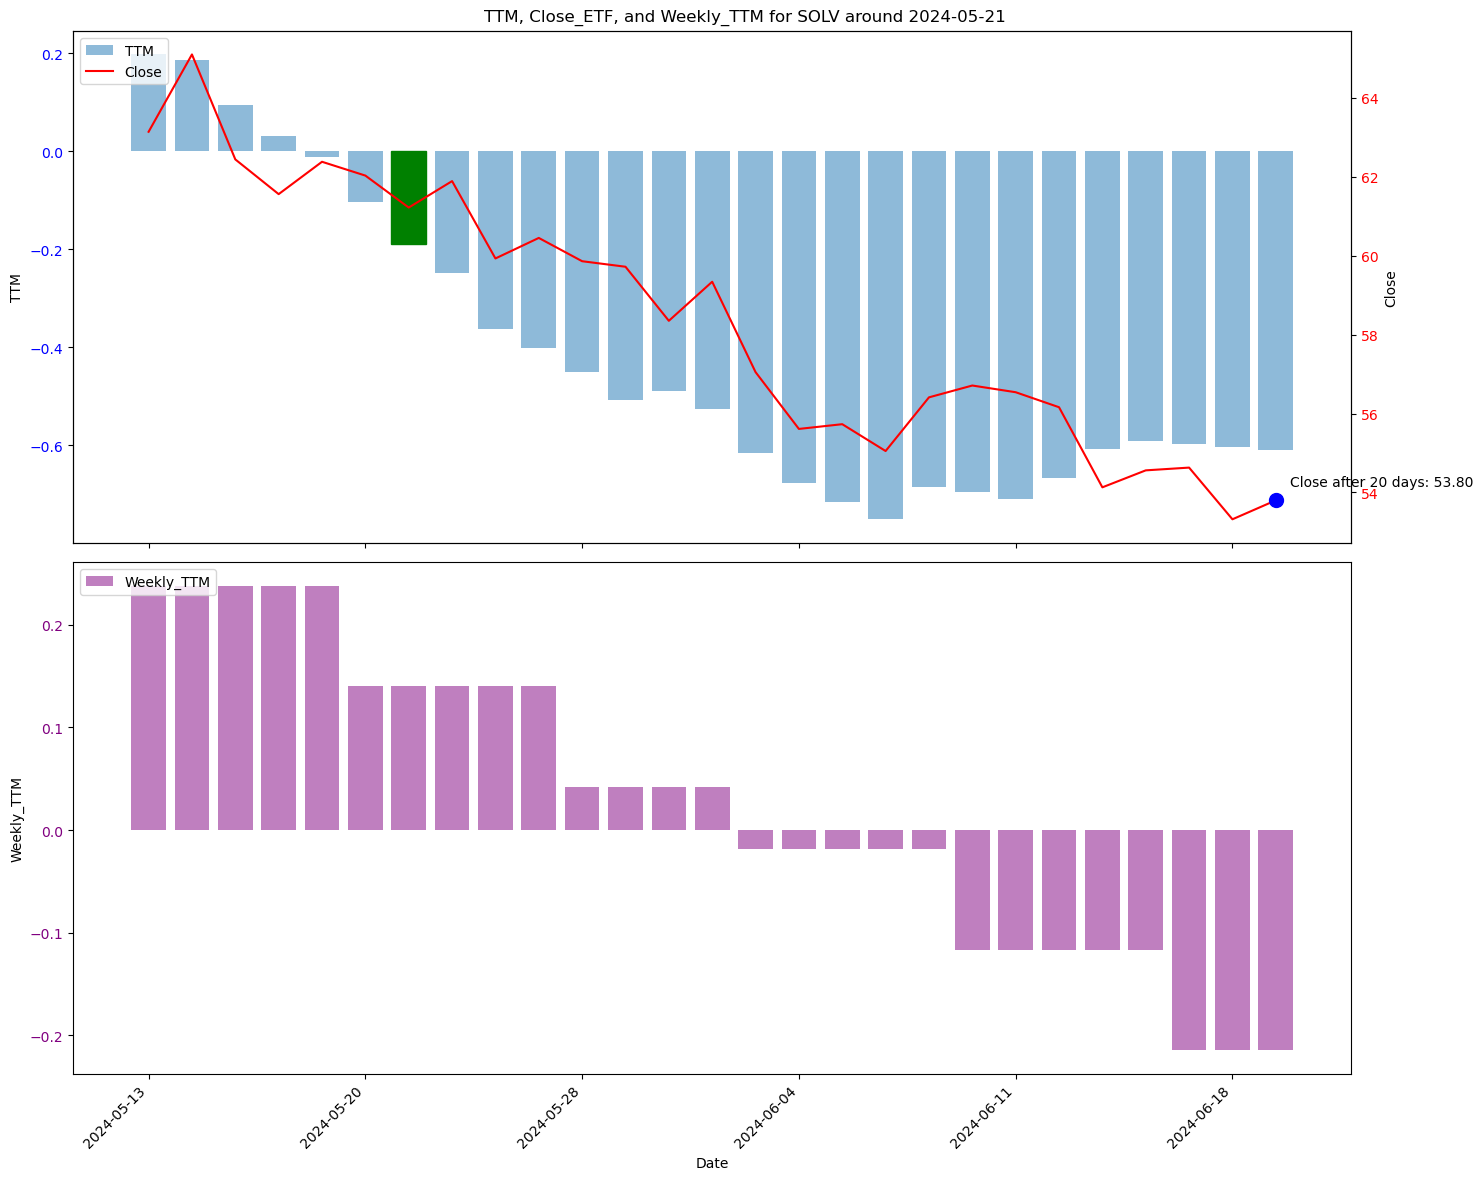

Percent Gain 2.0790960183461897


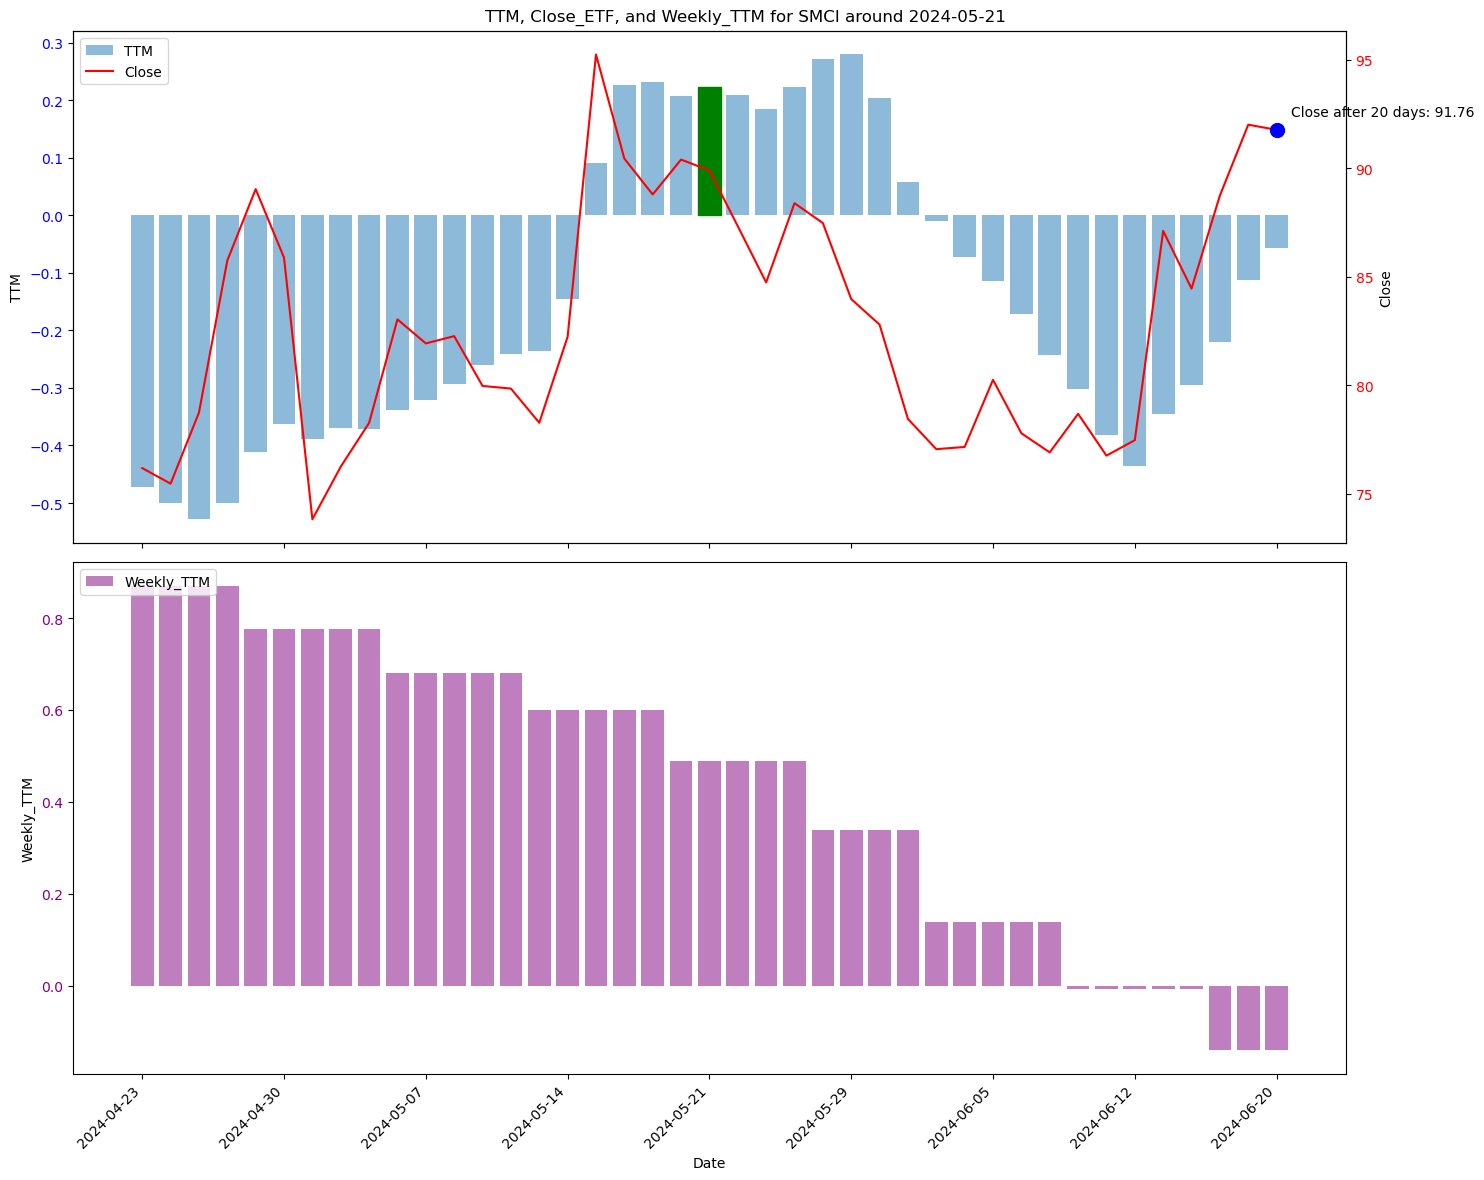

In [259]:
U=test[test['TTM_Weekly_change_lag1']<df['TTM_Weekly_change_lag1'].quantile(0.25)]
three_tick=U['Ticker'].values[14683:14687]
date=U['Date'].values[14683:14687]

#check=test[test['Ticker'].isin(three_tick)]
test_row=U[(U['Date'].isin(date))&(U['Ticker'].isin(three_tick))]
test_row

for ind,row in test_row.iterrows():
    tick=row['Ticker']
    date=row['Date']
    check=df[(df['Ticker']==tick)]
    
    mf.plot_ttm_and_close(check,tick,date)

The prediction is:  [1 1 1 1]
The predicted probability is:  [[0.38376385 0.61623615]
 [0.35661787 0.64338213]
 [0.40273422 0.5972658 ]
 [0.44383746 0.55616254]]


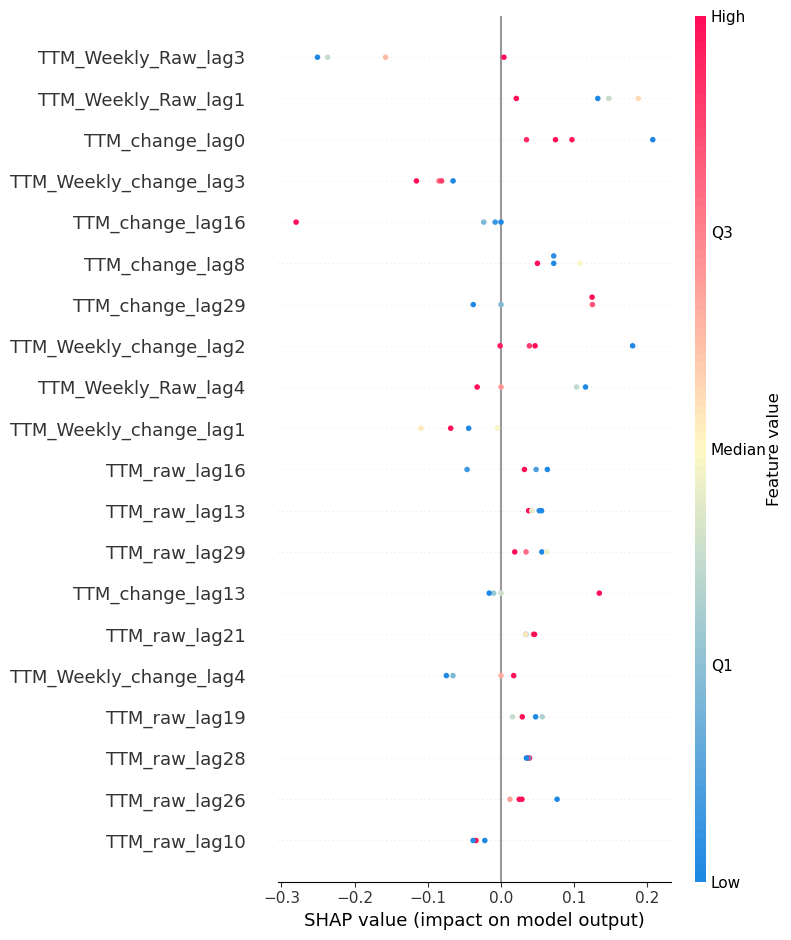

In [255]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
def shap_of_one(model,test_row,features):
    print ('The prediction is: ', model.predict(test_row[features]))
    print ('The predicted probability is: ', model.predict_proba(test_row[features]))
    # Calculate SHAP values for the single test row
    shap_values = explainer.shap_values(test_row[features])
    
    # For binary classification, shap_values is typically a list with two elements
    # We want to use the second element for positive class predictions
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use the second element for positive class
    
    # Create a custom colormap
    colors = ['#1E88E5', '#FFF9C4', '#FF0D57']  # blue, light yellow, red
    n_bins = 100  # Number of color gradations
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    # Prepare the plot
    plt.figure(figsize=(12, 8))
    
    # Create the summary plot with custom colormap
    shap.summary_plot(
        shap_values, 
        test_row[features],  # Use test_row instead of X_test
        plot_type="dot",
        cmap=cmap,
        show=False  # Don't display the plot yet
    )
    
    # Modify the colorbar
    cbar = plt.gcf().axes[-1]  # Get the colorbar axes
    cbar.set_ylabel("Feature value")
    
    # Adjust colorbar ticks for better readability
    cbar.set_yticks(np.linspace(0, 1, 5))
    cbar.set_yticklabels(['Low', 'Q1', 'Median', 'Q3', 'High'])
    
    # Display the plot
    plt.tight_layout()
    plt.show()
shap_of_one(model,test_row,features)

#### We see that the model decisions are complex.  With respect to TTM_Weekly_Change_Lag1 we see a case where a high value increased the prediciton and we also see that in other cases a low value increases the prediciton.

In [21]:
df['Invest_1020']=((df['Invest_10'])&(df['Invest_20']))|(((df['Invest_7'])&(df['Invest_20'])))
df['Pct_Change_1020']=df['Pct_Change_20']
df['Invest_1020'].value_counts()

Invest_1020
False    212014
True     176749
Name: count, dtype: int64

In [23]:
from xgboost import XGBClassifier
features=[col for col in df.columns if 'TTM' in col and 'lag' in col]+[col for col in df.columns if 'Squeeze_On' in col and 'Lag' in col]

model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(df,features,1020,model)

Model:  target- pct_change_1020

Train Size 0.8
Training Size: 536 Days
Test Size: 169 Days
Validation Size: 135 Days

*************** Test Set: 2023-11-01 00:00:00: 2024-07-05 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.028865020102503504
Avg Pct Gain of Test Data:  0.02370501238793823
Correlation of Predicted Probability with Pct change (Test Set):  0.07288736039060623
Correlation of The slope of RS values with Pct change (Test Set):  -0.0009211471119730307
	Accuracy (Test Set): 0.4932
	Precision (Test Set): 0.5377
	Recall (Test Set): 0.2483
	F1 Score (Test Set): 0.3397
	Mathews Score (Test Set): 0.0143

*************** Validation Set: 2023-04-19 00:00:00: 2023-10-30 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.006673581392288385
Avg Pct Gain of Validation Data:  0.00556033319194034
Correlation of Predicted Probability with Pct change (Validation Set):  0.010141285581835519
Correlation of The slope of RS values with Pct change (Valid

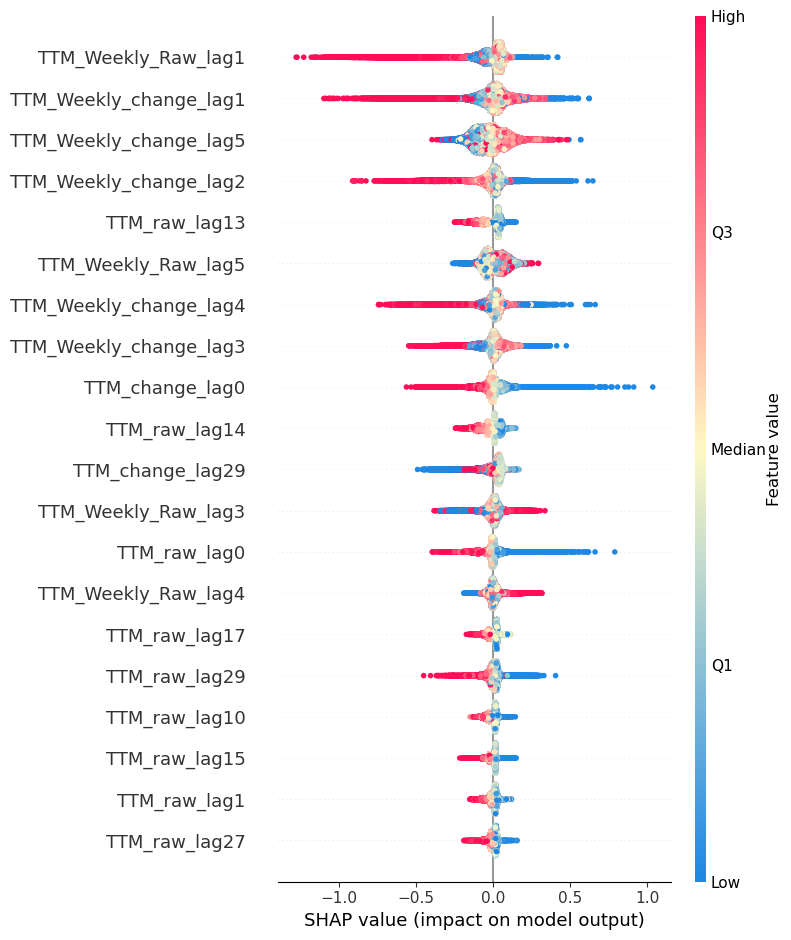

In [25]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
def plot_shap(model, X_test):
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # Create a custom colormap
    colors = ['#1E88E5', '#FFF9C4', '#FF0D57']  # blue, light yellow, red
    n_bins = 100  # Number of color gradations
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    # Prepare the plot
    plt.figure(figsize=(12, 8))
    
    # Create the summary plot with custom colormap
    shap.summary_plot(
        shap_values, 
        X_test,
        plot_type="dot",
        cmap=cmap,
        show=False  # Don't display the plot yet
    )
    
    # Modify the colorbar
    cbar = plt.gcf().axes[-1]  # Get the colorbar axes
    cbar.set_ylabel("Feature value")
    
    # Adjust colorbar ticks for better readability
    cbar.set_yticks(np.linspace(0, 1, 5))
    cbar.set_yticklabels(['Low', 'Q1', 'Median', 'Q3', 'High'])
    
    # Display the plot
    plt.tight_layout()
    plt.show()
plot_shap(model,X_test)

### It still strikes me as suprising that there are so many data points where a high raw ttm weekly value causes a lower prediction.  The raw ttm value is the height of the bar which is suppose to indicate strength.

In [29]:
features=['TTM_Weekly_Raw_lag1','TTM_raw_lag0','TTM_change_lag0','TTM_Weekly_change_lag1']
model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(df,features,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 536 Days
Test Size: 169 Days
Validation Size: 135 Days

*************** Test Set: 2023-11-01 00:00:00: 2024-07-05 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.026035084139822903
Avg Pct Gain of Test Data:  0.023705012387938228
Correlation of Predicted Probability with Pct change (Test Set):  0.044865148737523036
Correlation of The slope of RS values with Pct change (Test Set):  -0.0009211471119730307
	Accuracy (Test Set): 0.5373
	Precision (Test Set): 0.6223
	Recall (Test Set): 0.6390
	F1 Score (Test Set): 0.6305
	Mathews Score (Test Set): 0.0120

*************** Validation Set: 2023-04-19 00:00:00: 2023-10-30 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.007345581830083182
Avg Pct Gain of Validation Data:  0.005560333191940341
Correlation of Predicted Probability with Pct change (Validation Set):  0.03600818310714318
Correlation of The slope of RS values with Pct change (Valid

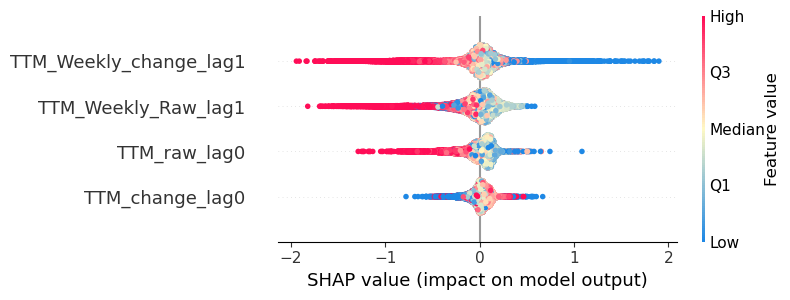

In [31]:
plot_shap(model,X_test)

In [44]:
features=['Correlation','RS_Slope']
model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(df,features,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 536 Days
Test Size: 169 Days
Validation Size: 135 Days

*************** Test Set: 2023-11-01 00:00:00: 2024-07-05 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.023526571741053097
Avg Pct Gain of Test Data:  0.023705012387938228
Correlation of Predicted Probability with Pct change (Test Set):  -0.002991303306790101
Correlation of The slope of RS values with Pct change (Test Set):  -0.0009211471119730307
	Accuracy (Test Set): 0.6007
	Precision (Test Set): 0.6195
	Recall (Test Set): 0.9170
	F1 Score (Test Set): 0.7394
	Mathews Score (Test Set): 0.0111

*************** Validation Set: 2023-04-19 00:00:00: 2023-10-30 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.0046444886732316245
Avg Pct Gain of Validation Data:  0.005560333191940342
Correlation of Predicted Probability with Pct change (Validation Set):  -0.022473528604676555
Correlation of The slope of RS values with Pct change (V

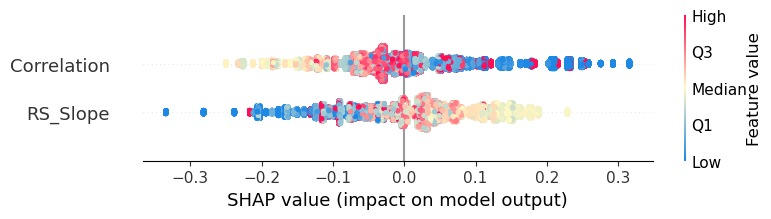

In [48]:
plot_shap(model,X_test)

# Return To the Product Strategy

In [3]:
def combined_rank(industry_rank, stock_rank):
    return (industry_rank - 1) * 3 + stock_rank
def get_rank_by_column(df,col,holding_period):
    df['Gain Rank'] = df.groupby(['Date'])[f'Pct_Change_{holding_period}'].rank(method='dense', ascending=False)
    df[f'Industry_Rank_{col}']=df.groupby(['Date'])[f'{col}_ETF'].rank(method='dense', ascending=False)
    df[f'Stock_Rank_{col}']=df.groupby(['Date'])[f'{col}'].rank(method='dense', ascending=False)
    df['Combined Rank'] = (df[f'Industry_Rank_{col}']-1)*len(df[f'Industry_Rank_{col}'].unique())+df[f'Stock_Rank_{col}']
    return df


# Rank ETFs/Stocks by their Product for each day and Compare with the Percent gain rank for each day.

In [9]:
import pipeline_2 as pipe
df['ETF']=df['Ticker'].apply(pipe.get_etf)
to_join=etf_df[['Ticker','Date','RS_Slope','Correlation']]
to_join['Product_ETF']=abs(to_join['Correlation'])*to_join['RS_Slope']
to_join.rename(columns={'Ticker':'Ticker_ETF','RS_Slope':'RS_Slope_ETF','Correlation':'Correlation_ETF'},inplace=True)
to_join['Date']=pd.to_datetime(to_join['Date']).dt.date
df['Date']=pd.to_datetime(df['Date']).dt.date
joined=pd.merge(df,to_join, left_on=['ETF', 'Date'], right_on=['Ticker_ETF','Date'])
#joined=get_rank_by_column(joined,'Product',20)

In [11]:
joined=get_rank_by_column(joined,'Product',20)

In [75]:
joined[['Combined Rank','Gain Rank']].corr('spearman')

Combined Rank  Gain Rank
Combined Rank       1.000000  -0.004028
Gain Rank          -0.004028   1.000000

In [ ]:
**There is seemingly little correlation between the rank of the metric and the percent gain rank**

In [77]:
filtered=joined[joined['Combined Rank'].isin([i for i in range(9)])]
filtered[['Combined Rank','Gain Rank']].corr('spearman')

Combined Rank  Gain Rank
Combined Rank       1.000000   0.075688
Gain Rank           0.075688   1.000000

**Within The top 9 there is more of monotonic relationship between the percent gain rank and the metric combined rank**

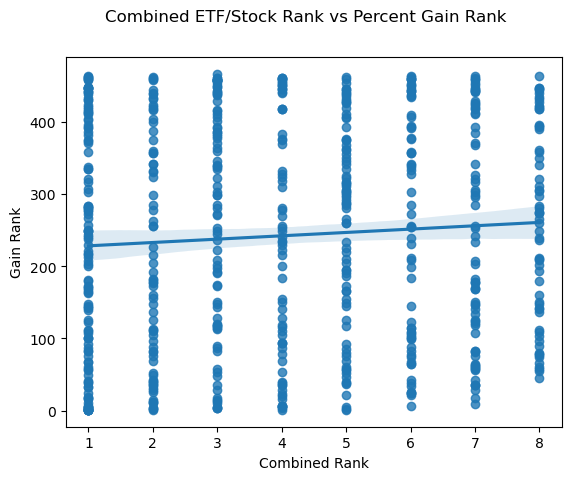

In [93]:
import seaborn as sns
fig, ax=plt.subplots()
sns.regplot(x='Combined Rank',y='Gain Rank', data=filtered,ax=ax)
fig.suptitle('Combined ETF/Stock Rank vs Percent Gain Rank')
plt.show()

In [85]:
print('Average Percent Gain of the Top 9 stocks ranked by product', filtered['Pct_Change_20'].mean())
print('Average Percent gain of all data', joined['Pct_Change_20'].mean())

0.017758665607609043

# There does seem to be a significant difference between the average percent gain of the top 9 ranked by product stocks.